# Práctica 1 - Predicción de la producción de la energía solar

Este Proyecto consiste en emplear las diferentes técnicas de aprendizaje automático vistas en clase con el objetivo de aplicarlas de una manera práctica a un problema real. Dicho problema, consiste en determinar la cantidad de energía solar que se necesitará generar en las próximas 24 horas. Para ello, utilizaremos variables meteorológicas predichas por GFS. 

Se tratará durante todo el proyecto explicar de forma concreta y concisa las diferentes decisiones que emplearemos en lo referente a los diferentes métodos o técnicas que se implementen durante el transcurso de la práctica así como la justificación pertinente de los hallazgos obtenidos. Dicho esto, la estructura que seguiremos será la siguiente. En primer lugar, realizaremos un análisis exploratorio (EDA); posteriormente, dividiremos los datos en “train” y “test”, con el objetivo de evaluar  el modelo mediante los distintos métodos básicos vistos en clase como: KNN, árboles de regresión y regresión lineal. Además, serán evaluados con distintas métricas de evaluación, y se medirán o corregirán aspectos como el tiempo de entrenamiento o la dimensionalidad del problema, respectivamente. Por último, evaluaremos el problema con métodos avanzados como SVM y Random Forest; con el objetivo de determinar de una forma global, cuál es el mejor método, construir el modelo final y realizar predicciones sobre dicho modelo.

## Leer los datos del conjunto

Para comprender mejor el conjunto de datos vamos utilizar la librería Pandas para explorar los datos en forma de DataFrame.

Primero vamos a importarnos todas librerías que utilizaremos durante la práctica:

In [3]:
%pip install lightgbm

In [ ]:
%pip install xgboost

     --------------------------------------- 70.9/70.9 MB 12.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Librerías generales para las operaciones
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import randint as sp_randint
import pickle

# Librerías optimización y errores
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import probplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.inspection import permutation_importance
import multiprocessing

# Librerías DummyRegressor
from sklearn.dummy import DummyRegressor

# Librerías Árboles de decisión
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text

# Librerías KNN
from sklearn.neighbors import KNeighborsRegressor

# Librerías Regresión Lineal
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Librerías Reducción Dimensionalidad
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
import plotly.express as px

# Librerías SVM
from sklearn.svm import SVR

# Librerías RandomForest
from sklearn.ensemble import RandomForestRegressor

# Librerías Extremely Randomized Trees
from sklearn.ensemble import ExtraTreesRegressor

#Librerías Gradient Boosting Trees
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Warnings
import warnings
warnings.filterwarnings('ignore')

Leeremos dos conjuntos de datos:

* `Datos disponibles`, que contiene 12 años de datos, una       instancia por día, de los 75 atributos y la variable de respuesta. Estos datos se utilizaran para entrenar, HPO, evaluar y construir el modelo final. (Con el nombre de `disp_df`)

* `Datos de competición`, que contiene 2 años de datos, una       instancia por día, de los 75 atributos pero sin la variable de respuesta. Estos datos se utilizaran para hacer predicciones con el modelo final. (Con el nombre de `comp_df`)

In [2]:
disp_df = pd.read_csv("disp_st12ns1.txt.bz2",compression="bz2",index_col=0)
comp_df = pd.read_csv("comp_st12ns1.txt.bz2",compression="bz2",index_col=0)

# disp_numpy = disp_df.to_numpy()

# X_numpy = disp_numpy[:,:-1]
# y_numpy = disp_numpy[:,-1]

In [3]:
pd.options.display.max_columns = 80
pd.options.display.max_rows = 80
pd.options.display.max_colwidth = 500

Inspeccionamos las cinco primeras filas de cada DataFrame utilizando el método `.head()` para obtener una visión general de los datos.

In [4]:
disp_df.head()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
V1,0.0,0.000000,0.000000,0.000000,0.000000,249.310855,244.968914,251.083577,266.377672,265.195623,0.0,30.000000,200.000000,500.000000,320.000000,101954.134943,102138.802557,102157.899858,101946.146307,101963.188920,7.388284,8.581818,9.415345,9.881818,9.727869,0.002857,0.003432,0.003760,0.003951,0.003987,0.000000,0.000000,0.000000,0.000000,0.003636,0.000318,0.000109,0.000500,0.001900,0.005318,280.835241,278.491086,284.700489,285.745322,285.740365,278.052571,277.190796,277.191992,284.788780,278.118772,278.049253,278.512204,284.733690,285.687411,278.127228,276.578375,278.341295,287.417672,287.368819,275.536444,340.304049,330.886100,349.444308,390.228599,375.281225,248.607712,246.686293,248.487543,257.615132,253.976936,0.0,8.000000,46.727273,103.909091,70.818182,10335300
V2,0.0,0.000909,0.002727,0.386364,0.593636,261.180414,282.642306,294.436640,305.987196,302.019992,0.0,19.090909,136.363636,345.454545,208.181818,101277.040483,101223.766335,101156.314631,101240.897727,101628.233665,12.152521,11.678225,11.304810,14.022680,9.133366,0.003410,0.003423,0.003687,0.004861,0.003719,0.110909,0.122727,0.088182,0.342727,0.006364,0.111218,0.120982,0.088227,0.342645,0.007891,278.513231,278.363378,285.818584,286.643047,286.616125,277.327098,277.106079,277.106079,283.716095,281.186540,277.746252,278.379478,285.804599,283.770183,281.190469,276.902738,278.533098,287.312608,283.952750,279.823431,331.705369,332.900127,349.070274,383.563221,370.955622,214.018509,214.367354,214.481821,228.924782,219.052916,0.0,3.363636,25.000000,65.727273,39.363636,4711500
V3,0.0,0.000000,0.000000,0.000000,0.000909,214.461820,208.086931,214.405820,242.165487,249.112860,0.0,30.000000,208.181818,505.454545,325.636364,102433.551847,102413.117898,102044.440341,101491.142045,101375.539773,4.954043,5.185801,6.136364,9.045455,11.054545,0.002116,0.002105,0.002298,0.002840,0.002966,0.000000,0.000000,0.003636,0.016364,0.017273,0.000455,0.001182,0.005491,0.017055,0.017227,273.106459,269.526156,276.085790,280.740420,281.205292,268.832400,267.954998,267.952800,276.244521,276.211060,268.838695,269.506098,276.031727,280.739150,277.777666,268.223966,270.309174,282.932720,283.513716,275.670052,301.730755,292.297416,313.341672,370.520954,358.587574,234.382926,227.465100,229.753478,245.450058,238.711284,0.0,8.000000,47.727273,106.090909,70.909091,7239600
V4,0.0,0.000000,0.000000,0.000000,0.000000,244.317594,221.805635,222.675403,232.183646,234.349503,0.0,30.000000,209.090909,517.272727,338.363636,102384.600142,102680.332386,102829.982955,102602.475852,102502.646307,6.498995,5.432595,5.462903,5.840904,6.466383,0.002602,0.002369,0.002407,0.002633,0.002733,0.000000,0.000000,0.000000,0.007273,0.029091,0.000064,0.000955,0.000282,0.009091,0.030145,280.023318,274.322374,276.368633,278.668549,278.690213,274.416396,272.271873,272.275074,276.470262,270.902971,274.448794,272.645713,276.368658,278.662462,270.991921,273.452040,273.011885,280.600508,281.789864,268.982669,331.492790,312.125200,323.123660,358.025060,344.891047,240.693960,239.189503,240.762208,249.200309,242.867405,0.0,7.818182,47.818182,108.818182,73.909091,8842500
V5,0.0,0.000000,0.000000,0.000000,0.000000,237.980929,

In [5]:
comp_df.head()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
V4381,0.0,0.0,0.0,0.0,0.0,267.132266,267.540083,274.072549,293.260481,292.107957,0.0,30.000000,200.000000,488.181818,317.272727,101071.018466,100961.499290,100788.303267,100359.262784,100329.743608,13.732074,14.585661,14.011844,13.597217,12.664981,0.003249,0.003357,0.004101,0.004320,0.004112,0.000909,0.000000,0.000000,0.006364,0.012727,0.002227,0.001409,0.001055,0.008473,0.011573,280.174638,282.513930,289.614918,291.515378,291.516857,277.805306,278.489874,278.490057,289.747950,286.333410,278.427937,282.521948,289.617304,291.480530,286.320035,275.466406,281.544292,291.465229,291.756930,284.295604,328.719863,335.449910,361.301181,413.796353,402.435866,246.187006,242.691082,249.430893,269.397214,261.904727,0.0,8.000000,46.000000,101.727273,68.363636
V4382,0.0,0.0,0.0,0.0,0.0,270.748649,254.900246,254.247431,263.459176,264.942746,0.0,30.000000,210.000000,499.090909,319.090909,100921.470170,101210.105114,101308.178977,101066.252131,101121.680398,9.445162,7.329839,6.528921,7.748265,7.700000,0.003214,0.003318,0.003511,0.003341,0.003131,0.044545,0.000000,0.000909,0.025455,0.024545,0.044027,0.000673,0.002800,0.024527,0.024800,283.669988,281.423429,285.394157,286.768288,286.767808,281.306768,279.967310,279.968348,285.487918,278.964064,281.499881,280.441112,285.391280,286.756689,278.947979,280.545111,280.208740,288.088310,288.298739,276.291193,354.781311,346.509177,359.669947,394.726080,380.254561,238.988552,233.998055,245.627391,256.575625,244.646384,0.0,7.818182,48.000000,106.090909,70.000000
V4383,0.0,0.0,0.0,0.0,0.0,275.365811,253.760886,258.189711,285.814650,284.704018,0.0,30.000000,202.727273,460.000000,297.272727,101046.946733,101035.229403,100847.215909,100524.959517,100534.660511,10.751840,9.883052,10.345093,11.456364,12.243199,0.002230,0.002512,0.003037,0.003394,0.003309,0.026364,0.000000,0.030000,0.038182,0.023636,0.024973,0.000873,0.030418,0.038445,0.023609,280.093983,278.992185,285.817633,288.105616,288.100400,278.962491,277.733468,277.734200,285.939298,283.362732,279.079604,278.861259,285.819830,288.092244,283.354939,277.782679,278.660400,288.552393,289.280190,281.060211,339.520738,333.994976,352.326014,398.928189,387.369798,168.699892,234.773567,242.297372,229.413043,232.641828,0.0,7.818182,46.000000,93.727273,62.909091
V4384,0.0,0.0,0.0,0.0,0.0,277.931155,280.329082,283.955256,293.605349,293.676752,0.0,27.272727,200.000000,508.181818,330.000000,99584.247869,99589.722301,99417.838778,99245.132812,99577.468750,13.238070,12.824776,6.897715,9.537476,14.802119,0.002191,0.003023,0.004352,0.004018,0.004534,0.021818,0.020909,0.000909,0.002727,0.005455,0.020191,0.020336,0.001173,0.002764,0.006745,283.665777,284.994806,293.253984,294.212910,294.211997,282.344152,283.516396,283.517728,293.380133,288.798870,283.519947,284.992348,293.261938,294.015694,288.788583,281.968733,284.008298,294.047344,293.868958,287.046173,353.606215,360.593878,380.032976,426.886924,415.103499,228.819425,232.811838,241.750927,292.987294,286.279308,0.0,6.727273,44.545455,107.000000,72.545455
V4385,0.0,0.0,0.0,0.0,0.0,275.410475,264.338559,266.438330,279.696322,278.253951,0.0,25.454545,200.000000,500.000000,330.000000,100879.294034,101241.776278,1014

Vamos a averiguar cuantas instancias tiene cada DataFrame.

In [6]:
print("Los datos disponibles tienen: ", len(disp_df), "instancias")
print("Los datos de competición tienen: ", len(comp_df), "instancias")

Los datos disponibles tienen:  4380 instancias
Los datos de competición tienen:  733 instancias


Vamos a mirar cuáles son los rangos de valores para los atributos de ambos DataFrames, con el objetivo de obtener información relevante general del conjunto de datos que vamos a estudiar y emplear en la práctica.

In [7]:
disp_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.558380,0.203449,0.380525,0.208010,0.408452,311.185622,311.340651,319.221478,340.225322,339.816287,0.058219,158.219946,371.344583,690.611602,514.941885,101696.979351,101740.598108,101692.367800,101478.267195,101444.811438,20.021110,20.050433,20.569704,21.112336,21.213665,0.007233,0.007879,0.008232,0.008325,0.008651,0.064166,0.064459,0.061373,0.059958,0.057347,0.064466,0.064772,0.061678,0.060294,0.057743,286.672472,287.999150,292.910724,294.787048,294.852187,284.204513,284.214946,284.200168,292.878707,291.202490,284.451525,287.928364,292.852404,294.617951,291.449587,283.677760,289.251582,296.213126,296.736878,290.617478,374.582337,380.968596,401.937237,445.131783,436.559700,246.468585,246.214964,250.945084,262.682297,261.758022,0.065235,37.838294,76.823620,130.052657,102.146326,1.666006e+07
std,2.247592,0.859344,1.536489,0.872591,1.574616,56.454183,58.427665,60.058098,63.869161,63.669927,0.257499,111.272834,157.160306,223.673259,193.526985,777.296333,785.464270,773.016664,751.507040,767.883622,11.528899,11.546784,11.658113,11.767091,11.854096,0.004226,0.004472,0.004350,0.004193,0.004465,0.162418,0.166139,0.166603,0.156435,0.153773,0.162253,0.166001,0.166471,0.156302,0.153651,9.839842,10.565805,10.817041,10.774486,10.759952,9.642763,9.717803,9.719095,10.865466,11.308518,9.550809,10.623933,10.857200,10.769891,11.320720,9.719351,11.202420,11.277561,11.215577,11.841488,51.162437,55.587170,59.320787,66.632699,66.045498,36.298524,36.964716,37.304759,40.697915,39.849610,0.238998,25.800511,30.643243,41.781372,35.926444,7.959358e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,159.426315,160.860615,168.985918,182.785973,178.797506,0.000000,0.000000,21.818182,46.363636,29.636364,99120.205256,98766.199574,98548.372159,98431.341619,98355.534091,1.163636,1.205728,1.361897,1.397348,1.373974,0.000405,0.000441,0.000471,0.000553,0.000587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250.695582,253.765601,257.514321,260.302182,260.602567,248.234992,248.381585,248.382167,257.640148,254.519201,248.329339,253.751680,257.514463,260.300889,254.570777,245.555342,254.733529,262.252561,263.706293,251.706961,210.841615,220.167304,243.709324,273.394811,266.798515,96.489449,112.960575,

In [8]:
comp_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,0.527403,0.233411,0.464314,0.287631,0.529825,314.630362,314.514220,322.085737,342.088846,341.604576,0.060647,154.112613,366.578321,687.815329,512.597916,101691.245117,101745.864937,101700.739627,101493.367070,101466.037259,20.913129,20.980695,21.491007,21.994581,22.075775,0.007517,0.008217,0.008636,0.008742,0.009049,0.068038,0.066857,0.063757,0.058297,0.060701,0.068381,0.067173,0.064162,0.058583,0.061118,287.077901,288.427521,293.240016,295.005087,295.063764,284.681684,284.673942,284.655277,293.199075,291.439538,284.924130,288.353704,293.175014,294.845710,291.642235,284.090214,289.550646,296.344547,296.843419,290.757524,376.527421,382.758041,403.349822,445.378576,436.868011,245.556598,245.334038,250.212340,262.492825,261.262116,0.058167,36.943445,77.053454,132.065236,103.199057
std,1.961957,0.849874,1.601215,1.040867,1.903140,57.485258,59.746049,60.892994,63.574112,63.266604,0.244221,108.227505,151.517826,217.133372,187.409751,774.494017,780.464365,771.372226,754.571783,759.045366,12.485897,12.600405,12.709684,12.796820,12.926975,0.004634,0.004904,0.004836,0.004740,0.005028,0.151970,0.162046,0.163153,0.152562,0.156675,0.151905,0.161964,0.163020,0.152386,0.156573,9.564207,10.239155,10.404899,10.333687,10.313337,9.513879,9.588016,9.601334,10.478470,10.922523,9.407210,10.305482,10.469662,10.329086,10.905774,9.648489,10.838057,10.838994,10.660367,11.417669,50.373689,54.441962,57.317952,63.112903,62.533572,38.358233,38.066848,37.979901,40.151973,39.207220,0.224974,24.914178,29.414951,41.495932,34.090581
min,0.000000,0.000000,0.000000,0.000000,0.000000,180.902158,185.245791,191.420602,196.832445,197.711505,0.000000,0.000000,19.090909,60.000000,42.727273,98940.243608,98876.105114,98616.931818,98525.164773,98994.079545,2.301537,2.345627,2.628176,2.265394,2.740079,0.000942,0.000990,0.000972,0.001014,0.000956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000009,0.000009,0.000000,0.000000,259.071048,261.478061,263.209198,265.782607,266.065272,257.550792,257.813504,257.815355,263.367753,259.804918,258.176036,261.078591,263.201671,265.752633,261.076749,254.184518,262.444952,266.871296,267.289903,257.240775,236.598242,247.729695,272.072024,289.779963,289.018818,108.562473,111.780065,116.878193,122.766929,115.950938,0.000000,0.000000,3.272727,9.454545,6.181818
25%,0.000000,0.000000,0.000000,0.000000,0.

## Limpieza de datos

A continuación procederemos a limpiar nuestros datos para poder centrarnos en las características que podrían tener poder predictivo para determinar producción de energía solar en los 2 años.

Para ello, vamos a comprobar nuestros datos para asegurarnos de que no tenemos valores perdidos, o `NaN`s, lo que impedirá que el modelo que escojamos se ejecute correctamente. Utlizaremos la sentencia `df.isna().any()`.

In [9]:
disp_df.isna().any()

apcp_sf1_1    False
apcp_sf2_1    False
apcp_sf3_1    False
apcp_sf4_1    False
apcp_sf5_1    False
dlwrf_s1_1    False
dlwrf_s2_1    False
dlwrf_s3_1    False
dlwrf_s4_1    False
dlwrf_s5_1    False
dswrf_s1_1    False
dswrf_s2_1    False
dswrf_s3_1    False
dswrf_s4_1    False
dswrf_s5_1    False
pres_ms1_1    False
pres_ms2_1    False
pres_ms3_1    False
pres_ms4_1    False
pres_ms5_1    False
pwat_ea1_1    False
pwat_ea2_1    False
pwat_ea3_1    False
pwat_ea4_1    False
pwat_ea5_1    False
spfh_2m1_1    False
spfh_2m2_1    False
spfh_2m3_1    False
spfh_2m4_1    False
spfh_2m5_1    False
tcdc_ea1_1    False
tcdc_ea2_1    False
tcdc_ea3_1    False
tcdc_ea4_1    False
tcdc_ea5_1    False
tcolc_e1_1    False
tcolc_e2_1    False
tcolc_e3_1    False
tcolc_e4_1    False
tcolc_e5_1    False
tmax_2m1_1    False
tmax_2m2_1    False
tmax_2m3_1    False
tmax_2m4_1    False
tmax_2m5_1    False
tmin_2m1_1    False
tmin_2m2_1    False
tmin_2m3_1    False
tmin_2m4_1    False
tmin_2m5_1    False


Como podemos observar no hay ningún valor Nan en los atributos de los datos proporcionados y por tanto podemos continuar con el `Análisis Exploratorio de Datos (EDA)`.

## Análisis Exploratorio de Datos (EDA)

Ahora vamos a investigar algunas de los diferentes atributos para ver lo que podría correlacionarse más con nuestra variable dependiente, `salida`. Los atributos con las mejores correlaciones podrían ser los más útiles para el modelo dque escojamos más adelante.

Para ello, vamos a emplear el método `.corr()`, que nos permite ver los coeficientes de correlación para cada par de nuestros diferentes atributos. 

In [10]:
disp_df.corr()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
apcp_sf1_1,1.000000,0.513250,0.458914,0.288846,0.283480,0.242242,0.215933,0.185878,0.116174,0.104890,0.009593,-0.076515,-0.133882,-0.137414,-0.095597,-0.135865,-0.131968,-0.113115,-0.091624,-0.076209,0.280871,0.230824,0.195241,0.162598,0.138009,0.215095,0.176467,0.159295,0.144129,0.118646,0.535993,0.362235,0.263274,0.213626,0.160947,0.535905,0.362086,0.263136,0.213431,0.160718,0.084797,0.049803,0.005990,-0.010070,-0.008597,0.092928,0.089927,0.087380,-0.005459,0.006422,0.095064,0.044068,-0.000492,-0.014667,0.011720,0.107674,0.031053,-0.028688,-0.028447,0.021695,0.099663,0.072584,0.029589,-0.032845,-0.020221,-0.372384,-0.250617,-0.216140,-0.149785,-0.135814,-0.040204,-0.107380,-0.168593,-0.146649,-0.110759,-0.132966
apcp_sf2_1,0.513250,1.000000,0.918002,0.434817,0.404176,0.181384,0.198220,0.172942,0.102360,0.090044,-0.016949,-0.146729,-0.246791,-0.263480,-0.209945,-0.088346,-0.093996,-0.085137,-0.070108,-0.062931,0.243626,0.235703,0.199581,0.159196,0.127559,0.136832,0.117060,0.113795,0.105400,0.078128,0.684588,0.697891,0.484281,0.341153,0.210156,0.684622,0.697850,0.484296,0.341033,0.209968,0.037100,0.006522,-0.045546,-0.063087,-0.060942,0.050895,0.051653,0.048603,-0.057883,-0.041303,0.054500,0.001844,-0.052516,-0.068202,-0.034827,0.066742,-0.013510,-0.088669,-0.085751,-0.023946,0.052422,0.030880,-0.018806,-0.090405,-0.074885,-0.309021,-0.360974,-0.349332,-0.257766,-0.233804,-0.039390,-0.175725,-0.279392,-0.250852,-0.215908,-0.222478
apcp_sf3_1,0.458914,0.918002,1.000000,0.631979,0.557734,0.177503,0.198653,0.175170,0.104536,0.091962,-0.020754,-0.162910,-0.284988,-0.331414,-0.267090,-0.087129,-0.097146,-0.087724,-0.073508,-0.068068,0.236984,0.239064,0.213968,0.170987,0.134488,0.129516,0.110123,0.109232,0.103063,0.073390,0.658379,0.764438,0.657398,0.470520,0.281993,0.658370,0.764446,0.657471,0.470479,0.281792,0.026153,-0.002695,-0.063222,-0.085726,-0.083147,0.042683,0.044930,0.041786,-0.077707,-0.059126,0.046938,-0.006828,-0.070737,-0.091819,-0.052334,0.059498,-0.022611,-0.112038,-0.112494,-0.039642,0.042273,0.022448,-0.031652,-0.117178,-0.099518,-0.310265,-0.385922,-0.391383,-0.329706,-0.299237,-0.041465,-0.193862,-0.322445,-0.323788,-0.281120,-0.259669
apcp_sf4_1,0.288846,0.434817,0.631979,1.000000,0.916173,0.160727,0.182444,0.169227,0.126653,0.118070,-0.020276,-0.114183,-0.224306,-0.331341,-0.278087,-0.087639,-0.099217,-0.095346,-0.081548,-0.077905,0.208011,0.225166,0.238057,0.221064,0.186462,0.135018,0.123224,0.133183,0.137600,0.107832,0.423287,0.518999,0.699787,0.699679,0.460082,0.423146,0.518855,0.699816,0.699758,0.460036,0.036058,0.019030,-0.033649,-0.063218,-0.061785,0.054569,0.057620,0.055475,-0.052906,-0.042550,0.057596,0.016955,-0.039664,-0.076258,-0.040233,0.067901,0.005182,-0.074796,-0.098205,-0.026220,0.051369,0.039656,-0.004342,-0.093151,-0.082099,-0.246551,-0.322490,-0.345872,-0.374320,-0.366782,-0.033808,-0.147004,-0.270842,-0.355954,-0.320895,-0.258017
apcp_sf5_1,0.283480,0.404176,0.557734,0.916173,1.000000,0.161818,0.187928,0.177235,0.141589,0.135839,-0.013656,-0.099869,-0.210709,-0.317360,-0.271867,-0.096118,-0.107180,-0.104661,-0.093866,-0.087524,0.212297,0.232521,0.249626,0.246981,0.224266,0.1

A su vez vamos a visualizar los tipos de datos con los que estamos tratando para ver si son categóricos o numéricos ya que a la hora de utilizar ciertas técnicas de aprendizaje automático, estas no son capaces de soportarlos. Para ello vamos a emplear la función `.info()`.

In [11]:
disp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, V1 to V4380
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non-null   float64
 19  pres_ms5_1  4380 non-null   fl

Como se puede observar estamos tratando con variables `continuas`. Ahora procederemos a visualizar con gráficos la variable dependiente `salida`. 

Histograma:

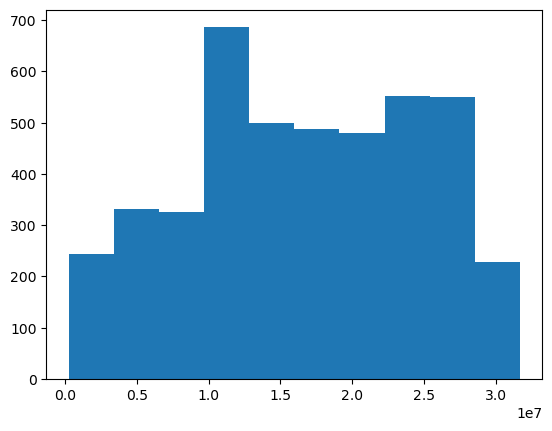

In [12]:
plt.hist(disp_df['salida'])
plt.show()

Hemos realizado un histograma para visualizar los diferentes valores de la salida de la data set. Con ello podemos observar los valores finales del modelo y su distribución, mostrando predominancia de resultados entre 500-700 millones de Julios.

Diagrama de cajas:

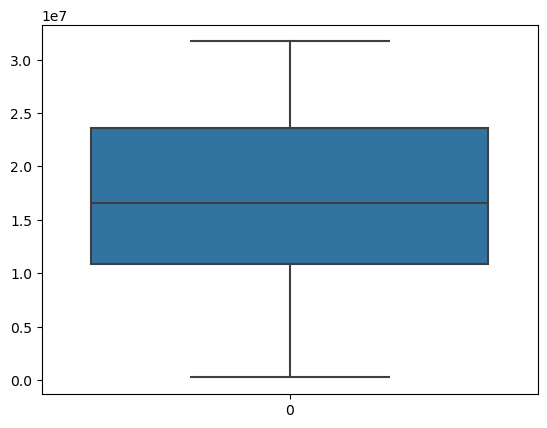

In [13]:
sns.boxplot(disp_df['salida'])
plt.show()

Con respecto al diagrama de caja, se puede observar que la mediana (línea central) está bastante próxima al centro de la caja lo que implica que la distribución de los datos es decentemente simétrica. Otro aspecto que se puede observar es que, el cuadro es mas largo ligeramente en la parte superior que en la inferior, lo que nos puede indicar que los datos están sesgados hacia la derecha. Por último, se pueden observar bigotes cortos, lo que muestra que la variabilidad de los datos es baja.

## Decisión del  tipo de problema: ¿Regresión o Clasificación?

Como se ha podido observar anteriormente en los tipos de datos la variable dependiente `salida` es una variable `continua`, por tanto estamos tratando un problema de `regresión` ya que si fuera discreta, sería por el contrario un problema de clasificación. A su vez, la decisión de regresión la podemos justificar ya que estamos tratando un conjunto de datos etiquetados. Es decir, que conocemos la variable de salida para cada ejemplo de entrenamiento. Por último, se puede afirmar que es un problema de regresión y no de clasificación porque el objetivo del trabajo es predecir la salida (variable salida) dado un vector a la entrada del modelo. Teniendo en cuenta todo lo anteriormente mencionado, se puede decir también que estamos tratando un problema `supervisado` de `regresión`, y habrá que tenerlo en cuenta para la utilización de técnicas de ML que más se adapten a este tipo de problemas.

## División de datos: Entrenamiento y Test

Como se nos exige en el enunciado separaremos los `datos disponibles` (disp_df) en conjunto de entrenamiento (`E`) y test (`T`) para poder evaluar el rendimiento de nuestro modelo. Usando E para construir la hipótesis, función de aproximación y mapear "X" en las predicciones de "y" (ŷ) y T para evaluar la hipótesis. Divideremos los 10 primeros años en `train` y los 2 últimos en `test`. Para ello, emplearemos la funcion `train_test_split` que nos devuelve 4 items en este orden:

1. Los datos de entrenamiento (características), que podemos asignar a `X_train`.
2. Los datos de prueba (características), que podemos asignar a `X_test`.
3. La variable dependiente del entrenamiento (salida), que podemos asignar a `y_train`.
4. La variable dependiente de prueba (salida), que podemos asignar a `y_test`.

In [187]:
# Definimos la variable dependiente
salida = disp_df['salida']
entrada = disp_df.iloc[:,:-1]

X_train, X_test = np.array_split(entrada, [3650]) # 10 años
y_train, y_test = np.array_split(salida, [3650])  # 2 años

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
# print(type(X_train), type(X_test))

#Configuración de las particiones de entrenamiento y de prueba
print(X_train.shape)
print(y_train.shape)

(3650, 75)
(3650,)


<Axes: >

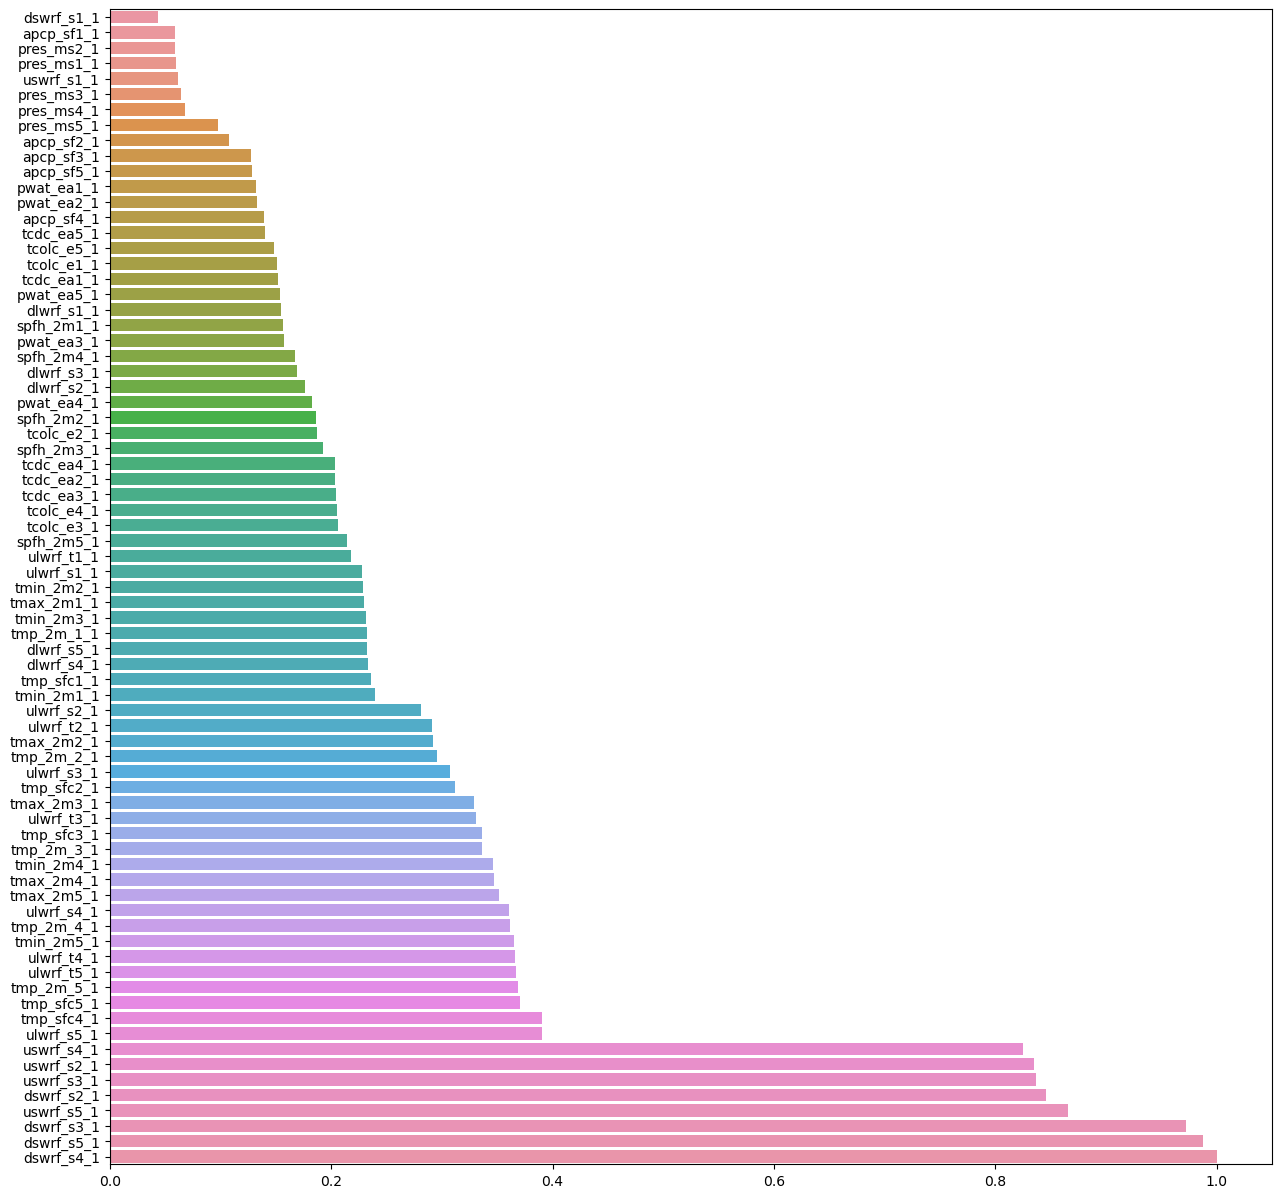

In [15]:
mi = mutual_info_regression(entrada, salida)
mi /= np.max(mi)

dep_vars = ['salida'] # Variable dependiente
indep_vars = disp_df.columns.difference(dep_vars).tolist() # Variables independientes

from sklearn.feature_selection import mutual_info_regression as mi_reg

df_mi = pd.DataFrame([mi_reg(disp_df[indep_vars], disp_df[dep_var]) for dep_var in dep_vars], index = dep_vars, columns = indep_vars).apply(lambda x: x / x.max(), axis = 1)

df_mi = df_mi.T

df_mi = df_mi.sort_values(by='salida')

df_mi = df_mi.T


f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(df_mi, orient = "h")

El valor que hemos obtenido en este código nos indica la fuerza de relación que existe entre las variables dependientes e independientes. Dicho esto, podemos crear asociaciones o relaciones entre las variables y cuales tienen una maypor importancia o peso sobre el modelo. Podemos ver por ejemplo, que las 8 últimas variables son relativamente importantes para el estudio y que el resto menos en consecuencia. Todavía no vamos a atrevernos a eliminar ninguna variable a simple vista; sin embargo, esto nos sirve para tener en cuenta en el futuro cuál son las que nos podría interesar tratar y eliminar.

In [16]:
y_range = max(y_train) - min(y_train)
print(y_range)

31417500


Con el cálculo anterior, podemos observar cuál es el rango en el que se encuentran los valores del conjunto de datos. Esto es importante ya que posteriormente, en el cálculo de valores como RMSE y MAE, los valores que obtengamos tienen que encontrarse entorno a dicho valor. Es por ello, que este apartado nos sirve para saber a que valor de resultados nos estamos enfrentando.

## División del conjunto de entrenamiento

En esta sección, lo que vamos a realizar es la división del conjunto de entrenamiento en entremiento y validación (mencionar que de los 10 años dados del conjunto de entrenamiento, 8 años se emplearan para el conjunto de entrenamiento y 2 para el de validación). Para ello, nos definiremos el código "general" en lo referente a la técnica que se va a utilizar, `Holdout`,  que emplearemos tanto para los métodos básicos como para los métodos avanzados requerido en el enunciado; con el propósito de únicamente modificar ciertos valores en el código para cada una de las técnicas en las que lo implementemos.


Además, debemos mencionar que para los métodos básicos emplearemos la técnica de `Grid Search` mientras que en los avanzados utilizaremos `Randomised Search`.

En lo referente a codigo que vamos a mostrar a continuación:

En cuanto al conjunto de los 8 años, vamos a mantener aquellos valores que tengan valor negativo -1 en el conjunto de entrenamienti debido a que si los eliminasemos, podría no aprender de forma correcta a manejar estos valores; lo que resultaría en resultados menos precisos.

Con respecto al conjunto de 2 años, mantendremos los valores positivos e iguales a cero en el conjunto de validación.



In [17]:
# Conjunto de entrenamiento, 8 años
cto_train = np.full((2920,), -1, dtype = int)

# Conjunto de validación, 2 años
cto_val = np.full((730,), 0, dtype = int)

test_fold = np.append(cto_train, cto_val)
ps = PredefinedSplit(test_fold)

## Dummy Regressor

El Dummy Regressor es un regresor que realiza predicciones utilizando reglas simples. Este regresor es útil como línea de `base` simple para comparar con otros regresores (reales). Es decir, que cualquier regresor debería ser mejor que este regresor base.

Lo importante a destacar de este regresor es que como no le "presta atención" a los datos de entrada, para predecir los valores objetivo sin ninguna influencia de los datos de entrenamiento, utilizamos el parámetro de `strategy` que puede tomar los siguientes valores:

- `mean`: predice siempre la media del conjunto de entrenamiento. Es el que se pone por defecto.

- `median`: predice siempre la mediana del conjunto de entrenamiento.

- `quantile`: predice siempre un cuantil especificado del conjunto de entrenamiento, proporcionado con el parámetro cuantil.

- `constant`: predice siempre un valor constante proporcionado por el usuario.

Este regresor es el que utilizaremos como base para comparar si los resultados son mejores o peores que la los regresores que crearemos a continuación.

In [18]:
# Definimos el modelo
Dummy_regr = DummyRegressor()

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_dummy = Pipeline([("escalado", scaler), ("Dummy_regr", Dummy_regr)])

# Entrenamiento del modelo
t_previo_dummy = time.time()
pipe_regr_dummy.fit(X_train, y_train)
t_final_dummy = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_dummy - t_previo_dummy ," segundos")

El tiempo de entrenamiento del modelo es de :  0.008864641189575195  segundos


#### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [19]:
# Valores predichos
predicciones_dummy = pipe_regr_dummy.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_dummy)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_dummy)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 7781279.3408785835
El error (MAE) de test es: 6659112.970568588
El error (R²) de test es: -0.0009910528620997727


Como se puede observar tienen unos errores muy grandes para el caso de `RMSE` y `MAE` y muy bajo en el caso de `R²`. Por lo tanto, como se esperaba el regresor base tiene un desempeño muy malo y no costará con el resto de técnicas superar sus resultados. A continuación, se va a exponer una respresentación visual de los valores predichos y los valores reales para ver en este caso la pobre capacidad de predicción del regresor.

In [20]:
# Rendimiento
rendimiento_dummy = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_dummy,
                            'Error': y_test - predicciones_dummy})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_dummy 

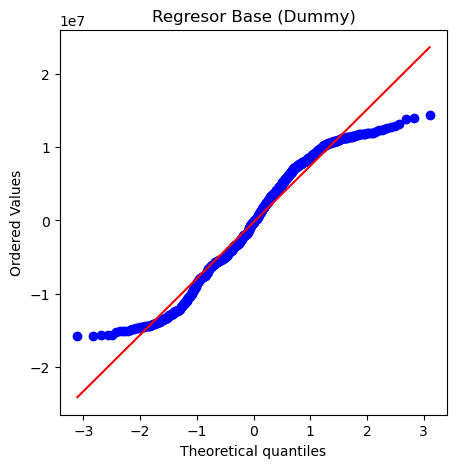

In [21]:
plt.figure(figsize=(5,5))

# Representación
ax_x_dummy = rendimiento_dummy['True Value']
ax_y_dummy = rendimiento_dummy['Prediction']
yerr_dummy = rendimiento_dummy['Error']
probplot(yerr_dummy, dist='norm', plot=plt)
plt.title('Regresor Base (Dummy)')

# Visualizar el gráfico
plt.show()

## Métodos Básicos

A continuación, procederemos a desarrollar cada uno de los métodos básicos siendo los mismos `arbol de decision` (donde tartaremos especificamente con arboles de regresion); `KNN` y `regresion lineal`. Además, las métricas que emplearemos `RMSE`, `MAE` y `R²`. 



### Árboles de Decisión

La primera técnica que se nos propone emplear para crear un modelo capaz de predecir la variable dependiente `salida`, es la utilización del `árbol de decisión`. Si bien se sabe que esta técnica tiene mejores resultados con problemas de clasificación ya que es inadecuada para problemas de regresión en los que hay que predecir valores continuos, y además son difíciles de interpretar si son muy grandes (cosa que sucede en este caso al tratar con 75 atributos), es importante que aun así lo probemos para ver su eficiencia frente a otros modelos y si resulta algo bueno también se puede ver la posibilidad discretizando el problema para poder emplear la técnica de manera más eficiente. Para ello cogeremos el algoritmo de `CART` que además de ser el más empleando con librerías como la que utilizamos (SciKit-Learn), nos permite tratar con atributo numéricos, categóricos, valores perdidos y datos atípicos.

In [22]:
# Definimos el modelo
T_rgr = DecisionTreeRegressor()

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr = Pipeline([("escalado", scaler), ("Tree_regr", T_rgr)])

# Entrenamiento del modelo
t_previo_arb = time.time()
pipe_regr.fit(X_train, y_train)
t_final_arb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_arb - t_previo_arb ," segundos")

El tiempo de entrenamiento del modelo es de :  0.42035341262817383  segundos


#### Visualización del árbol

Una vez que hemos entrenado el árbol, sería ideal representarlo para poder tener una imagen visual del modelo. Sin embargo, esto no lo vamos a representar debido a que al tratar con un conjunto de datos muy grande, como se ha mencionado anteriormente, los árboles grandes son difíciles de interpretar. No obstante, si hubiese que representarlo, se podría hacer de las siguientes maneras:

- `plot_tree()` --> dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo.
- `export_text()` --> representa lo mismo, pero en formato texto.

Lo anteriormente mencionado, se puede justificar con el número de nodos terminales y la profundidad del árbol.

In [23]:
print(f"Profundidad del árbol: {T_rgr.get_depth()}")
print(f"Número de nodos terminales: {T_rgr.get_n_leaves()}")

Profundidad del árbol: 32
Número de nodos terminales: 3648


In [24]:
# La representación se haría de la siguiente manera
# ----------------------------------------------------------------

"""
Representación formato texto
texto_modelo = export_text(decision_tree = T_rgr)
print(texto_modelo)

Representación formato cajas
plot_modelo = plot_tree(decision_tree = T_rgr)
"""

'\nRepresentación formato texto\ntexto_modelo = export_text(decision_tree = T_rgr)\nprint(texto_modelo)\n\nRepresentación formato cajas\nplot_modelo = plot_tree(decision_tree = T_rgr)\n'

#### Importancia de predictores

A continuación vamos a ver la importancia de los predictores para realizar la predicción. Esto nos va a permitir entender mejor el problema que estemos resolviendo. Como sabemos esto se calcula como la reducción total (normalizada) en el criterio de división, en este caso el `mse`. Si un predictor no ha sido seleccionado en ninguna divisón, su importancia será 0 y por tanto, no necesitariamos este atributo.

In [25]:
for name, importance in zip(disp_df.drop(columns = "salida").columns, T_rgr.feature_importances_):
    print(name + ': ' + str(importance))


apcp_sf1_1: 0.00429842353266668
apcp_sf2_1: 0.00612873641703375
apcp_sf3_1: 0.004849623351855061
apcp_sf4_1: 0.0018819787466735044
apcp_sf5_1: 0.01360307163851001
dlwrf_s1_1: 0.003129072772744178
dlwrf_s2_1: 0.0005334735640100044
dlwrf_s3_1: 0.0006324653760399146
dlwrf_s4_1: 0.0012184610983346285
dlwrf_s5_1: 0.003636953832204878
dswrf_s1_1: 0.001063640994776625
dswrf_s2_1: 0.004553655731743229
dswrf_s3_1: 0.022612534706167666
dswrf_s4_1: 0.5968798333446922
dswrf_s5_1: 0.12753653711782076
pres_ms1_1: 0.004111883633487302
pres_ms2_1: 0.0017203506027273893
pres_ms3_1: 0.00043823213327148466
pres_ms4_1: 0.004781009716612623
pres_ms5_1: 0.001469863720381865
pwat_ea1_1: 0.001094037995613733
pwat_ea2_1: 0.004953568687435345
pwat_ea3_1: 0.002024862823231321
pwat_ea4_1: 0.003193510979960105
pwat_ea5_1: 0.005493128405306914
spfh_2m1_1: 0.003072359922261046
spfh_2m2_1: 0.000918571083494065
spfh_2m3_1: 0.0012970918561377414
spfh_2m4_1: 0.00173817980158053
spfh_2m5_1: 0.005200466643261716
tcdc_ea1_

Como se puede observar no hay ningun atributo que no tenga nada de importancia (0). Por ello, no podemos descartar ningun atributo. Aun así, esto nos permite hacernos una idea de que predictores tienen más importancia en el modelo.

#### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [26]:
# Valores predichos
predicciones_arb = pipe_regr.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_arb)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_arb)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 4612959.280495206
El error (MAE) de test es: 3186067.397260274
El error (R²) de test es: 0.6482068125906122


#### Ajuste de hiperparámetros

En el caso de árboles de decisión, hay muchos hiperparámetros a tener en cuenta. Sin embargo, se pueden destacar dos en concreto que son los más importantes:

- `max_depth`: indica la profundidad máxima que puede alcanzar el árbol.
- `min_samples_split`: indica el número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
- `min_samples_leaf`; indica el número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.

Este ajuste lo realizamos para poder tener un árbol de decisión sencillo y optimizado pero que a la vez sea lo más preciso posible.

In [27]:
# Definimos el espacio de búsqueda
param_grid = {'max_depth': list(range(2,16,2)),
              'min_samples_split': list(range(2,16,2)),
              'min_samples_leaf': list(range(2,16,2))}

# Búsqueda por validación cruzada
grid_arb = GridSearchCV(DecisionTreeRegressor(), 
        param_grid = param_grid,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = 4, verbose = 1
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_arb_val = time.time()
grid_arb.fit(X_train, y_train)
t_final_arb_val = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_arb_val - t_previo_arb_val ," segundos")


Fitting 1 folds for each of 343 candidates, totalling 343 fits
El tiempo de entrenamiento del modelo es de :  27.26898765563965  segundos


In [28]:
# Definimos el espacio de búsqueda
param_random_arb = {'max_depth': list(range(2,16,2)),
                    'min_samples_split': list(range(2,16,2)),
                    'min_samples_leaf': list(range(2,16,2))}

budget = 100 
# Búsqueda por validación cruzada
random_arb = RandomizedSearchCV(DecisionTreeRegressor(), 
        param_random_arb,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = 4, verbose = 0,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_arb_random = time.time()
random_arb.fit(X_train, y_train)
t_final_arb_random = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_arb_random - t_previo_arb_random ," segundos")

El tiempo de entrenamiento del modelo es de :  7.891922950744629  segundos


Ahora calculamos el rendimiento del regr en la partición de prueba.

In [29]:
# Valores predichos de regr
predicciones_arb_val = grid_arb.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb_val))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_arb_val)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_arb_val)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3542505.1586134066
El error (MAE) de test es: 2471931.626772131
El error (R²) de test es: 0.7925329338122193


In [30]:
# Valores predichos de regr
predicciones_arb_random = random_arb.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb_random))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_arb_random)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_arb_random)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3542505.1586134066
El error (MAE) de test es: 2471931.626772131
El error (R²) de test es: 0.7925329338122193


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [31]:
grid_arb.best_params_, -grid_arb.best_score_

({'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2},
 13128167831341.635)

In [32]:
random_arb.best_params_, -random_arb.best_score_

({'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 6},
 13128167831341.635)

Como se puede observar aunque varía el valor de `min_samples_split`. La búsqueda de parámetros tanto por Grid como por Random, nos da los mismos resultados para los errores.

#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica de árboles de decisión, el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [33]:
# Errores de los modelos
d_arb = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb)), mean_absolute_error(y_test, y_pred = predicciones_arb), r2_score(y_test, y_pred = predicciones_arb)],
     ["Modelo optimizado Grid", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb_val)), mean_absolute_error(y_test, y_pred = predicciones_arb_val), r2_score(y_test, y_pred = predicciones_arb_val)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_arb = pd.DataFrame(d_arb, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_arb)

                   Modelo          RMSE           MAE        R²
0      Modelo por defecto  4.612959e+06  3.186067e+06  0.648207
1  Modelo optimizado Grid  3.542505e+06  2.471932e+06  0.792533
2            Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


Teniendo lo anterior en cuenta, podemos sacar distintas conclusiones de la tabla previamente creada. Como sabemos de clase, tanto el error cuadrático medio (`RMSE`) como el error cuadrático medio (`MAE`) es mejor cuanto más próximo a cero se encuentren sus valores. Podemos observar que el RMSE disminuye en aproximadamente un 21% mientras que el MAE ha disminuido justo en un 22%. Esto nos indica de momento que vamos bien encaminados. 
Con respecto al coeficiente de determinación `R²` el concepto es diferentes, el valor es mejor cuanto más próximo a 1. Se puede observar que seguimos en consonancia con la mejora de los valores puesto hemos aumentado de 0.64 a 0.78.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo optimizado (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [34]:
# Rendimiento
rendimiento_arb = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_arb,
                            'Error': y_test - predicciones_arb})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_arb 

In [35]:
# Rendimiento
rendimiento_arb_val = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_arb_val,
                            'Error': y_test - predicciones_arb_val})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_arb_val

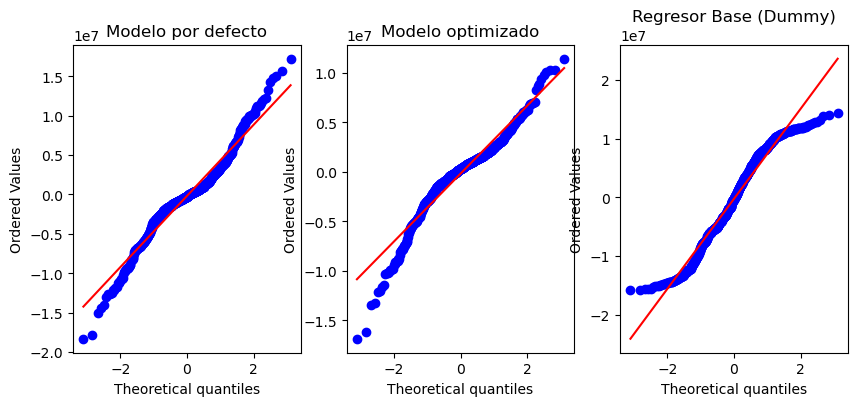

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_arb = rendimiento_arb['True Value']
ax_y_arb = rendimiento_arb['Prediction']
yerr_arb = rendimiento_arb['Error']

# QQ Plot
probplot(yerr_arb, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_arb_val = rendimiento_arb_val['True Value']
ax_y_arb_val = rendimiento_arb_val['Prediction']
yerr_arb_val = rendimiento_arb_val['Error']

# QQ Plot
probplot(yerr_arb_val, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot Dummy
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

### KNN

Como sabemos de clase, KNN es un algoritmo de aprendizaje automático que es reconocido principalmente por ser simple e intuitivo, donde existen fronteras de decisión flexibles y no existen asunciones sobre la distribución de los datos, es decir es una técnica no paramétrica. Es por ello, que vamos a emplear esta tecnica para cumplimentar el estudio de los datos proporcionados. El concepto de esta técnica es determinar la posicion de una instancia con respecto a la relación con los atributos de otras instancias.


Neighbors-based regression se puede utilizar en casos donde las etiquetas de datos son continuas en lugar de variables discretas. La etiqueta asignada a un punto de consulta se calcula en base a la media de las etiquetas de sus vecinos más cercanos.



In [37]:
# Para dibujar las predicciones y los valores reales
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'b.', label='Verdaderas')
  plt.plot(x, pred[:n], 'g^', label='Predichas')
  plt.legend();

El tiempo de entrenamiento del modelo es de :  0.018345117568969727  segundos


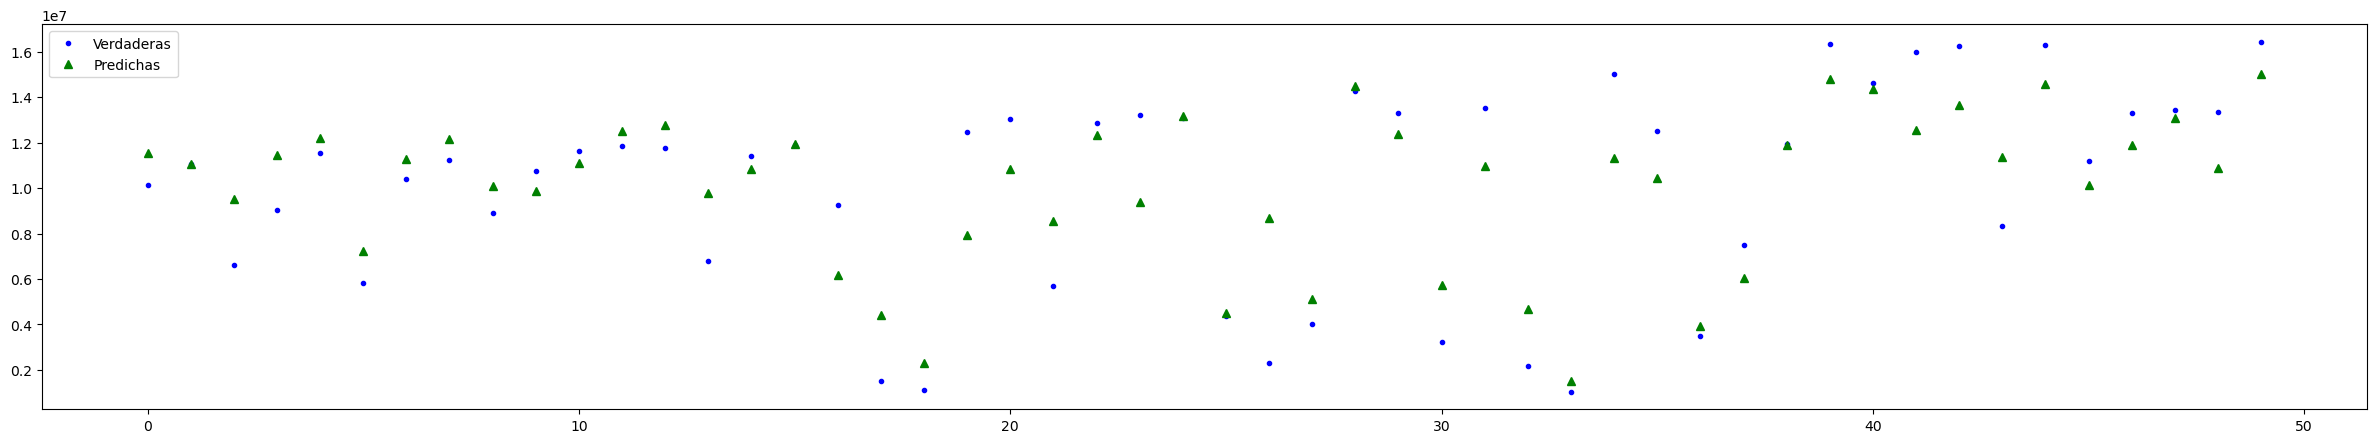

In [38]:
# Definimos el modelo con pesos por distancia
KNN_rgr = KNeighborsRegressor(n_neighbors = 5,weights = 'distance', metric='cityblock')

# Definimos el modelos con pesos uniformes
#KNN_rgr = KNeighborsRegressor(weights = 'uniform')

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

KNN_regr_scaled = Pipeline([("escalado", scaler), ("KNN_regr", KNN_rgr)])
#KNN_regr_scaled = Pipeline([("escalado", scaler), ("KNN_regr_dist", KNN_rgr_dist)])

# Entrenamiento del modelo con pesos por distancia
t_previo_knn = time.time()
KNN_regr_scaled.fit(X_train, y_train)
t_final_knn = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_knn - t_previo_knn ," segundos")

# Entrenamiento del modelo con pesos uniformes
#KNN_rgr.fit(X_train, y_train)

pintaResultados(KNN_regr_scaled,50)

Al hacer pruebas con ambos modelos:

1. Uno tenía en cuenta los pesos influenciados por la `distancia` de los vecinos, donde los vecinos más cercanos tendrán una mayor influencia que los vecinos más alejados.
2. Los pesos eran `uniformes` para todos los vecinos.

Hemos podido observar que con los pesos influenciados por la ditancia, el modelo tiene un mejor desempeño.

Teniendo en cuenta que la distancia por defecto es la de `minkowski`, hemos querido comprobar también el modelo aplicando la distancia `euclídea` y la distancia de `Manhattan`. Con respecto a la distancia euclídea, podemos determinar que los resultados obtenidos han sido poco significativos con respecto a la distancia dada por defecto. Es con la distancia de `Manhattan` con la que hemos podido observar una mejora en el resultado del `R²` en un 2%; por ello, de las tres distancias, la mejor es la de `Manhattan` (en sklearn denominada como `cityblock`).

#### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [39]:
# Predicciones
predicciones_KNN = KNN_regr_scaled.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_KNN))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_KNN)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_KNN)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3348634.460753486
El error (MAE) de test es: 2389653.888376988
El error (R²) de test es: 0.814619662971088


#### Ajuste de hiperparámetros

En el caso de KNN, hay muchos hiperparámetros a tener en cuenta. Sin embargo, se puede destacar uno en concreto que es el más importante es `k` que indica el número de vecinos.

- Si k es muy `pequeña`, el modelo sobre-aprende y el sensible al ruido, teniendo una frontera de decisión ruidosa.

- Si k es muy `grande`, se pierde la idea de localidad y la frontera de decisión es muy grande.

Queremos buscar por tanto un k que considere suficientes vecinos y el ruido pierda influencia.

Este ajuste lo realizamos para poder tener un árbol de decisión sencillo y optimizado pero que a la vez sea lo más preciso 
posible.

In [40]:
# Definimos el espacio de búsqueda
param_grid_knn = {'n_neighbors': list(range(1,21,1))}

# Búsqueda por validación cruzada
grid_knn = GridSearchCV(KNeighborsRegressor(weights = 'distance', metric='cityblock'), 
        param_grid_knn,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = 1, verbose = 1
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_knn_val = time.time()
grid_knn.fit(X_train, y_train)
t_final_knn_val = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_knn_val - t_previo_knn_val ," segundos")

Fitting 1 folds for each of 20 candidates, totalling 20 fits
El tiempo de entrenamiento del modelo es de :  4.7925333976745605  segundos


In [41]:
# Definimos el espacio de búsqueda
param_random_knn = {'n_neighbors': list(range(1,21,1))}

budget = 100 
# Búsqueda por validación cruzada
random_knn = RandomizedSearchCV(KNeighborsRegressor(weights='distance', metric= 'cityblock'), 
        param_random_knn,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = 4, verbose = 0,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_knn_random = time.time()
random_knn.fit(X_train, y_train)
t_final_knn_random = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_knn_random - t_previo_knn_random ," segundos")

El tiempo de entrenamiento del modelo es de :  2.4595351219177246  segundos


Ahora calculamos el rendimiento del regr en la partición de prueba.

In [42]:
# Valores predichos de regr
predicciones_knn_val = grid_knn.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_knn_val))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_knn_val)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_knn_val)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3553190.82054308
El error (MAE) de test es: 2512155.492345085
El error (R²) de test es: 0.7912794330210985


In [43]:
# Valores predichos de regr
predicciones_knn_random = random_knn.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_knn_random))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_knn_random)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_knn_random)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3553190.82054308
El error (MAE) de test es: 2512155.492345085
El error (R²) de test es: 0.7912794330210985


También lo hemos visualizado de forma gráfica para poder tener una idea general de como evoluciona el MSE con los diferentes valores de k para tner una idea general.

Text(0.5, 1.0, 'ELBOW PLOT')

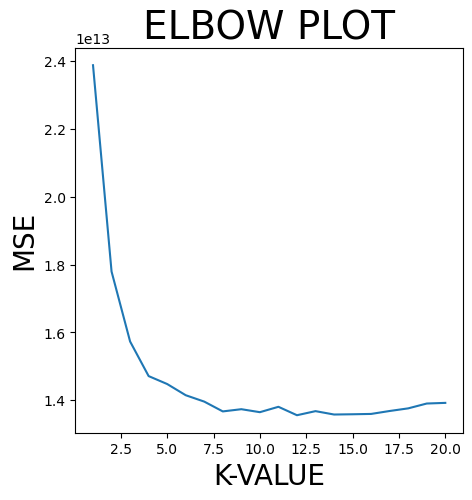

In [44]:
fig,ax=plt.subplots(figsize=(5,5))
k_list=np.arange(1,21,1)
knn_dict={} # Para guardar la K y el mse
for i in k_list:
# Creacion del modelo
    knn_prueba=KNeighborsRegressor(n_neighbors=int(i))
    model_knn=knn_prueba.fit(X_train,y_train)
    y_knn_pred=model_knn.predict(X_test)
# Guardar MSE 
    mse=mean_squared_error(y_test,y_knn_pred)
    knn_dict[i]=mse
# Mostrar resultados
ax.plot(knn_dict.keys(),knn_dict.values())
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('MSE' ,fontsize=20)
ax.set_title('ELBOW PLOT' ,fontsize=28)

Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [45]:
grid_knn.best_params_, -grid_knn.best_score_

({'n_neighbors': 13}, 12930806810418.598)

In [46]:
random_knn.best_params_, -random_knn.best_score_

({'n_neighbors': 13}, 12930806810418.598)

Como se puede observar, la búsqueda de parámetros tanto por Grid como por Random, nos da los mismos resultados para los errores.

#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica KNN (K-nearest neighbprs), el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [47]:
# Errores de los modelos
d_knn = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_KNN)), mean_absolute_error(y_test, y_pred = predicciones_KNN), r2_score(y_test, y_pred = predicciones_KNN)],
     ["Modelo optimizado", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_knn_val)), mean_absolute_error(y_test, y_pred = predicciones_knn_val), r2_score(y_test, y_pred = predicciones_knn_val)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_knn = pd.DataFrame(d_knn, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_knn)

               Modelo          RMSE           MAE        R²
0  Modelo por defecto  3.348634e+06  2.389654e+06  0.814620
1   Modelo optimizado  3.553191e+06  2.512155e+06  0.791279
2        Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


Las conclusiones que podemos obtener son bastante sencillas. En primer lugar, podemos observar que tanto el `RMSE` y el `MAE` aumenta en el modelo optimizado con respecto al modelo de defecto. Esto es malo ya que como sabemos, el `RMSE` y el `MAE` son mejores conforme obtenemos valores más pequeños; y en este caso no se da la situación. En el caso de `R²` también podemos observar un empeoramiento al emplear el modelo optimizado, puesto que lo que deseamos con el `R²` es obtener valores más próximos a 1. Por tanto a modo de resumen, el modelo optimizado tiene peores resultados en comparación con el modelo de defecto; por ello no es recomendable emplear el modelo optimizado.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo por defecto (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era menor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [48]:
# Rendimiento
rendimiento_KNN = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_KNN,
                            'Error': y_test - predicciones_KNN})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_KNN

# Rendimiento
rendimiento_KNN_val = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_knn_val,
                            'Error': y_test - predicciones_knn_val})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
#rendimiento_KNN_val

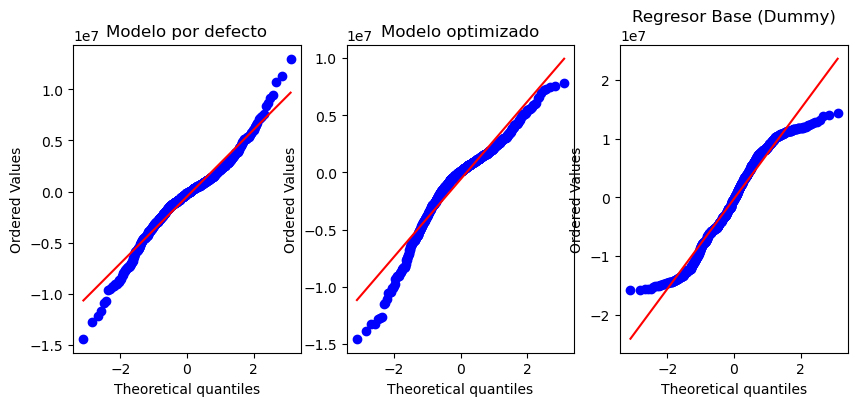

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_arb = rendimiento_KNN['True Value']
ax_y_arb = rendimiento_KNN['Prediction']
yerr_arb = rendimiento_KNN['Error']

# QQ Plot
probplot(yerr_arb, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_arb_val = rendimiento_KNN_val['True Value']
ax_y_arb_val = rendimiento_KNN_val['Prediction']
yerr_arb_val = rendimiento_KNN_val['Error']

# QQ Plot
probplot(yerr_arb_val, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

También se puede ver de otra forma visual:

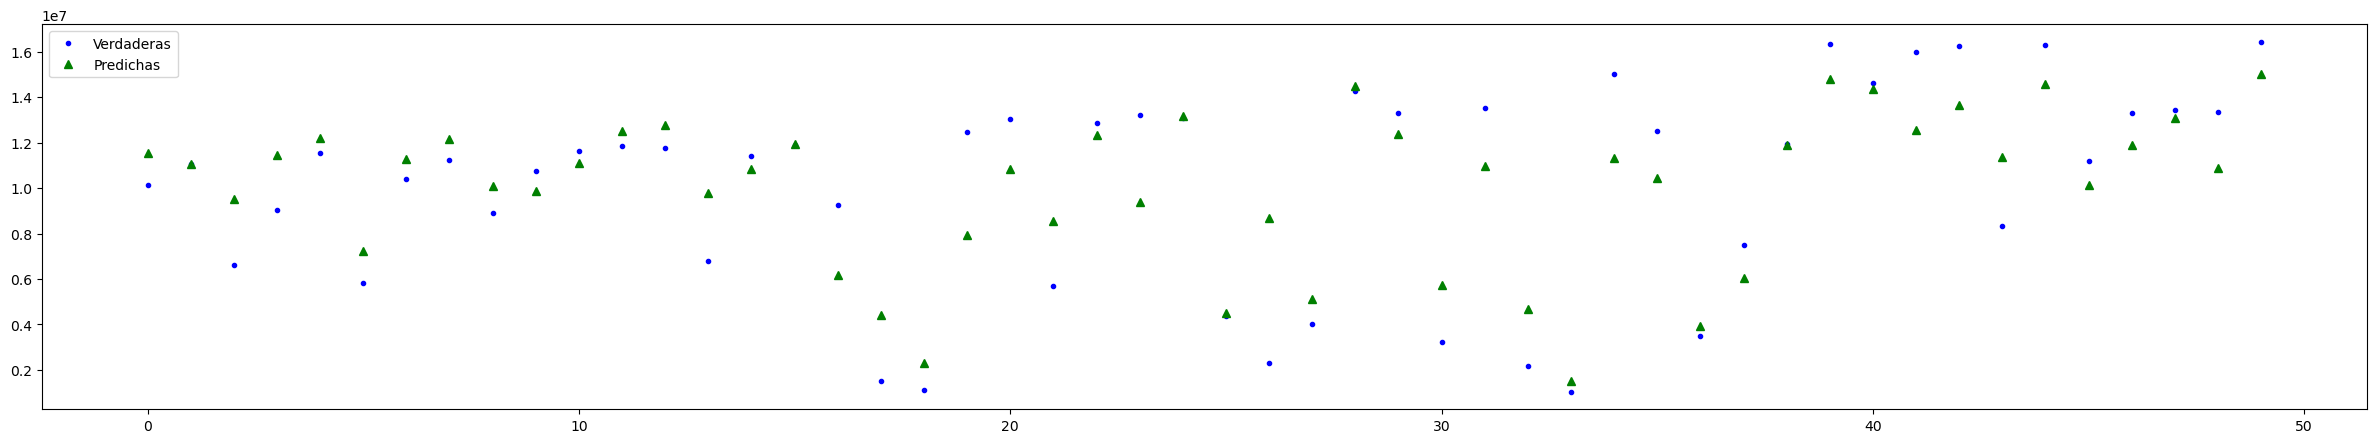

In [50]:
pintaResultados(KNN_regr_scaled,50)

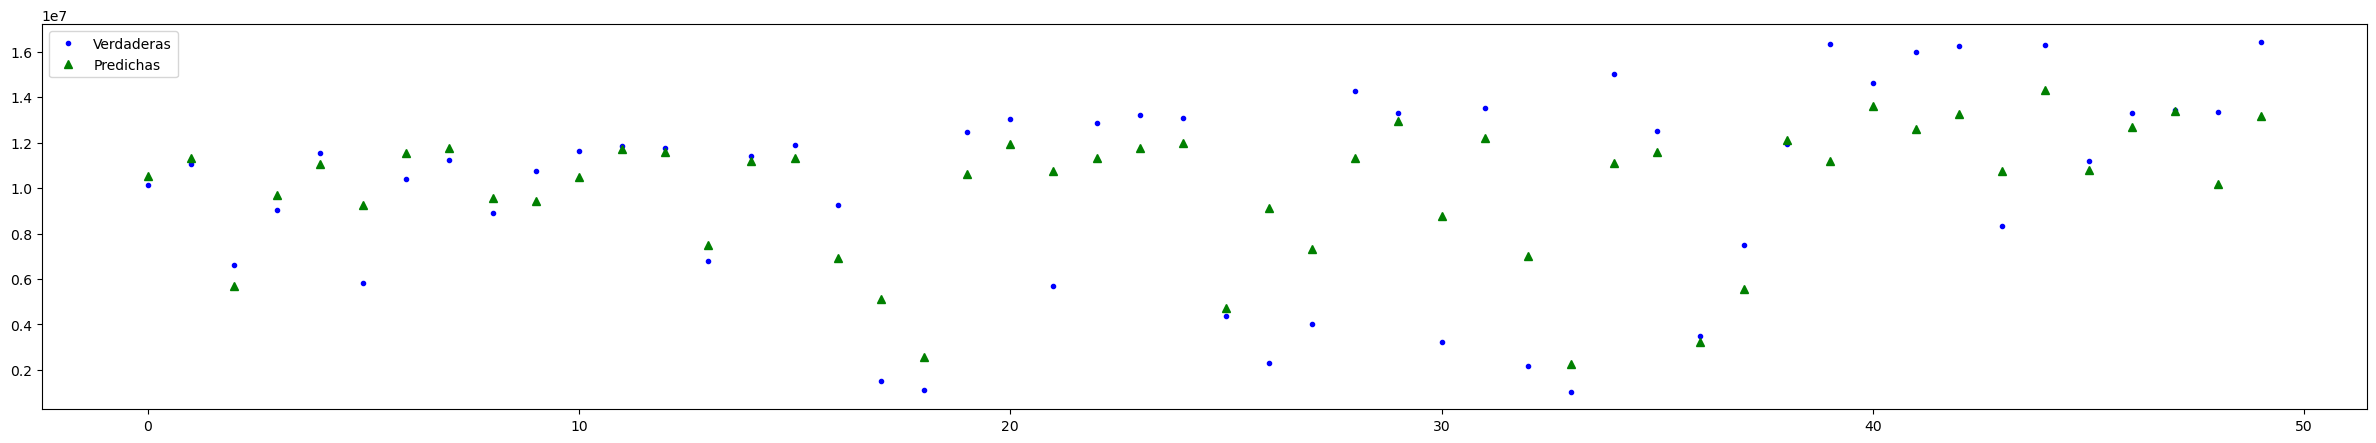

In [51]:
pintaResultados(grid_knn,50)

### Regresión Lineal

En este apartado, realizaremos un ajuste lineal de la regresion debido a dos factores en particular. El primero de ellos, es que se modela principalmente para conjuntos de datos numéricos que es precisamente lo que estamos tratando. El segundo factor es porque se obtienen las estimaciones de relaciones entre atributos y predicción; que sera bastante útil para comparar cada uno de los atributos de la muestra y su importancia en el modelo.

Comenzaremos creando un modelo lineal aproximado por `mínimos cuadrados` y luego continuaremos con distintas regularizaciones (Lasso, Ridge y Elastic Net) para ajustar automáticamente la complejidad del modelo y evitar así el sobre-aprendizaje. Las regularizaciones se van a aplicar principalmente al error cuadrático.

In [52]:
# Creamos el objeto StandarScaler para poder normalizar
scaler = StandardScaler()
reg_lin = LinearRegression()

pipe_regr = Pipeline([
    ('scale', scaler),
    ('REGL', reg_lin)])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

# Entrenamos el modelo
t_previo_regr = time.time()
pipe_regr.fit(X=X_train, y=y_train)
t_final_regr = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr - t_previo_regr ," segundos")


# Predicciones sin regularización
predicciones_rgr = pipe_regr.predict(X_test)

El tiempo de entrenamiento del modelo es de :  0.03963208198547363  segundos


#### Evaluación de errores del modelo sin regularización

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [53]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2939681.7587425527
El error (MAE) de test es: 2109530.6402197164
El error (R²) de test es: 0.8571340221933389


#### Regularización de Ridge

La regularización de `Ridge`(l2), añade un término para penalizar la complejidad del modelo. Este término es la suma de los coeficientes al cuadrado. Esto equivaldría a :


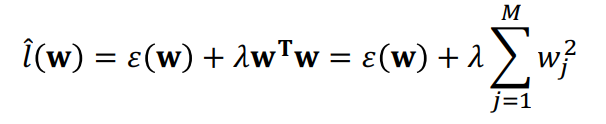

In [54]:
regrRidge = RidgeCV(
            alphas          = np.logspace(-3, 8, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

np.random.seed(12)

t_previo_regr_r = time.time()
_ = regrRidge.fit(X = X_train, y = y_train)
t_final_regr_r = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_r - t_previo_regr_r ," segundos")

predicciones_rgr_ridge = regrRidge.predict(X_test)

El tiempo de entrenamiento del modelo es de :  0.9045960903167725  segundos


In [55]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_ridge)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2938107.371070354
El error (MAE) de test es: 2104058.792624109
El error (R²) de test es: 0.8572870089595548


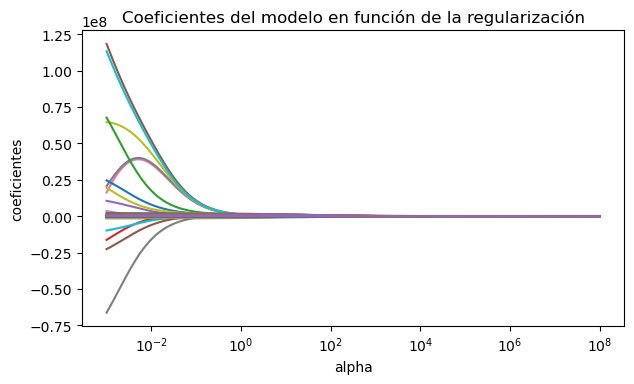

In [56]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = regrRidge.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Como se puede observar, a medida que aumenta el valor de alpha, la regularización es mayor y el valor de los coeficientes se reduce, aunque sin llegar a cero ya que ridge incluye a todos los predictores. Ademá como vemos al ser un modelo con una gran cantidad de parámetros es menos interpretable.

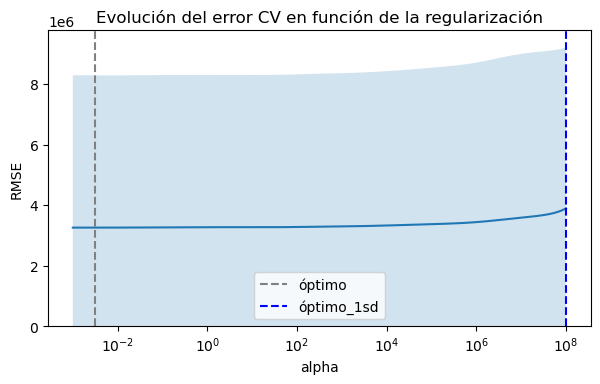

In [57]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = regrRidge.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = regrRidge.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = regrRidge.alphas[np.argmin(rmse_cv)]
optimo_1sd   = regrRidge.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(regrRidge.alphas, rmse_cv)
ax.fill_between(
    regrRidge.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [58]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {regrRidge.alpha_}")

Mejor valor de alpha encontrado: 0.0031440354715915


#### Regularización de Lasso

La regularización de `Lasso`(l1), añade un término para penalizar la complejidad del modelo. Este término es la suma del valor absoluto de los coeficientes. Esto equivaldría a :

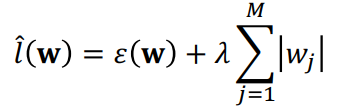

In [59]:
regrLasso = LassoCV(
            alphas          = np.logspace(-9, 3, 200),
            cv              = 10
         )

t_previo_regr_l = time.time()
np.random.seed(12)
_ = regrLasso.fit(X_train, y_train)
t_final_regr_l = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_l - t_previo_regr_l ," segundos")

predicciones_rgr_lasso = regrLasso.predict(X_test)

El tiempo de entrenamiento del modelo es de :  16.525879621505737  segundos


In [60]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_lasso))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_lasso)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_lasso)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2957269.142393508
El error (MAE) de test es: 2121736.4569321666
El error (R²) de test es: 0.8554194454363465


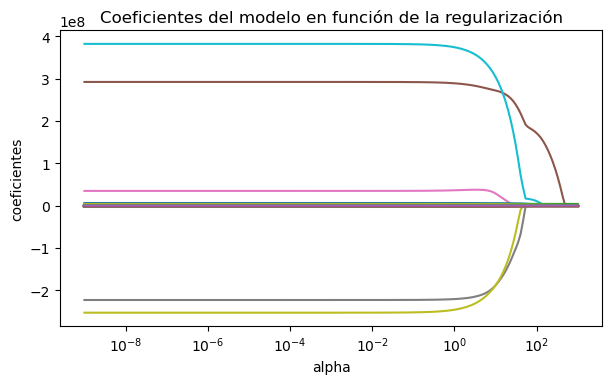

In [61]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = regrLasso.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-1,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Puede ver se como, a diferencia de Ridge, a medida que aumenta el valor de alpha, la regularización es mayor y más predictores quedan excluidos ya que puede hacer que los coeficientes lleguen a 0. Sin embargo el modelo es inestable si hay fuertes correlaciones.

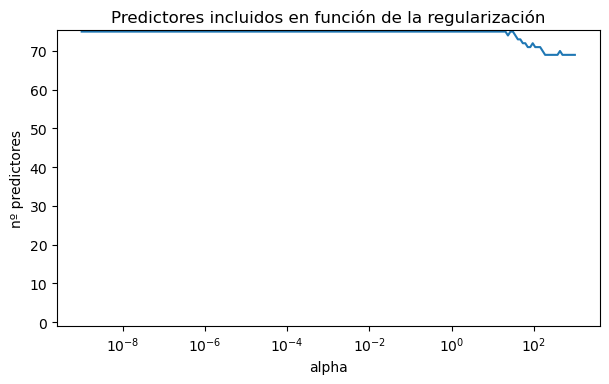

In [62]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = regrLasso.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-1,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

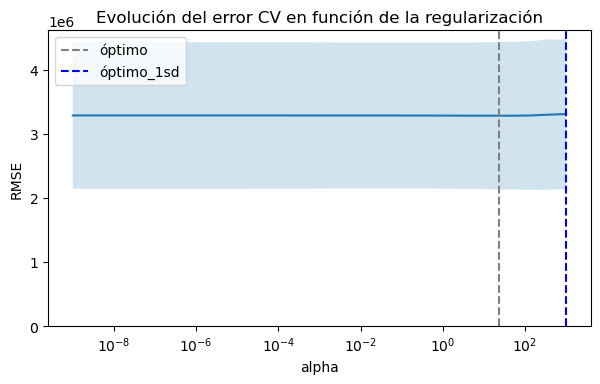

In [63]:
# Evolución del error en función de alpha
# ==============================================================================
# regrLasso.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = regrLasso.mse_path_.mean(axis=1)
mse_sd = regrLasso.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = regrLasso.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = regrLasso.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(regrLasso.alphas_, rmse_cv)
ax.fill_between(
    regrLasso.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();


In [64]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {regrLasso.alpha_}")

Mejor valor de alpha encontrado: 23.542864143224104


#### Elastic Net 

Como sabemos, Lasso nos permite descartar predictores ya que puede hacer que los coeficientes lleguen a 0 pero, el modelo es inestable si hay fuertes correlaciones. Por otro lado, Ridge reduce la influencia proporcionalmente de los predictores a la vez si hay correlación entre ellos (el modelo es estable), pero coge todos los predictores, no los puede reducir.

Para superar las limitaciones de ambas regularizaciones, `Elastic Net` es una combinación de las mismas en una proporción "α" (Si α = 0, solo es Ridge; si α = 1, solo es Lasso). Luego la regularización quedaría:

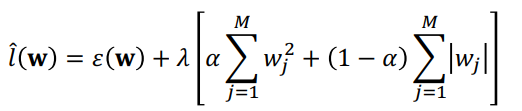

In [65]:
regrElastic = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )

t_previo_regr_e = time.time()
np.random.seed(12)
_ = regrElastic.fit(X_train, y_train)
t_final_regr_e = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_e - t_previo_regr_e ," segundos")

predicciones_rgr_elastic = regrElastic.predict(X_test)

El tiempo de entrenamiento del modelo es de :  97.02751684188843  segundos


In [66]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_elastic))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_elastic)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_elastic)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2959660.0798456697
El error (MAE) de test es: 2119466.2330972236
El error (R²) de test es: 0.8551855656049


In [67]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# regrElastic.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = regrElastic.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [regrElastic.l1_ratio, regrElastic.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv.head()

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
537,0.50,1.122668e-06,1.076457e+13,3.280940e+06
1311,0.99,5.607170e-05,1.076457e+13,3.280940e+06
341,0.10,6.150986e-07,1.076457e+13,3.280940e+06
926,0.90,5.872787e-06,1.076457e+13,3.280940e+06
1122,0.95,1.071891e-05,1.076457e+13,3.280941e+06


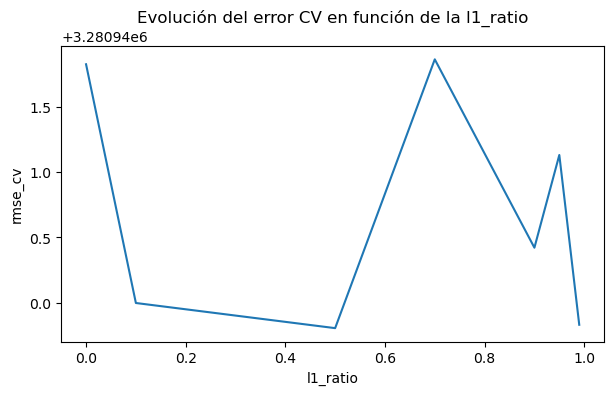

In [68]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [69]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {regrElastic.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {regrElastic.l1_ratio_}")

Mejor valor de alpha encontrado: 1.1226677735108135e-06
Mejor valor de l1_ratio encontrado: 0.5


#### Comparación de las regularizaciones

Procederemos a comparar el modelo con las distintas regularizaciones implementadas a partir del RMSE

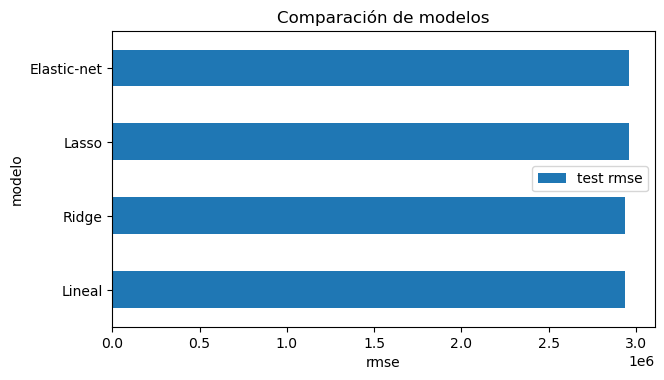

In [70]:
rmse_lineal = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr))
rmse_ridge = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_lasso))
rmse_elastic = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_elastic))
df_comparacion = pd.DataFrame({
                    'modelo': ['Lineal', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_lineal, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

In [71]:
# Coeficientes de los distintos modelos
# ==============================================================================
d = [["Lineal", np.count_nonzero(np.abs(reg_lin.coef_.flatten()) > 0.5), np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr)), mean_absolute_error(y_test, y_pred = predicciones_rgr), r2_score(y_test, y_pred = predicciones_rgr)],
     ["Ridge", np.count_nonzero(np.abs(regrRidge.coef_.flatten()) > 0.5), np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge), r2_score(y_test, y_pred = predicciones_rgr_ridge)],
     ["Lasso", np.count_nonzero(np.abs(regrLasso.coef_.flatten()) > 0.5), np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_lasso)), mean_absolute_error(y_test, y_pred = predicciones_rgr_lasso), r2_score(y_test, y_pred = predicciones_rgr_lasso)],
     ["Elastic Net", np.count_nonzero(np.abs(regrElastic.coef_.flatten()) > 0.5), np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_elastic)), mean_absolute_error(y_test, y_pred = predicciones_rgr_elastic), r2_score(y_test, y_pred = predicciones_rgr_elastic)],
     ["Modelo Dummy", 75 ,np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df = pd.DataFrame(d, columns = ['Modelo','Núm. predictores', 'RMSE', 'MAE', 'R²'])
print(df)

         Modelo  Núm. predictores          RMSE           MAE        R²
0        Lineal                75  2.939682e+06  2.109531e+06  0.857134
1         Ridge                75  2.938107e+06  2.104059e+06  0.857287
2         Lasso                71  2.957269e+06  2.121736e+06  0.855419
3   Elastic Net                75  2.959660e+06  2.119466e+06  0.855186
4  Modelo Dummy                75  7.781279e+06  6.659113e+06 -0.000991


Las conclusiones que podemos obtener son las siguientes. Todos los valores obtenidos son bastante similares tanto para `RMSE` y `MAE` como para 
`R²`; encontrándose todos ellos en torno a los 2,9 millones de `RMSE`, 2,11 millones de `MAE` y 0,85 de `R²`. De entre todos ellos, si lo observamos en mayor profundidad, podemos detallar que Ridge es ligeramente mejor que los 3 modelos restantes. Por ello, concluimos que el mejor modelo de regulariazación es `Ridge`.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de los modelos, la recta del modelo optimizado lineal (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado radial. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [72]:
# Rendimiento
rendimiento_lineal = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_rgr,
                            'Error': y_test - predicciones_rgr})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_lineal 

# Rendimiento
rendimiento_ridge = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_rgr_ridge,
                            'Error': y_test - predicciones_rgr_ridge})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_ridge

# Rendimiento
rendimiento_lasso = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_rgr_lasso,
                            'Error': y_test - predicciones_rgr_lasso})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_lasso

# Rendimiento
rendimiento_elastic = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_rgr_elastic,
                            'Error': y_test - predicciones_rgr_elastic})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_elastic

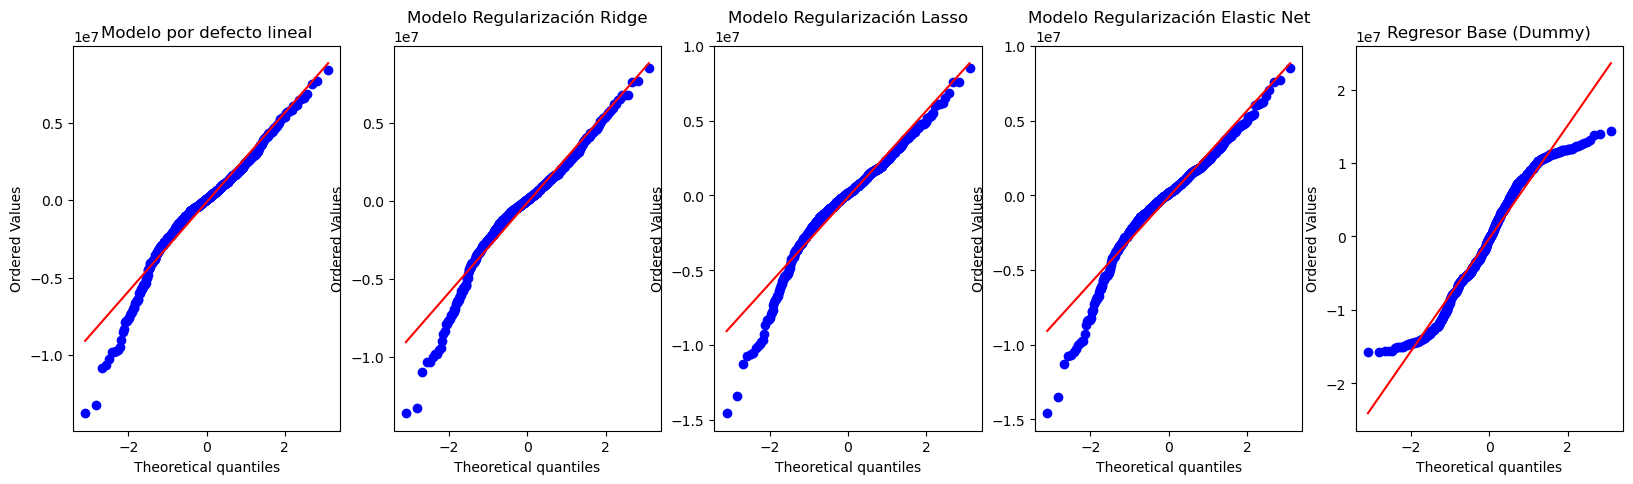

In [73]:
# Crear 4 subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Plot 1 - Modelo por defecto lineal
ax_x_lineal = rendimiento_lineal['True Value']
ax_y_lineal = rendimiento_lineal['Prediction']
yerr_lineal = rendimiento_lineal['Error']
probplot(yerr_lineal, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto lineal')

# Plot 2 - Modelo Regularización Ridge
ax_x_ridge = rendimiento_ridge['True Value']
ax_y_ridge = rendimiento_ridge['Prediction']
yerr_ridge = rendimiento_ridge['Error']
probplot(yerr_ridge, dist='norm', plot=axs[1])
axs[1].set_title('Modelo Regularización Ridge')

# Plot 3 - Modelo Regularización Lasso
ax_x_lasso = rendimiento_lasso['True Value']
ax_y_lasso = rendimiento_lasso['Prediction']
yerr_lasso = rendimiento_lasso['Error']
probplot(yerr_lasso, dist='norm', plot=axs[2])
axs[2].set_title('Modelo Regularización Lasso')

# Plot 4 - Modelo Regularización Elastic Net
ax_x_elastic = rendimiento_elastic['True Value']
ax_y_elastic = rendimiento_elastic['Prediction']
yerr_elastic = rendimiento_elastic['Error']
probplot(yerr_elastic, dist='norm', plot=axs[3])
axs[3].set_title('Modelo Regularización Elastic Net')

# Plot 5 - Regresor Dummy
probplot(yerr_dummy, dist='norm', plot=axs[4])
axs[4].set_title('Regresor Base (Dummy)')

# Visualizar gráfica
plt.show()

### Regresión polinómica

Ahora a continuación, vamos a realizar una regresión polinómica sobre el modelo. Como sabemos, una regresión polinomial es una forma de regresión lineal donde se muestra la relacion de las variables independientes "x" y la variable dependiente "y". Todo ello, modelado como un polinomio de grado n, que indica, el número de pendientes y por tanto de variables dependientes que tiene el modelo. Esto se debe a que hay muchas variable independientes y debemos ajustar el peso de dichas variables.


In [74]:
"""
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 

degrees = [2, 3, 4, 5, 6] # Change degree "hyperparameter" here
best_score = 0
best_degree = 0
for degree in degrees:
    poly_features = PolynomialFeatures(degree = degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, y_train)
    scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=3) # Change k-fold cv value here
    if max(scores) > best_score:
      best_score = max(scores)
      best_degree = degree     

print(f"Mejor valor (R2): {best_score}")
print(f"Mejor valor de grado encontrado: {best_degree}")
"""

'\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.model_selection import cross_val_score \n\ndegrees = [2, 3, 4, 5, 6] # Change degree "hyperparameter" here\nbest_score = 0\nbest_degree = 0\nfor degree in degrees:\n    poly_features = PolynomialFeatures(degree = degree, include_bias=False)\n    X_train_poly = poly_features.fit_transform(X_train)\n    polynomial_regressor = LinearRegression()\n    polynomial_regressor.fit(X_train_poly, y_train)\n    scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=3) # Change k-fold cv value here\n    if max(scores) > best_score:\n      best_score = max(scores)\n      best_degree = degree     \n\nprint(f"Mejor valor (R2): {best_score}")\nprint(f"Mejor valor de grado encontrado: {best_degree}")\n'

In [75]:
""""
poly_features = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
best_polynomial_regressor = LinearRegression()
best_polynomial_regressor.fit(X_train_poly, y_train)
X_test_poly = poly_features.fit_transform(X_test)
print(f"RMSE de regresión polinomial: {rmse(y_test, best_polynomial_regressor.predict(X=X_test_poly))}")
plt.subplots(figsize=(30, 5))
x = np.arange(y_test[:50].size)
y_pred = best_polynomial_regressor.predict(X=X_test_poly)
plt.plot(x, y_test[:50], 'b.', x, y_pred[:50], 'g^')
"""

'"\npoly_features = PolynomialFeatures(degree = best_degree, include_bias=False)\nX_train_poly = poly_features.fit_transform(X_train)\nbest_polynomial_regressor = LinearRegression()\nbest_polynomial_regressor.fit(X_train_poly, y_train)\nX_test_poly = poly_features.fit_transform(X_test)\nprint(f"RMSE de regresión polinomial: {rmse(y_test, best_polynomial_regressor.predict(X=X_test_poly))}")\nplt.subplots(figsize=(30, 5))\nx = np.arange(y_test[:50].size)\ny_pred = best_polynomial_regressor.predict(X=X_test_poly)\nplt.plot(x, y_test[:50], \'b.\', x, y_pred[:50], \'g^\')\n'

In [76]:
"""
print(best_polynomial_regressor.coef_)
"""

'\nprint(best_polynomial_regressor.coef_)\n'

Debido al elevado tiempo de cómputo y a la complejidad del modelo, hemos dejado comentado el código para que se pueda ver su implementación. Sin embargo,  el resultado obtenido es que el mejor rango del polinomio es 0; lo que implica que nuetsra "recta de regresion" no tiene pendiente,es constante, por tanto seria mejor emplear tecnicas de rgresion lineal como hemos mencionado previamente.

### Conclusiones de Métodos Básicos

- ¿Cuál es el mejor método?

Para determinar el mejor metodo básico, hemos escogido el mejor modelo de cada una de las diferentes técnicas básicas siendo estas el modelo `optimizado de Árboles de decisión`, modelo por `defecto de KNN` y el modelo `Ridge` de Regresión Lineal. De entre estos tres modelos, podemos observar que el que posee un mejor valor es el modelo Ridge de Regresión Lineal. En el podemos detacar unos valores de `RMSE` y `MAE` bastante reducidos con respecto a los otros dos siendo estas de `27%` y `15%` respectivamente, en los casos más extremos (con mayor diferencia), es decir al Árbol de Decisión que es la técnica con peor desempeño. En cuanto al error `R²` es mejor el error de Ridge en un `8%` y `5%` con respecto a los valores de Árbol de decisión y KNN respectivamente. Los resultados que hemos obtenido, tienen sentido puesto que en las representaciones gráficas, los datos conforman una forma similar a la de una recta, es por ello, que el `Ridge` tiene sentido pues es una regresión lineal.

In [77]:
# Errores de los mejores modelos de cada método
# ==============================================================================
d_final = [["Árbol de Decisión", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb_val)), mean_absolute_error(y_test, y_pred = predicciones_arb_val), r2_score(y_test, y_pred = predicciones_arb_val)],
          ["KNN", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_KNN)), mean_absolute_error(y_test, y_pred = predicciones_KNN), r2_score(y_test, y_pred = predicciones_KNN)],
          ["Regresión Lineal (Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge), r2_score(y_test, y_pred = predicciones_rgr_ridge)],
          ["Modelo Dummy",np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_final = pd.DataFrame(d_final, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_final)

                     Modelo          RMSE           MAE        R²
0         Árbol de Decisión  3.542505e+06  2.471932e+06  0.792533
1                       KNN  3.348634e+06  2.389654e+06  0.814620
2  Regresión Lineal (Ridge)  2.938107e+06  2.104059e+06  0.857287
3              Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


- ¿Cuál de los métodos básicos de aprendizaje automático es más rápido?

Se puede observar a simple vista que `KNN` es el método que es más rápido, seguido de `Ridge` y `Árbol de decisión` en último lugar. En términos de proporciones matemáticas, podemos decir que KNN es `482` veces más rápido que el mejor modelo de árbol de decisión y `38` veces más rápido que Ridge. Como ya sabemos, que sea más rápido no implica que sea el mejor, hay más factores a tener en cuenta como los errores. Sin embargo, para responder a la pregunta planteada, el método más rápido es el modelo de `KNN`.

-->  `NOTA`: puede ser que las proporciones matemáticas no coincidan estrictamente ya que los valores del tiempo de cada modelo varían en cada ejecución que se de. No obstante, los resultados siguen teniendo las mismas interpretaciones.

In [78]:
# Tiempo de los mejores modelos de cada método
# ==============================================================================
d_final_t = [["Árbol de decisión", t_final_arb_random - t_previo_arb_random],
     ["KNN", t_final_knn - t_previo_knn],
     ["Regresión Lineal (Ridge)", t_final_regr_r - t_previo_regr_r],
     ["Modelo Dummy", t_final_dummy - t_previo_dummy]]

df_final_t = pd.DataFrame(d_final_t, columns = ['Modelo', 'Tiempo'])
print(df_final_t)

                     Modelo    Tiempo
0         Árbol de decisión  7.891923
1                       KNN  0.018345
2  Regresión Lineal (Ridge)  0.904596
3              Modelo Dummy  0.008865


- ¿Los resultados son mejores que los regresores triviales/naive/baseline?

El modelo `Dummy` tiene como objetivo representar el modelo más simple, que debería ser superarado cualquier regresor. Si observamos de nuevo los valores de la tabla, podemos determinar que los valores del modelo Dummy son los peores en cualquier sentido con respecto a los modelos básicos seleccionados (cosa que ya esperabámos ya que los resultados del regresor base son pésimos). Las diferencias más significativas que podemos encontrar del regresor Dummy con respecto a los mejores valores, es decir, los de Ridge, son: 
1. Un empeoramiento del `265%` en RMSE.
2. Un empeoramiento del `316%` en MAE. 
3. Un empeoramiento del `857%` en R². 

Por todo ello, los resultados obtenidos son mejores que los del regresor trivial para cualquier regresor que hemos creado (Árboles, KNN y Regresión Lineal).

In [79]:
# Errores de los mejores modelos de cada método
# ==============================================================================
print(df_final)

                     Modelo          RMSE           MAE        R²
0         Árbol de Decisión  3.542505e+06  2.471932e+06  0.792533
1                       KNN  3.348634e+06  2.389654e+06  0.814620
2  Regresión Lineal (Ridge)  2.938107e+06  2.104059e+06  0.857287
3              Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


- ¿El ajuste de hiperparámetros mejora con respecto a los valores por omisión?


Para esta pregunta, vamos a clasificarla en aquellos modelos donde si que ha habido mejora con el ajuste de hiperparámetros y el que no ha habido mejora en el ajuste de hiperparámetros:

1. `Mejora`: Los dos modelos donde se produce mejora es en el de `árbol de decisión` y en el de `regresión lineal` con regularización Ridge. En el primero, podemos observar cambios bastante significativos tanto en el `RMSE`, `MAE` y `R²`, adquiriendo una mejora del `23%`, `22%` y `23%` respectivamente. Con respecto a Ridge, se pueden detallar cambios menos significativos (casi idénticos), produciendo mejora del modelo optimizado del `0.05%` , `0.26%` y `0.0001%` en `RMSE`, `MAE` y `R²` respectivamente.

2. `No mejora`: en el caso de KNN, el modelo optimizado empeora con respecto al modelo por defecto produciendo una variación de los valores en un `6.3%`, `5.4%` y `2.5%` en `RMSE`, `MAE` y `R²` respectivamente. (Cabe mencionar que esto sucede a pesar de haber probado varios espacios de búsqueda, parámtrso valores y número de iteraciones, y no conseguimos que aumente)

Por todo ello, como hemos demostrado y como se puede ver en la tabla, hay dos modelos que mejoran con el ajuste de hiperparámetros (Árbol de decisión y Regresión lineal (Ridge)); y modelos que empeoran con el ajuste de hiperparámetros siendo este KNN.

In [80]:
# Errores de modelos de cada método
# ==============================================================================
d_final = [["Árbol de decisión (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb)), mean_absolute_error(y_test, y_pred = predicciones_arb), r2_score(y_test, y_pred = predicciones_arb)],
          ["Árbol de decisión (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_arb_val)), mean_absolute_error(y_test, y_pred = predicciones_arb_val), r2_score(y_test, y_pred = predicciones_arb_val)],
          ["KNN (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_KNN)), mean_absolute_error(y_test, y_pred = predicciones_KNN), r2_score(y_test, y_pred = predicciones_KNN)],
          ["KNN (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_knn_val)), mean_absolute_error(y_test, y_pred = predicciones_knn_val), r2_score(y_test, y_pred = predicciones_knn_val)],
          ["Regresión Lineal (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr)), mean_absolute_error(y_test, y_pred = predicciones_rgr), r2_score(y_test, y_pred = predicciones_rgr)],
          ["Regresión Lineal (Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge), r2_score(y_test, y_pred = predicciones_rgr_ridge)],]

df_final = pd.DataFrame(d_final, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_final)

                           Modelo          RMSE           MAE        R²
0     Árbol de decisión (Defecto)  4.612959e+06  3.186067e+06  0.648207
1  Árbol de decisión (Optimizado)  3.542505e+06  2.471932e+06  0.792533
2                   KNN (Defecto)  3.348634e+06  2.389654e+06  0.814620
3                KNN (Optimizado)  3.553191e+06  2.512155e+06  0.791279
4      Regresión Lineal (Defecto)  2.939682e+06  2.109531e+06  0.857134
5        Regresión Lineal (Ridge)  2.938107e+06  2.104059e+06  0.857287


- ¿Hay algún equilibrio entre tiempo de ejecución y mejora de resultados?

Como hemos comentado previamente, en nuestro conjunto de datos no existe ningún equilibrio; es decir, un menor tiempo de ejecución no implica un mejor valor de los resultados. Un ejemplo de ello, es el caso comentado previamente en el modelo KNN donde teniendo el tiempo de ejecución más bajo, no se produce el mejor valor de los resultados. De hecho, el mejor resultado ha sido producido por el modelo que genera el segundo mejor tiempo (Ridge).

## ¿Es posible reducir la dimensionalidad del problema?

Para empezar, es importante mencionar que existen diversas técnicas para reducir la dimensionalidad de los datos y que cada una tiene un objetivo y proceso diferentes pero todas llegan al mismo objetivo, reducir la dimensionalidad del problema. Dicho esto, nos hemos querido centrar principalmente en 5 técnicas que consideramos que son las más adecuadas a realizar. Cabe mencionar que dichas técnicas se dividen a su vez en dos subgrupos, "mejor para conjunto de datos pequeño" y "mejor para conjunto de datos grande". Estas son respectivamente:

- `Low Variance Filter (filtro de baja varianza)`: Aplicamos este enfoque para identificar y eliminar las variables constantes del conjunto de datos. La variable objetivo no se ve afectada indebidamente por variables con baja varianza, por lo que estas variables pueden eliminarse con seguridad.
- `Backward Feature Elimination`: Calcula el rendimiento del modelo con las "n" variables de los datos. A continuación, se calcula el rendimiento del modelo tras eliminar cada variable (n veces), es decir, eliminamos una variable cada vez y entrenamos el modelo con las n-1 variables restantes.
Identificamos la variable cuya eliminación ha producido el menor (o ningún) cambio en el rendimiento del modelo, y la eliminamos. Se repite este proceso hasta que no se pueda eliminar ninguna variable. (Este método puede ser usado para para construir modelos de regresión linear o regresión logística). También existe el `Foward Feature Elimination`, que en lugar de eliminar características, intenta encontrar las mejores características que mejoren el rendimiento del modelo. El problema de ambos es que requieren mucho tiempo de cálculo, por lo que suelen utilizarse en conjuntos de datos pequeños.


- `Principal Component Analysis (PCA)`: Es una de las técnicas más utilizadas para tratar datos lineales. Divide los datos en un conjunto de componentes que intentan explicar la mayor varianza posible.
- `Independent Component Analysis (ICA)`: Podemos utilizar ICA para transformar los datos en componentes independientes que describan los datos utilizando un menor número de componentes.
Estas dos última técnicas están basadas en componentes/factores. La siguiente que voy a tratar es la más avanzada de todas y esta basada en proyecciones.
- `UMAP (Unifor Manifold Approximation and Projection)`: partiendo de las base de que la técnica `t-SNE` es uno de los pocos algoritmos capaces de conservar al mismo tiempo la estructura local y global de los datos. El procedimiento de esta es calcular la similitud probabilística de puntos en un espacio de alta dimensión y en un espacio de baja dimensión para minimizar la diferencia entre ambas probabilidades. El problema de t-SNE es que funciona muy bien en grandes conjuntos de datos, pero también tiene sus limitaciones, como la pérdida de información a gran escala, la lentitud de los cálculos y la incapacidad para representar de forma significativa conjuntos de datos muy grandes. `UMAP` po otro lado, es una técnica de reducción de dimensiones que puede preservar gran parte de la estructura de datos local y más de la global en comparación con t-SNE, con un tiempo de ejecución más corto.


Teniendo en cuenta todo lo anteriormente mencionado, vamos a primero intentar aquellas técnicas que tienen mejores resultados con un conjunto de datos pequeño (`Backward Feature Elimination` y `Low Variance Filter`). Si el tiempo de cálculo tras realizar las pruebas es excesivamente alto procederemos a aplicar la técnicas que tienen mejores resultados en conjunto de datos grandes (`PCA`, `ICA` y `UMAP`). Conviene subrayar que queremos aplicar varias técnicas para reducir la dimensionalidad con el objetivo de asegurar que efectivamente los aributos que eliminemos no pierdan información y mejoren el modelo.


Tras intentar tanto el `Backward Feature Elimination` y `Low Variance Filter` hemos llegado a la conclusión de que el primero no se puede realizar debido a su alto tiempo de cálculo, y el segundo es difícil de interpretar una lista de 75 varianzas. Dicho esto procederemos a realizar las otras técnicas restantes.

### PCA (Principal Component Analysis)

El mapeo lineal de los datos a un espacio de menor dimensión se realiza de forma que se maximice la varianza de los datos. PCA asume que las características con baja varianza son irrelevantes y las características con alta varianza son informativas. Las características que se conservan son las que tienen una varianza significativa. (Sería como la versión avanzada de Low Variance Filter).

Hemos escogido que el parámetro `n_components` (que indica el número de componente que se quedan), sea 69 ya que en el gráfico de barras del EDA en el que se mostraba la ganancia de información de los atributos se podía observar que el número de atributos que menos información tenían eran 6 de los 75 atributos que hay en total. Es por eso que el número de componentes que queremos conservar intentando perder la mínima información posible es de 69.

In [81]:
X_scaled = StandardScaler().fit_transform(entrada)

pca = PCA(n_components=69)

pca_features = pca.fit_transform(X_scaled)

print('Shape antes de PCA: ', X_scaled.shape)
print('Shape después de PCA: ', pca_features.shape)

Shape antes de PCA:  (4380, 75)
Shape después de PCA:  (4380, 69)


In [82]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Componentes", "y": "Varianza explicada"}
)

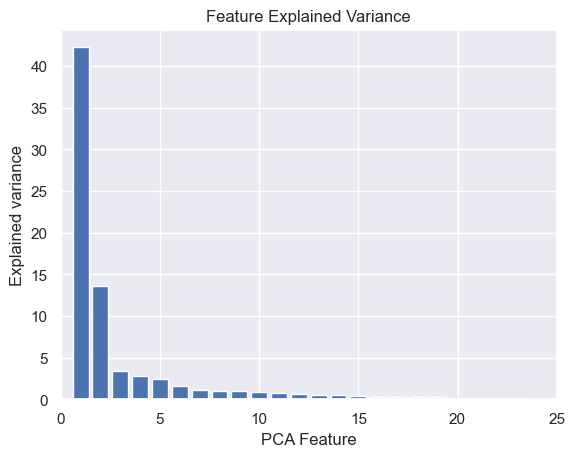

In [83]:
sns.set()
 
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.xlim(0, 25)
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

Creamos el nuevo conjunto de entrenamiento y test en base a los nuevo datos de entrada obtenido con la técnica de PCA.

In [84]:
X_train_pca, X_test_pca = np.array_split(pca_features, [3650]) # 10 años
y_train_pca, y_test_pca = np.array_split(salida, [3650])  # 2 años

print(type(X_train_pca), type(X_test_pca))

#Configuración de las particiones de entrenamiento y de prueba
print(X_train_pca.shape)
print(y_train_pca.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3650, 69)
(3650,)


Creamos un nuevo regresor con la técnica de regresión lineal ya que fue la que tuvo los mejores resultados de los modelos básicos comentados anteriormente.

In [85]:
# Creamos el objeto StandarScaler para poder normalizar
scaler = StandardScaler()
reg_lin_pca = LinearRegression()

pipe_regr_pca = Pipeline([
    ('scale', scaler),
    ('REGL', reg_lin_pca)])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

# Entrenamos el modelo
t_previo_regr_pca = time.time()
pipe_regr_pca.fit(X=X_train_pca, y=y_train_pca)
t_final_regr_pca = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_pca - t_previo_regr_pca ," segundos")


# Predicciones sin regularización
predicciones_rgr_pca = pipe_regr_pca.predict(X_test_pca)

El tiempo de entrenamiento del modelo es de :  0.031092166900634766  segundos


Visualizamos los errores del regresor

In [86]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_pca))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_pca)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_pca)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2927920.270333638
El error (MAE) de test es: 2103980.92829262
El error (R²) de test es: 0.8582749314871644


Aplicamos la regularización de Ridge (ya que fue la mejor de la regresión lineal como se comento en apartados anteriores)

In [87]:
regrRidge_pca = RidgeCV(
            alphas          = np.logspace(-3, 8, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

np.random.seed(12)

t_previo_regr_r_pca = time.time()
_pca = regrRidge_pca.fit(X = X_train_pca, y = y_train_pca)
t_final_regr_r_pca = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_r_pca - t_previo_regr_r_pca ," segundos")

predicciones_rgr_ridge_pca = regrRidge_pca.predict(X_test_pca)

El tiempo de entrenamiento del modelo es de :  1.5441088676452637  segundos


Visualizamos los errores del regresor

In [88]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge_pca))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge_pca)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_ridge_pca)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2931896.4905129517
El error (MAE) de test es: 2104833.305119548
El error (R²) de test es: 0.8578897347111296


Ahora vamos a realizar una comparación entre los modelos por defecto y con Ridge tras aplicar la técnica de PCA, con respecto al mejor modelo básico comentado anteriormente, Ridge (sin aplicar PCA).

In [89]:
# Comparación errores
# ==============================================================================
d_pca = [["Regresión Lineal", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_pca)), mean_absolute_error(y_test, y_pred = predicciones_rgr_pca), r2_score(y_test, y_pred = predicciones_rgr_pca)],
         ["Regresión Lineal (Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge_pca)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge_pca), r2_score(y_test, y_pred = predicciones_rgr_ridge_pca)],
         ["Regresión Lineal (Sin PCA Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge), r2_score(y_test, y_pred = predicciones_rgr_ridge)]]


df_pca = pd.DataFrame(d_pca, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_pca)

                             Modelo          RMSE           MAE        R²
0                  Regresión Lineal  2.927920e+06  2.103981e+06  0.858275
1          Regresión Lineal (Ridge)  2.931896e+06  2.104833e+06  0.857890
2  Regresión Lineal (Sin PCA Ridge)  2.938107e+06  2.104059e+06  0.857287


Como se puede observar el modelo que tiene un mejor rendimiento tras aplicar PCA es la `Regresión Lineal por defecto`. Como se puede observar este mejora en un `0.10%` con respecto al modelo de regresión lineal con regularización de Ridge sin aplicar PCA. A su vez, los valores de `RMSE` y `MAE` sobre la misma comparativa se han vsto reducidos aunque también no de forma significativa. Con esto podemos llegar a la conclusión de que aunque haya habido una mejora en el resultado de los errores tras aplicar la técnica de PCA, esta no es significativa e igual nos incita a pensar que la pérdida de información resultante al reducir el número de predictores no vale la pena la ganancia de rendimiento del modelo.

### ICA (Independent Component Analysis)

Al igual que en PCA, hemos decidido que el parámetro `n_components` sea 69.

In [90]:
ica = FastICA(n_components=69)

ica_features = ica.fit_transform(X_scaled)

print('Shape antes de ICA: ', X_scaled.shape)
print('Shape después de ICA: ', ica_features.shape)

Shape antes de ICA:  (4380, 75)
Shape después de ICA:  (4380, 69)


Creamos el nuevo conjunto de entrenamiento y test en base a los nuevo datos de entrada obtenido con la técnica de ICA.

In [91]:
X_train_ica, X_test_ica = np.array_split(ica_features, [3650]) # 10 años
y_train_ica, y_test_ica = np.array_split(salida, [3650])  # 2 años

print(type(X_train_ica), type(X_test_ica))

#Configuración de las particiones de entrenamiento y de prueba
print(X_train_ica.shape)
print(y_train_ica.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3650, 69)
(3650,)


Creamos un nuevo regresor con la técnica de regresión lineal ya que fue la que tuvo los mejores resultados de los modelos básicos comentados anteriormente.

In [92]:
# Creamos el objeto StandarScaler para poder normalizar
scaler = StandardScaler()
reg_lin_ica = LinearRegression()

pipe_regr_ica = Pipeline([
    ('scale', scaler),
    ('REGL', reg_lin_ica)])

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

# Entrenamos el modelo
t_previo_regr_ica = time.time()
pipe_regr_ica.fit(X=X_train_ica, y=y_train_ica)
t_final_regr_ica = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_ica - t_previo_regr_ica ," segundos")


# Predicciones sin regularización
predicciones_rgr_ica = pipe_regr_ica.predict(X_test_ica)

El tiempo de entrenamiento del modelo es de :  0.03072071075439453  segundos


Visualizamos los errores del regresor

In [93]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ica))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_ica)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_ica)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2927920.2703336356
El error (MAE) de test es: 2103980.9282926195
El error (R²) de test es: 0.8582749314871646


Aplicamos la regularización de Ridge (ya que fue la mejor de la regresión lineal como se comento en apartados anteriores)

In [94]:
regrRidge_ica = RidgeCV(
            alphas          = np.logspace(-3, 8, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

np.random.seed(12)

t_previo_regr_r_ica = time.time()
_pca = regrRidge_ica.fit(X = X_train_ica, y = y_train_ica)
t_final_regr_r_ica = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_regr_r_ica - t_previo_regr_r_ica ," segundos")

predicciones_rgr_ridge_ica = regrRidge_ica.predict(X_test_ica)

El tiempo de entrenamiento del modelo es de :  0.9278039932250977  segundos


Visualizamos los errores del regresor

In [95]:
# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge_ica))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge_ica)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rgr_ridge_ica)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2925565.0502108242
El error (MAE) de test es: 2103279.2029590746
El error (R²) de test es: 0.8585028471751355


Ahora vamos a realizar una comparación entre los modelos por defecto y con Ridge tras aplicar la técnica de PCA, con respecto al mejor modelo básico comentado anteriormente, Ridge (sin aplicar ICA).

In [96]:
# Comparación errores
# ==============================================================================
d_ica = [["Regresión Lineal", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ica)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ica), r2_score(y_test, y_pred = predicciones_rgr_ica)],
         ["Regresión Lineal (Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge_ica)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge_ica), r2_score(y_test, y_pred = predicciones_rgr_ridge_ica)],
         ["Regresión Lineal (Sin ICA Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge), r2_score(y_test, y_pred = predicciones_rgr_ridge)]]


df_ica = pd.DataFrame(d_ica, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_ica)

                             Modelo          RMSE           MAE        R²
0                  Regresión Lineal  2.927920e+06  2.103981e+06  0.858275
1          Regresión Lineal (Ridge)  2.925565e+06  2.103279e+06  0.858503
2  Regresión Lineal (Sin ICA Ridge)  2.938107e+06  2.104059e+06  0.857287


Como se puede observar el modelo que tiene un mejor rendimiento tras aplicar PCA es la `Regresión Lineal por defecto`. Como se puede observar este mejora en un `0.13%` con respecto al modelo de regresión lineal con regularización de Ridge sin aplicar ICA. A su vez, los valores de `RMSE` y `MAE` sobre la misma comparativa se han vsto reducidos aunque también no de forma significativa. Con esto podemos llegar a la conclusión de que aunque haya habido una mejora en el resultado de los errores tras aplicar la técnica de ICA, esta no es significativa e igual nos incita a pensar que la pérdida de información resultante al reducir el número de predictores no vale la pena la ganancia de rendimiento del modelo.

Cabe mencionar que la técnica descrita anteriormente, `UMAP`, no podemos aplicarla ya se orienta a la reducción de dimensionalidad `no-lineal`. Teniendo en cuenta que el mejor modelo es el de Regresión Lineal (Ridge), entendemos que esto se debe a que los datos siguen una distribución cuasi-lineal y por eso es el regresor que mejor se adapta a los datos, ergo la técnica de `UMAP` no tiene mucho sentido aplicarla.

## Métodos Avanzados

A continuación, procederemos a desarrollar cada uno de los métodos avanzados siendo los mismos `SVM` y `Random Forest`. Además, las métricas que emplearemos `RMSE`, `MAE` y `R²`. 

### SVM (Máquinas de Soporte Vectorial)

Es un algoritmo de tipo supervisado que se puede utilizar tanto para clasificación como para regresión, mayoritariamente para el primero. El objetivo del mismo es determinar cual es el hiperplano que proporciona un mayor margen entre los llamados vectores de soporte. En el caso de ser el problema tratado no linealmente separable, se permiten que distintos puntos se encuentren mal clasificados solucionándose por medio del parámetro de regularización C que tiene como objetivo controlar el sobre-aprendizaje del modelo controlando el peso de cada objetivo.

Si dejamos a un lado los problemas no lineales, se suele emplear el truco del kernel (Kernel Trick). Este truco permite calcular el producto escalar de vectores de otro espacio con vectores de un espacio diferente. Entre las funciones del kernel (K) más conocidas encontramos la polinomial, sigmoidal y radial o Gaussiana, siendo la radial la más empleada.

Por tanto, para el problema planteado, deberemos normalizar los atributos, y posteriormente ajustar los hiper parámetros seleccionado el parámetro C y la función de Kernel (K) correspondiente siendo estos Lineal y Radial.

#### SVM Lineal

Empezaremos asumiendo que el problema es `lineal`, y por tanto utilizando un kernel lineal con el hiperparámetro `C` por defecto y luego haciendo validación cruzada para encontrar el modelo con kernel lineal optimizado.

In [97]:
# Definimos el modelo
svm_rgr = SVR(kernel = 'linear')

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_svm = Pipeline([("escalado", scaler), ("SVM_regr", svm_rgr)])

# Entrenamiento del modelo
t_previo_svm = time.time()
pipe_regr_svm.fit(X_train, y_train)
t_final_svm = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_svm - t_previo_svm ," segundos")

El tiempo de entrenamiento del modelo es de :  1.3090145587921143  segundos


##### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [98]:
# Valores predichos
predicciones_svm = pipe_regr_svm.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_svm)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_svm)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 7709831.654881118
El error (MAE) de test es: 6591693.174304125
El error (R²) de test es: 0.017306748823371576


Se repite el ajuste del modelo, esta vez utilizando validación cruzada para identificar el valor óptimo de penalización `C`. La función de este hiperparámetro es la de controlar el sobre-aprendizaje permitiendo el balanceo entre el error de entrenamiento y la complejidad del modelo. Además, la interpretación de C se puede orientar de dos formas distintas: 
- C con `valor grande`:  las variables de holgura tienden a cero pues el parámetro se encarga de que los datos de entrenamiento se clasifiquen correctamente. Además, se puede dar sobre-aprendizaje en el caso de que haya ruido.
- C con `valor pequeño`: en este caso hay demasiados datos de entrenamiento mal clasificados; es decir, muchas variables de holgura con valores altos. 

In [99]:
# Definimos el espacio de búsqueda
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000, 10000]}

budget = 100
# Búsqueda por validación cruzada
grid_svm = RandomizedSearchCV(SVR(kernel = 'linear'), 
        param_grid_svm,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = 4, verbose = 0,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_svm_val = time.time()
grid_svm.fit(X_train, y_train)
t_final_svm_val = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_svm_val - t_previo_svm_val ," segundos")

El tiempo de entrenamiento del modelo es de :  64.9656434059143  segundos


Ahora calculamos el rendimiento del regr en la partición de prueba.

In [100]:
# Valores predichos de regr
predicciones_svm_val = grid_svm.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_val))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_svm_val)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_svm_val)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3122590.071745907
El error (MAE) de test es: 2211471.318660426
El error (R²) de test es: 0.8388025631352554


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [101]:
grid_svm.best_params_, -grid_svm.best_score_

({'C': 100}, 11681877691752.28)

#### SVM Radial

Ahora asumiremos que el problema no es lineal y por tanto utilizaremos un kernel `radial` (rbf), ya que es el más utilizado en problemas no lineares. Para ello, evaluaremos el modelo con hiperparámetros por defecyo y luego el modelo con los hiperparámetro `C` y `ɣ` (gamma) óptimos, mediante validación cruzada.

En cuanto a gamma, representa el grado de curvatura que queremos en la frontera de decisión o lo que es lo mismo, la influencia de un único ejemplo de entrenamiento en el modelo. Esto implica que una gamma alta sea equivalente a una mayor curvatura y viceversa en caso contrario:
- `Gamma pequeña`: implica modelos con menor precisión que no nos interesa.
- `Gamma grande`: al igual que gamma pequeña, implica modelos con menor precisión que tampoco nos interesan.
- `Gamma “intermedia”`: este es el valor que nos va a interesar, que se encuentra entre medias de gammas pequeñas y grandes. Esta gamma intermedia la obtendremos por medio de la validación cruzada puesto que no existe un valor de gamma “buena” predefinido, esta es diferente en función del problema.

In [102]:
# Definimos el modelo
svm_rgr_rad = SVR(kernel = 'rbf')

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_svm_rad = Pipeline([("escalado", scaler), ("SVM_regr", svm_rgr_rad)])

# Entrenamiento del modelo
t_previo_svm_rad = time.time()
pipe_regr_svm_rad.fit(X_train, y_train)
t_final_svm_rad = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_svm_rad - t_previo_svm_rad ," segundos")

El tiempo de entrenamiento del modelo es de :  1.5393707752227783  segundos


##### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [103]:
# Valores predichos
predicciones_svm_rad = pipe_regr_svm_rad.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_rad))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_svm_rad)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_svm_rad)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 7779299.247151301
El error (MAE) de test es: 6657965.854282111
El error (R²) de test es: -0.0004816754622700703


Se repite el ajuste del modelo, esta vez utilizando validación cruzada para identificar el valor óptimo de penalización `C` y gamma `ɣ`.

In [104]:
# Definimos el espacio de búsqueda
param_grid_svm_rad = {'C': [0.1, 1, 10, 100, 1000, 10000, 50000, 100000, 140000, 141000, 143500, 143600, 143700, 143800, 143900, 143910, 143920, 143930, 143940, 143950, 150000],
                      'gamma': [0.000000000001,0.00000000001, 0.0000000001, 0.000000001, 0.00000001, 0.0000001, 0.000001]}

budget = 100 
# Búsqueda por validación cruzada
grid_svm_rad = RandomizedSearchCV(SVR(kernel = 'rbf'), 
        param_grid_svm_rad,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = 4, verbose = 0,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_svm_val_rad = time.time()
grid_svm_rad.fit(X_train, y_train)
t_final_svm_val_rad = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_svm_val_rad - t_previo_svm_val_rad ," segundos")

El tiempo de entrenamiento del modelo es de :  70.94985580444336  segundos


Ahora calculamos el rendimiento del regr en la partición de prueba.

In [105]:
# Valores predichos de regr
predicciones_svm_val_rad = grid_svm_rad.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_val_rad))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_svm_val_rad)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_svm_val_rad)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3837468.906025397
El error (MAE) de test es: 2719042.4035672424
El error (R²) de test es: 0.7565454352374055


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [106]:
grid_svm_rad.best_params_, -grid_svm_rad.best_score_

({'gamma': 1e-06, 'C': 150000}, 17560536110735.693)

#### Comparación de modelos

A continuación, vamos a comparar los 4 modelos hechos de la técnica de SVM (Support Vector Machine), el `modelo con los hiperparámetros por defecto lineal`, el `modelo con los mejores hiperparámetros lineal`, el `modelo con los hiperparámetros por defecto radial` y el `modelo con los mejores hiperparámetros radial`. Para ello, vamos a examinar los errores de los modelos para comprobar cual es mejor si radial o lineal, y efectivamente comprobar la mejoría del modelo optimizado frente al modelo por defecto.

In [107]:
# Errores de los modelos
d_arb = [["Modelo por defecto lineal", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm)), mean_absolute_error(y_test, y_pred = predicciones_svm), r2_score(y_test, y_pred = predicciones_svm)],
     ["Modelo optimizado lineal", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_val)), mean_absolute_error(y_test, y_pred = predicciones_svm_val), r2_score(y_test, y_pred = predicciones_svm_val)],
     ["Modelo por defecto radial", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_rad)), mean_absolute_error(y_test, y_pred = predicciones_svm_rad), r2_score(y_test, y_pred = predicciones_svm_rad)],
     ["Modelo optimizado radial", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_val_rad)), mean_absolute_error(y_test, y_pred = predicciones_svm_val_rad), r2_score(y_test, y_pred = predicciones_svm_val_rad)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_arb = pd.DataFrame(d_arb, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_arb)

                      Modelo          RMSE           MAE        R²
0  Modelo por defecto lineal  7.709832e+06  6.591693e+06  0.017307
1   Modelo optimizado lineal  3.122590e+06  2.211471e+06  0.838803
2  Modelo por defecto radial  7.779299e+06  6.657966e+06 -0.000482
3   Modelo optimizado radial  3.837469e+06  2.719042e+06  0.756545
4               Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


Lo primero que salta a la vista es que los valores del modelo lineal son mejores tanto en el modelo por defecto y optimizado en comparación con el modelo radial. Esto se debe a que sus valores de RMSE y del MAE son inferiores y su R² es superior. 

Si nos fijamos en las optimizaciones del modelo lineal, tiene una bajada bastante pronunciada tanto en el `RMSE` como en el `MAE` siendo estas del 57% y 65% respectivamente. En cuanto al `R²` nos ha llamado especialmente la atención que se haya aumentado en un 82% siendo la mayor subida de optimización que hemos presentado hasta este momento en el proyecto. Creemos que esto se debe a que los datos de nuestro modelo se encuentran dispuestos de maneral lineal; tal y como hemos observado en algunos gráficos en secciones previas del proyecto. En cuanto al modelo radial, se puede observar un descenso de `RMSE` y `MAE` del 50,4% y 58,9% respectivamente. En este caso, el `R²` ha aumentado en un 75%.
Por todo ello, concluimos que el `modelo lineal optimizado` es mejor que el radial.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de los modelos, la recta del modelo optimizado lineal (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado radial. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [108]:
# Rendimiento
rendimiento_svm = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_svm,
                            'Error': y_test - predicciones_svm})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_svm 

# Rendimiento
rendimiento_svm_val = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_svm_val,
                            'Error': y_test - predicciones_svm_val})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_svm_val
# Rendimiento
rendimiento_svm_rad = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_svm_rad,
                            'Error': y_test - predicciones_svm_rad})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_svm_rad 

# Rendimiento
rendimiento_svm_rad_val = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_svm_val_rad,
                            'Error': y_test - predicciones_svm_val_rad})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_svm_rad_val 

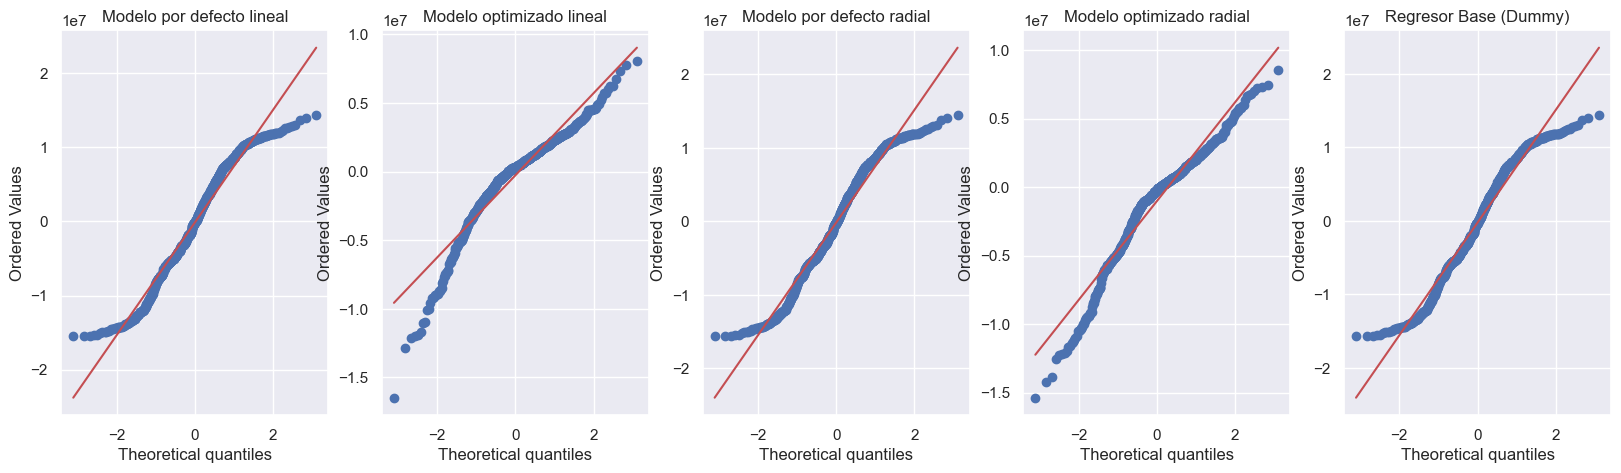

In [109]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Plot 1 - Modelo por defecto lineal
ax_x_svm = rendimiento_svm['True Value']
ax_y_svm = rendimiento_svm['Prediction']
yerr_svm = rendimiento_svm['Error']
probplot(yerr_svm, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto lineal')

# Plot 2 - Modelo optimizado lineal
ax_x_svm_val = rendimiento_svm_val['True Value']
ax_y_svm_val = rendimiento_svm_val['Prediction']
yerr_svm_val = rendimiento_svm_val['Error']
probplot(yerr_svm_val, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado lineal')

# Plot 3 - Modelo por defecto radial
ax_x_svm_rad = rendimiento_svm_rad['True Value']
ax_y_svm_rad = rendimiento_svm_rad['Prediction']
yerr_svm_rad = rendimiento_svm_rad['Error']
probplot(yerr_svm_rad, dist='norm', plot=axs[2])
axs[2].set_title('Modelo por defecto radial')

# Plot 4 - Modelo optimizado radial
ax_x_svm_rad_val = rendimiento_svm_rad_val['True Value']
ax_y_svm_rad_val = rendimiento_svm_rad_val['Prediction']
yerr_svm_rad_val = rendimiento_svm_rad_val['Error']
probplot(yerr_svm_rad_val, dist='norm', plot=axs[3])
axs[3].set_title('Modelo optimizado radial')

# Plot 5 - Regresor Dummy
probplot(yerr_dummy, dist='norm', plot=axs[4])
axs[4].set_title('Regresor Base (Dummy)')

# Visualizar gráfica
plt.show()

### Random Forest

Random Forest es un algoritmo supervisado perteneciente a la técnica de ML `esemble` que es específico para los árboles de decisión con la técnica de agrupación de clasificadores `bagging`. Se basa principalmente en ir concatenando árboles de decisión con el objetivo de predecir una salida particular. Además, debemos mencionar también, que este algoritmo se puede emplear tanto en clasificación como en regresión.

Las principales ventajas de este algoritmo es el de ser capaz de manejar problemas con grandes cantidades de datos complejos, puesto que es capaz de tratar cualquier tipo de variable ya sea categórica o numérica; así como tratar con valores faltantes u outliers. Por último, es capaz de resistir el sobre-ajuste reduciendo el sesgo y la varianza. Con respecto a los inconvenientes, podemos encontrar la dificultad de explicar las predicciones proporcionadas y el sesgo hacia atributos categóricos con muchos valores.

El tiempo de entrenamiento del modelo es de :  12.033752679824829  segundos


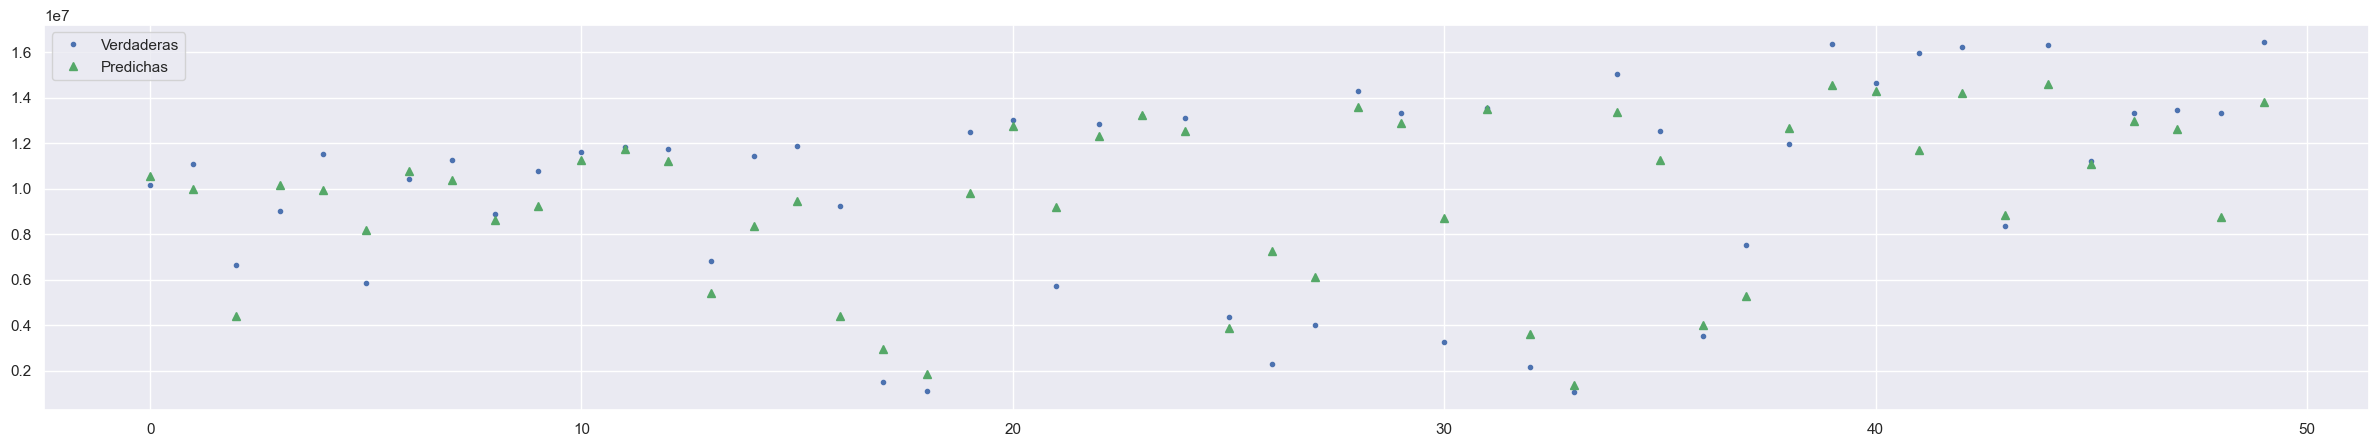

In [110]:
# Definimos el modelo
rf_regr = RandomForestRegressor(
            n_jobs       = -1,
            random_state = 12
         )

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_rf = Pipeline([("escalado", scaler), ("RF_regr", rf_regr)])

# Entrenamiento del modelo
t_previo_rf = time.time()
pipe_regr_rf.fit(X_train, y_train)
t_final_rf= time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_rf - t_previo_rf ," segundos")

# Visualizamos los valores predichos y los reales
pintaResultados(pipe_regr_rf,50)

##### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [111]:
# Valores predichos
predicciones_rf = pipe_regr_rf.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rf)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rf)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3158625.910674534
El error (MAE) de test es: 2177012.913808219
El error (R²) de test es: 0.8350605393209047


In [112]:
# Rendimiento
rendimiento_rf = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_rf,
                            'Error': y_test - predicciones_rf})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_rf 

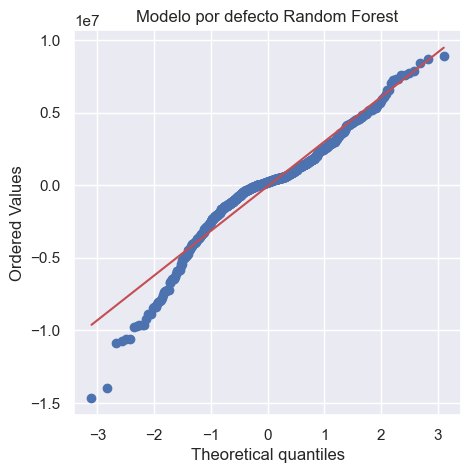

In [113]:
plt.figure(figsize=(5,5))

# Representación
ax_x_rf = rendimiento_rf['True Value']
ax_y_rf = rendimiento_rf['Prediction']
yerr_rf = rendimiento_rf['Error']
probplot(yerr_rf, dist='norm', plot=plt)
plt.title('Modelo por defecto Random Forest')

# Visualizar gráfica
plt.show()

#### Ajuste de Hiperparámetros

En el caso de Random Forest, hay muchos hiperparámetros a tener en cuenta. Sin embargo, se pueden destacar tres en concreto que son los más importantes:

- `max_features`: indica el número de predictores considerados a en cada división. Por conveniencia si hay 'n' predictores, se coge la raíz cuadrada (sqrt) de 'n'. No obstante, hay mas formas de considerar el número de preditores.
- `n_estimators`: indica el número de árboles incluidos en el modelo. Se puede aumentar sin problemas ya que no supone que haya overfitting. Sin embargo, llegado a un valor, no se van a obtener mejores resultados. (Debido a lo que se explica más abajo)
- `oob_score`: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

Como sabemos de clase, una vez que el `OOB` se estabiliza, converge al error que se obtendría con validación cruzada. Es decir, con esto necesitamos menos evaluaciones y se puede obtener durante el entrenamiento. En otras palabras, el error OBB converge (cuando tengo un número de árboles grande) al error de validación cruzada y por tanto, no es necesario hacer validación cruzada ya que no se tarda tanto. No obstante, conviene subrayar que nosotros realizaremos tanto validación cruzada(RandomizedSearch) como el OOB para enocntrar los mejores hiperparámetros del modelo, así podemos confirmar que efectivamente estamo cogiendo el valor óptimo.

`N_estimators`:

Ajustaremos primero el valor del número de árboles que vamos a incluir en el bosque.

Valor óptimo de n_estimators: 181


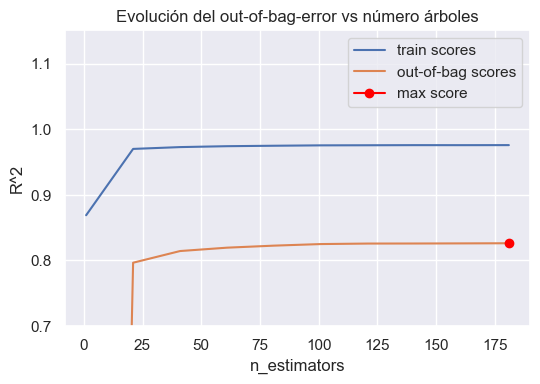

In [114]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range_est = range(1, 200, 20)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range_est:
    rf_est = RandomForestRegressor(
                n_estimators = n_estimators,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 12
             )
    rf_est.fit(X_train, y_train)
    train_scores.append(rf_est.score(X_train, y_train))
    oob_scores.append(rf_est.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range_est, train_scores, label="train scores")
ax.plot(estimator_range_est, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range_est[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
ax.set_ylim([0.7,None])
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range_est[np.argmax(oob_scores)]}")

In [115]:
# Definimos el espacio de búsqueda
param_rf_est = {'n_estimators': list(range(1, 200, 20))}

budget = 100 
# Búsqueda por validación cruzada
rf_random_est = RandomizedSearchCV(RandomForestRegressor(
                oob_score    = False,
                n_jobs       = -1,
                random_state = 12
             ), 
        param_rf_est,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1, verbose = 1,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_random_est = time.time()
rf_random_est.fit(X_train, y_train)
t_final_random_est = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_est - t_previo_random_est ," segundos")

Fitting 1 folds for each of 10 candidates, totalling 10 fits
El tiempo de entrenamiento del modelo es de :  87.75606369972229  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [116]:
rf_random_est.best_params_, -rf_random_est.best_score_

({'n_estimators': 61}, 10346594801901.586)

Como se puede observar en ambos coincide que el número de árboles óptimos es alrededor de 60 (en el de OOB aunque ponga que es 181, se puede ver cuando ambas líneas de la gráfica se estabilizan es alrededor de 60), aunque teniendo en cuenta lo anteriormente mencionado sobre el número de árboles y el error, aunque ampliemos el valor de n_estimators el valor de R^2 crece, pero con unos aumentos muy pequeños. Por eso el valor óptimo sería de `n_estimators = 61`.

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [117]:
# Valores predichos
predicciones_rf_est = rf_random_est.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf_est))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rf_est)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rf_est)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3177957.7541946466
El error (MAE) de test es: 2188342.252773411
El error (R²) de test es: 0.8330353919735338


`Max_features`:

El valor de max_features es uno de los hiperparámetros más importantes de RF, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

In [118]:
# Definimos el espacio de búsqueda
param_rf_ft = {'max_features': list(range(1, X_train.shape[1] + 1, 1))}

budget = 20 
# Búsqueda por validación cruzada
rf_random_ft = RandomizedSearchCV(RandomForestRegressor(
                n_estimators = 61,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 12
             ), 
        param_rf_ft,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1, verbose = 1,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_random_ft = time.time()
rf_random_ft.fit(X_train, y_train)
t_final_random_ft = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_ft - t_previo_random_ft ," segundos")

Fitting 1 folds for each of 20 candidates, totalling 20 fits
El tiempo de entrenamiento del modelo es de :  53.28765368461609  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [119]:
rf_random_ft.best_params_, -rf_random_ft.best_score_

({'max_features': 8}, 9961722719608.879)

Como se puede observar analizando los dos resultados, entendemos que el mejor parámetro para `max_features está para un valor de 8`.

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [120]:
# Valores predichos
predicciones_rf_ft = rf_random_ft.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf_ft))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rf_ft)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rf_ft)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3028636.683171593
El error (MAE) de test es: 2124388.6249270155
El error (R²) de test es: 0.8483569400069733


A continuación, vamos a ajustar más hiperparámetros para ver si podemos mejorar el desempeño del modelo, que por ahora está en 84.83% con max_features y n_estimators ajustados.

Para ello, vamos a ajustar, al igual que en árboles individuales:
- `max_depth`: indica la profundidad máxima que puede alcanzar el árbol.
- `min_samples_split`: indica el número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
- `min_samples_leaf`: indica el número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.

In [121]:
# Definimos el espacio de búsqueda
param_rf_total = {'max_depth': list(range(2,16,2)),
                  'min_samples_split': list(range(2,16,2)),
                  'min_samples_leaf': list(range(2,16,2))}

budget = 20 
# Búsqueda por validación cruzada
rf_random_total = RandomizedSearchCV(RandomForestRegressor(
                n_estimators = 61,
                max_features = 8,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 12
             ), 
        param_rf_total,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1, verbose = 1,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_random_total = time.time()
rf_random_total.fit(X_train, y_train)
t_final_random_total = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_total - t_previo_random_total ," segundos")

Fitting 1 folds for each of 20 candidates, totalling 20 fits
El tiempo de entrenamiento del modelo es de :  8.122719049453735  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [122]:
rf_random_total.best_params_, -rf_random_total.best_score_

({'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 12},
 9996608329692.521)

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [123]:
# Valores predichos
predicciones_rf_total = rf_random_total.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf_total))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_rf_total)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_rf_total)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3045973.0905055567
El error (MAE) de test es: 2115536.7864894094
El error (R²) de test es: 0.8466159123504144


Por algún motivo, al ajustar los paramátros mencionados anteriormente, el desempeño del modelo dismuye un poquito. Antes estaba a 84.83% y ahora a 84.66%.

#### Importancia de los atributos por pureza

Calculamos la importancia por la pureza de los nodos. Cuantifica el incremento total en la pureza de los nodos debido a divisiones en las que participa el predictor (promedio de todos los árboles)

In [124]:
modelo_final_rf = rf_random_ft.best_estimator_
# Entrenamos con todos los datos para el modelo final
_rf = modelo_final_rf.fit(X_train,y_train)

In [125]:
importancia_predictores = pd.DataFrame(
                            {'predictor': entrada.columns,
                             'importancia': _rf.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
71,uswrf_s2_1,0.097910
14,dswrf_s5_1,0.092404
12,dswrf_s3_1,0.089789
72,uswrf_s3_1,0.087533
11,dswrf_s2_1,0.079614
74,uswrf_s5_1,0.052762
13,dswrf_s4_1,0.051197
68,ulwrf_t4_1,0.029614
49,tmin_2m5_1,0.028249
73,uswrf_s4_1,0.027965


Como se puede observar incluso el predictor con mayor importancia tiene una importancia menor que el 10%, lo que indica que de por si los predictores no tienen mucho peso predictivo. Aun así, el peor de todos los predictores es el 70, con una importancia del 0.05%. Dicho esto, los 19 primeros predictores de la lista tienen una importancia entre el 9% y el 1%, a partir de ahí comienzan a bajar. Entendemos que ya una importancia menor del 1% es casi insignificativa a tener el cuenta que es el resto de 56 predictores. También podemos visualizar esto mismo de forma gráfica:    

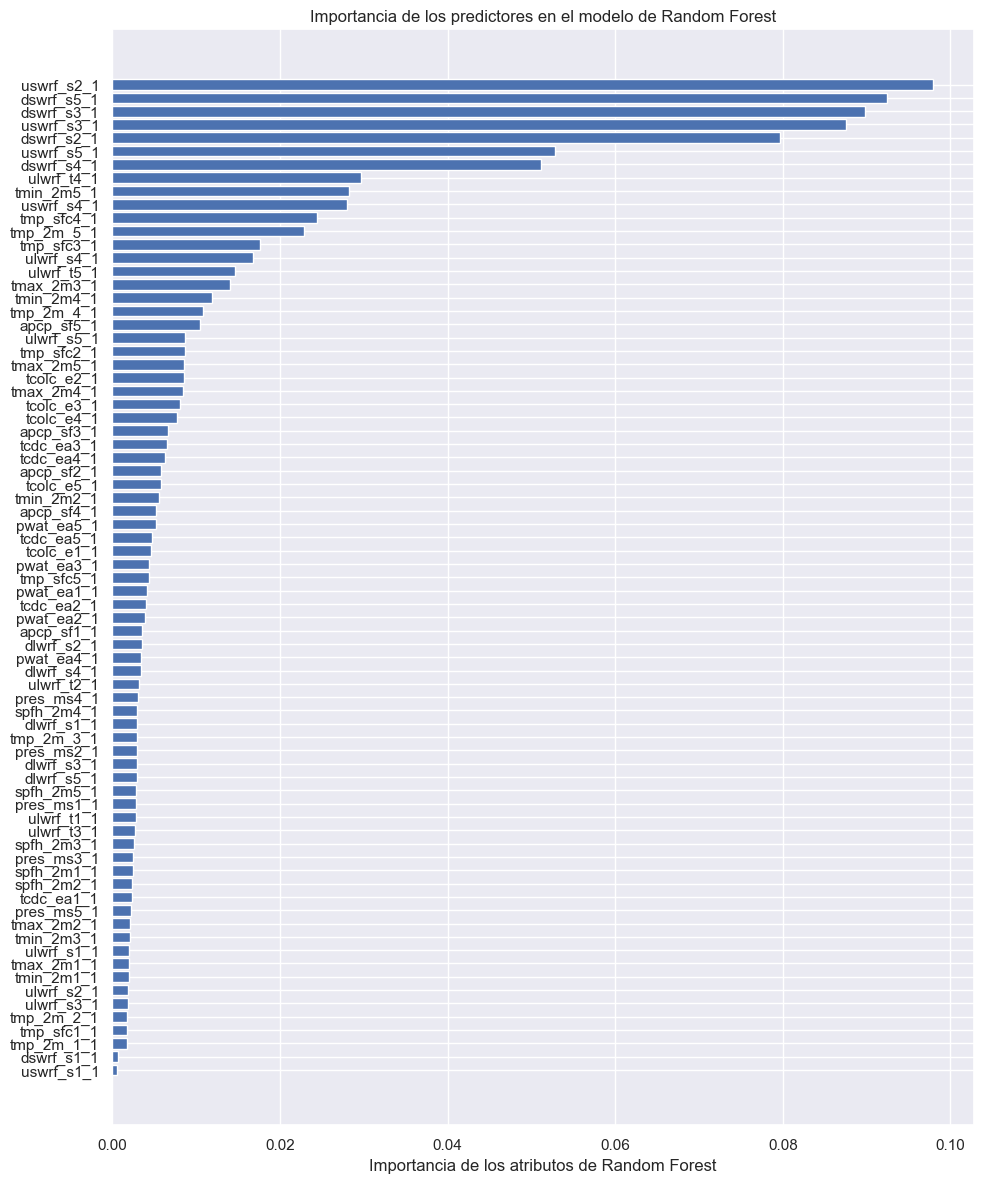

In [126]:
# Obtener los índices ordenados de importancia de los predictores
sorted_idx = _rf.feature_importances_.argsort()

# Crear una figura más grande
plt.figure(figsize=(10, 12))

# Graficar los datos en un gráfico de barras horizontales
plt.barh(entrada.columns[sorted_idx], _rf.feature_importances_[sorted_idx])

# Agregar etiquetas y título al gráfico
plt.xlabel("Importancia de los atributos de Random Forest")
plt.title("Importancia de los predictores en el modelo de Random Forest")

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Importancia por permutación
Identifica la influencia que tiene cada predictor sobre una determinada métrica de evaluación del modelo 

In [127]:
importancia = permutation_importance(
                estimator    = _rf,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 12
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
# df_importancia['feature'] = X_train.columns
df_importancia['feature'] = entrada.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
14,950487.943100,10410.513711,dswrf_s5_1
12,762115.896411,13350.216356,dswrf_s3_1
71,748135.485149,10203.489055,uswrf_s2_1
72,733172.554800,7100.939149,uswrf_s3_1
13,647704.060285,12311.007273,dswrf_s4_1
74,624639.117295,9575.792579,uswrf_s5_1
11,610382.830651,12584.088310,dswrf_s2_1
73,410282.308596,6298.271405,uswrf_s4_1
2,228940.456272,7856.134345,apcp_sf3_1
58,219839.104607,2825.155323,tmp_sfc4_1


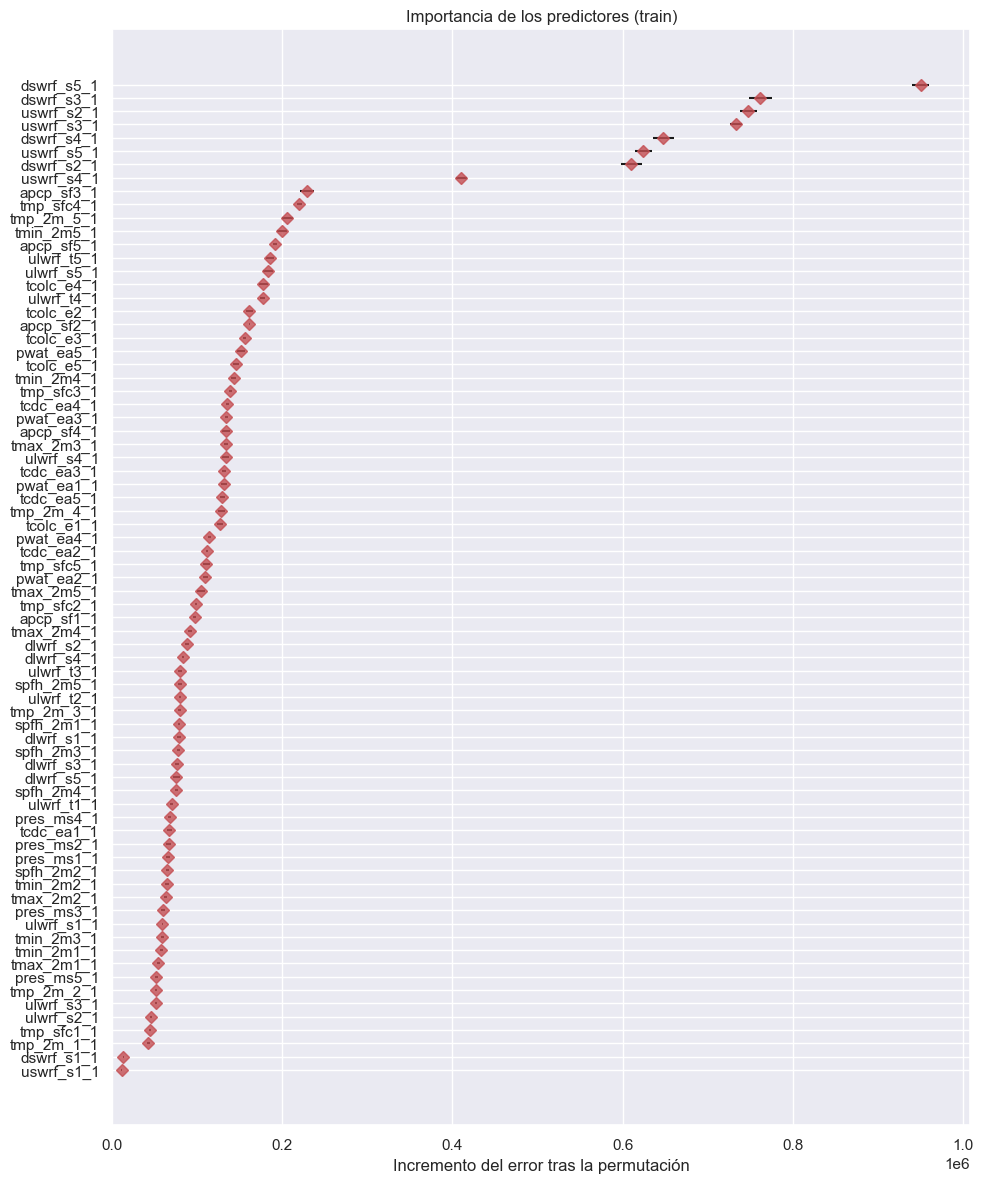

In [128]:
# Crear una figura más grande
fig, ax = plt.subplots(figsize=(10, 12))

# Ordenar los datos por importancia
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)

# Graficar los datos
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

# Agregar etiquetas y título al gráfico
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica de Random Forest, el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [129]:
# Errores de los modelos
d_rf = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf)), mean_absolute_error(y_test, y_pred = predicciones_rf), r2_score(y_test, y_pred = predicciones_rf)],
     ["Modelo optimizado", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf_ft)), mean_absolute_error(y_test, y_pred = predicciones_rf_ft), r2_score(y_test, y_pred = predicciones_rf_ft)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_rf = pd.DataFrame(d_rf, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_rf)

               Modelo          RMSE           MAE        R²
0  Modelo por defecto  3.158626e+06  2.177013e+06  0.835061
1   Modelo optimizado  3.028637e+06  2.124389e+06  0.848357
2        Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


Como se puede observar, obtenemos mejores valores con el modelo ajustado que sin el de optimizar. Esto lo podemos deducir debido a que tanto el `RMSE` como el `MAE` disminuye al optimizar el modelo y como siempre hemos mencionado durante el proyecto, el `RMSE` y el `MAE` es mejor cuanto más pequeño. Este se ha reducido en una cuantía del 5% y 3% respectivamente. Con respecto al `R²`, podemos observar que este ha aumentado en un 1,2%. Aunque se ha producido mejora, debemos resaltar que los cambios no han sido tan significativos como en los modelos anteriores.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo optimizado (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [130]:
# Rendimiento
rendimiento_rf_total = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_rf_ft,
                            'Error': y_test - predicciones_rf_ft})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_rf_total 

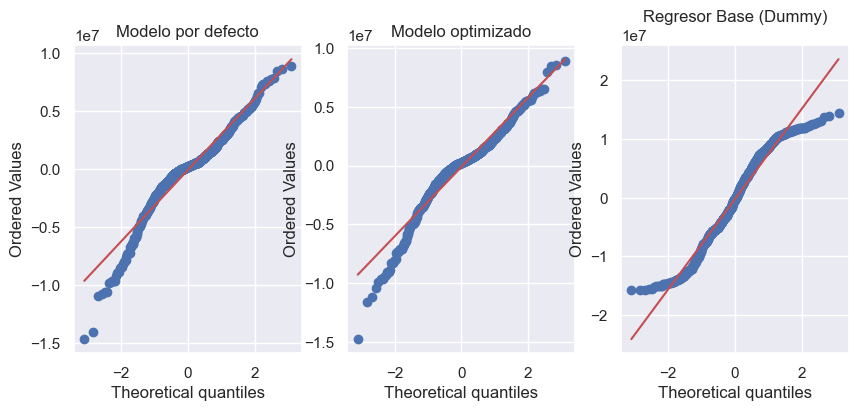

In [131]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_rf = rendimiento_rf['True Value']
ax_y_rf = rendimiento_rf['Prediction']
yerr_rf = rendimiento_rf['Error']

# QQ Plot
probplot(yerr_rf, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_rf_total = rendimiento_rf_total['True Value']
ax_y_rf_total = rendimiento_rf_total['Prediction']
yerr_rf_total = rendimiento_rf_total['Error']

# QQ Plot
probplot(yerr_rf_total, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

Tambien podemos visualizarlo de esta manera, aunque es menos intuitiva:

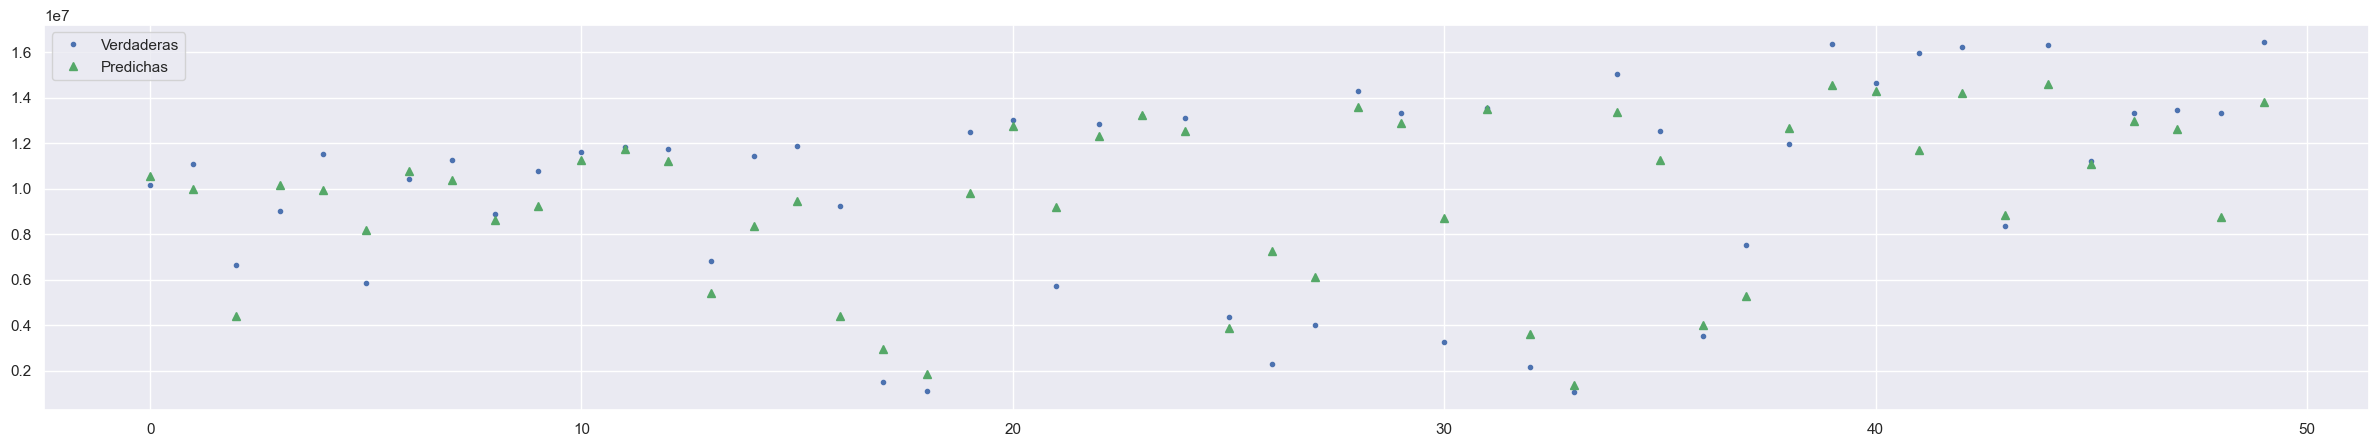

In [132]:
pintaResultados(pipe_regr_rf,50)

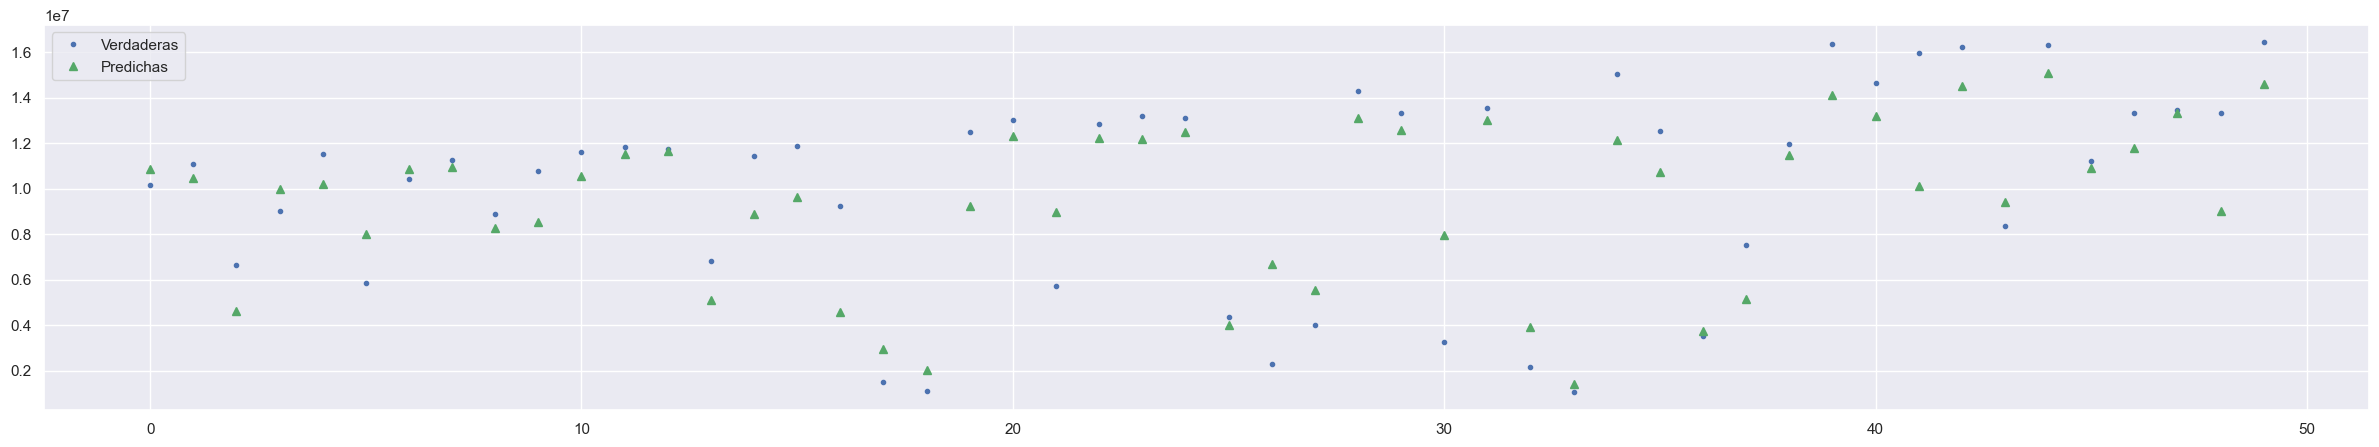

In [133]:
pintaResultados(rf_random_ft,50)

### Extremely Randomized Trees

Los árboles extremadamente aleatorios que se encuentran principalmente formados por múltiples árboles de decisión durante el periodo de entrenamiento del conjunto de datos. El proceso de construcción es similar al de los árboles de decisión, pero añadiéndole dos niveles más de características aleatorias. 

-	En primer lugar, para evitar el sobreajuste de los datos, se introducen umbrales de decisión aleatorios par a cada característica en los nodos de cada árbol.
-	En segundo lugar, para intentar sortear el problema de datos o características redundantes, las características se van a escoger de forma aleatoria en vez de escogerlas todas.

En cuanto a diferencias principales con Random Forest en sí, podemos encontrar cuatro principales diferencias, la primera de ellas es que realiza muestreos del conjunto de datos entero; en segundo lugar, la división de los nodos es completamente aleatoria mientras que en el Random Forest, se realiza la división del nodo con la mejor separación (este hecho hace que computacionalmente sea más rápido este algoritmo puesto que la separación es aleatoria) y por último, genera por lo general una menor varianza.


In [134]:
# Definimos el modelo
extra_regr = ExtraTreesRegressor(random_state=12)

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_extra = Pipeline([("escalado", scaler), ("EXTRA_regr", extra_regr)])

# Entrenamiento del modelo
t_previo_extra = time.time()
pipe_regr_extra.fit(X_train, y_train)
t_final_extra= time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_extra - t_previo_extra ," segundos")

El tiempo de entrenamiento del modelo es de :  7.404424667358398  segundos


##### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [135]:
# Valores predichos
predicciones_extra = pipe_regr_extra.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_extra)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_extra)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3069078.736277056
El error (MAE) de test es: 2134174.125150685
El error (R²) de test es: 0.8442800543604255


#### Ajuste de Hiperparámetros

Además de hiperparámetros comentandos anteriormente con Random Forest (`max_features` y `n_estimators`). Hay dos parámetros de interés, pero nosotros no los vamos a usar en la búsqueda de hiperparámetros:

- `criterion` ={“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error” Mide la calidad de la partición realizada.
- `bootstrapbool`, default=False. Si se utiliza bootstraping en la selección de muestras. Con el valor de False, se utilizan todas las muestras.

In [136]:
# Definimos el espacio de búsqueda
param_extra = {'n_estimators': sp_randint(10,200),
               'max_features': sp_randint(1,X_train.shape[1] + 1)}

budget = 100 
# Búsqueda por validación cruzada
extra_random = RandomizedSearchCV(ExtraTreesRegressor(random_state = 12), 
        param_extra,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1, verbose = 1,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_random_extra = time.time()
extra_random.fit(X_train, y_train)
t_final_random_extra = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_extra - t_previo_random_extra ," segundos")

Fitting 1 folds for each of 100 candidates, totalling 100 fits
El tiempo de entrenamiento del modelo es de :  124.57267141342163  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [137]:
extra_random.best_params_, -extra_random.best_score_

({'max_features': 26, 'n_estimators': 66}, 9672777022187.342)

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [138]:
# Valores predichos
predicciones_extra_random = extra_random.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra_random))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_extra_random)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_extra_random)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3038023.720089933
El error (MAE) de test es: 2125454.9752594437
El error (R²) de test es: 0.847415470206527


#### Importancia de los atributos por pureza

Calculamos la importancia por la pureza de los nodos. Cuantifica el incremento total en la pureza de los nodos debido a divisiones en las que participa el predictor (promedio de todos los árboles)

In [139]:
modelo_final_extra = extra_random.best_estimator_
# Entrenamos con todos los datos para el modelo final
_extra = modelo_final_extra.fit(X_train,y_train)

In [140]:
importancia_predictores = pd.DataFrame(
                            {'predictor': entrada.columns,
                             'importancia': _extra.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
14,dswrf_s5_1,0.135045
12,dswrf_s3_1,0.134474
13,dswrf_s4_1,0.100471
71,uswrf_s2_1,0.095138
11,dswrf_s2_1,0.086427
74,uswrf_s5_1,0.055020
72,uswrf_s3_1,0.039462
73,uswrf_s4_1,0.028084
63,ulwrf_s4_1,0.023789
49,tmin_2m5_1,0.020525


Como se puede observar incluso el predictor con mayor importancia tiene una importancia del 13%, lo que indica que de por si los predictores no tienen mucho peso predictivo. Aun así, el peor de todos los predictores es el 70 (al igual que en RF), con una importancia del 0.1452%. Dicho esto, los 15 primeros predictores de la lista tienen una importancia entre el 13% y el 1%, a partir de ahí comienzan a bajar. Entendemos que ya una importancia menor del 1% es casi insignificativa a tener el cuenta que es el resto de 60 predictores. También podemos visualizar esto mismo de forma gráfica:    

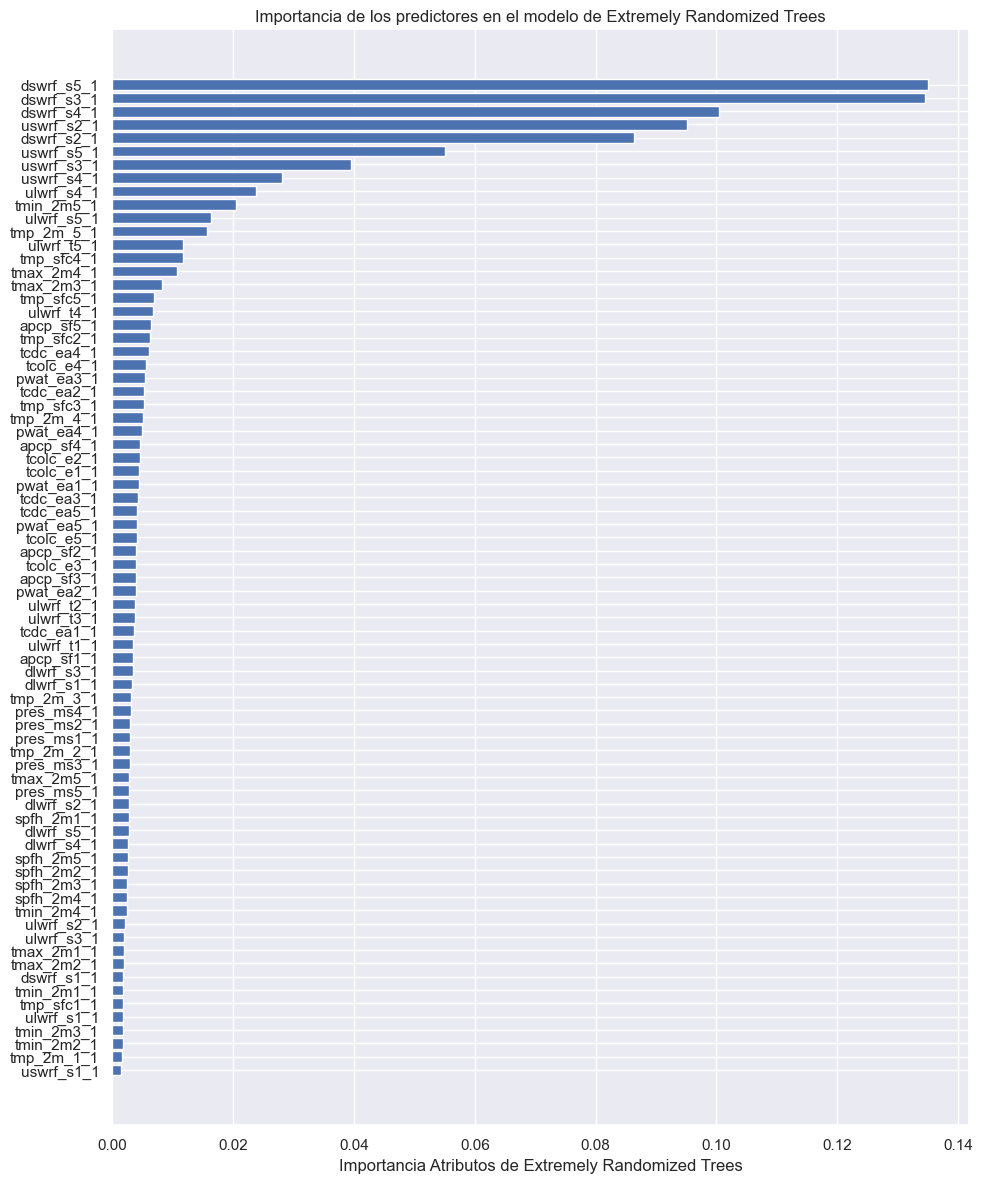

In [141]:
# Obtener los índices ordenados de importancia de los predictores
sorted_idx = _extra.feature_importances_.argsort()

# Crear una figura más grande
plt.figure(figsize=(10, 12))

# Graficar los datos en un gráfico de barras horizontales
plt.barh(entrada.columns[sorted_idx], _extra.feature_importances_[sorted_idx])

# Agregar etiquetas y título al gráfico
plt.xlabel("Importancia Atributos de Extremely Randomized Trees")
plt.title("Importancia de los predictores en el modelo de Extremely Randomized Trees")

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Importancia por permutación
Identifica la influencia que tiene cada predictor sobre una determinada métrica de evaluación del modelo 

In [142]:
importancia = permutation_importance(
                estimator    = _extra,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 12
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia_extra = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
# df_importancia['feature'] = X_train.columns
df_importancia_extra['feature'] = entrada.columns
df_importancia_extra.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
14,2.558588e+06,20319.885628,dswrf_s5_1
13,1.791631e+06,23989.624623,dswrf_s4_1
12,1.756847e+06,26139.630651,dswrf_s3_1
71,1.635057e+06,11027.391481,uswrf_s2_1
74,1.229517e+06,10154.980594,uswrf_s5_1
11,1.179911e+06,14063.117329,dswrf_s2_1
72,1.070159e+06,5318.799156,uswrf_s3_1
73,7.842437e+05,2643.832174,uswrf_s4_1
4,5.862869e+05,8370.315862,apcp_sf5_1
54,4.809684e+05,8558.240915,tmp_2m_5_1


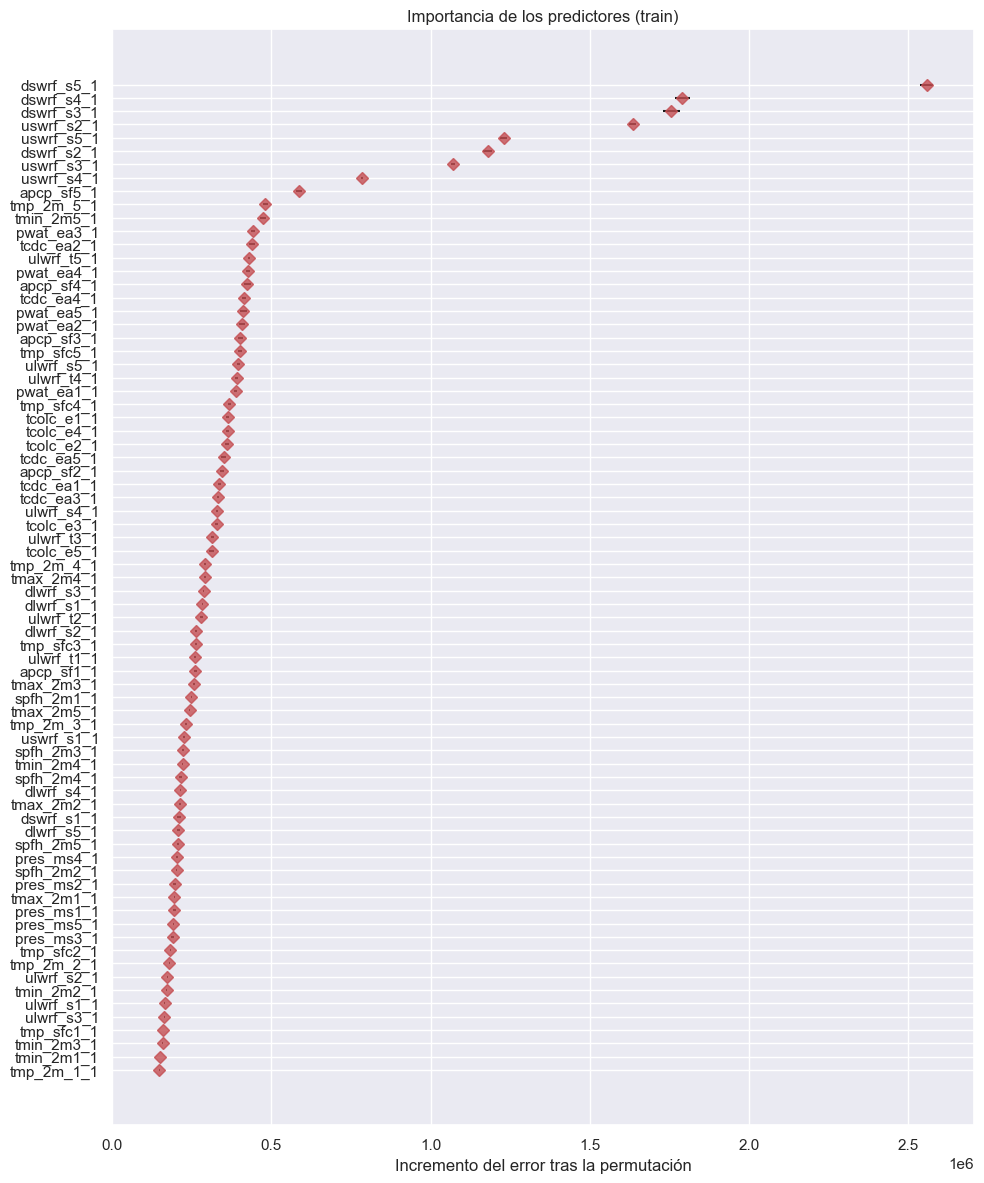

In [143]:
# Crear una figura más grande
fig, ax = plt.subplots(figsize=(10, 12))

# Ordenar los datos por importancia
df_importancia_extra = df_importancia_extra.sort_values('importances_mean', ascending=True)

# Graficar los datos
ax.barh(
    df_importancia_extra['feature'],
    df_importancia_extra['importances_mean'],
    xerr=df_importancia_extra['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia_extra['importances_mean'],
    df_importancia_extra['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

# Agregar etiquetas y título al gráfico
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica de Extra Randomized Trees, el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [144]:
# Errores de los modelos
d_extra = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra)), mean_absolute_error(y_test, y_pred = predicciones_extra), r2_score(y_test, y_pred = predicciones_extra)],
     ["Modelo optimizado", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra_random)), mean_absolute_error(y_test, y_pred = predicciones_extra_random), r2_score(y_test, y_pred = predicciones_extra_random)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_extra = pd.DataFrame(d_extra, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_extra)

               Modelo          RMSE           MAE        R²
0  Modelo por defecto  3.069079e+06  2.134174e+06  0.844280
1   Modelo optimizado  3.038024e+06  2.125455e+06  0.847415
2        Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


En este caso, se puede apreciar que el modelo optimizado mejora los valores de `RMSE`, `MAE` y `R²` ligeramente, tanto que casi no se puede apreciar; de la orden del 1% y 2% en el caso de los dos primeros, y 3% en el caso de R2. Por todo ello, podemos concluir que la optimización mejora los resultados del modelo pero no de forma significativa. Aun así, es uno de los valores mas elevados que hemos obtenido. Sin embargo, se encuentra por debajo del mencionado previamente Random Forest.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo optimizado (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [145]:
# Rendimiento
rendimiento_extra = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_extra,
                            'Error': y_test - predicciones_extra})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_extra

# Rendimiento
rendimiento_extra_random = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_extra_random,
                            'Error': y_test - predicciones_extra_random})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_extra_random

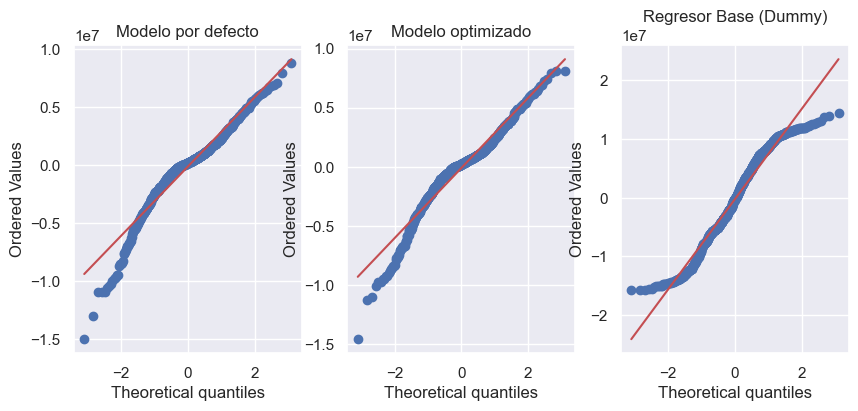

In [146]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_extra = rendimiento_extra['True Value']
ax_y_extra = rendimiento_extra['Prediction']
yerr_extra = rendimiento_extra['Error']

# QQ Plot
probplot(yerr_extra, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_extra_random = rendimiento_extra_random['True Value']
ax_y_extra_random = rendimiento_extra_random['Prediction']
yerr_extra_random = rendimiento_extra_random['Error']

# QQ Plot
probplot(yerr_extra_random, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

### Gradient Boosting Trees

El Gradient Boosting Tree es un modelo de aprendizaje automático supervisado que se puede emplear tanto para problemas de regresión como de clasificación.

Su forma de funcionamiento consiste principalmente en un conjunto (ensemble) de árboles individuales donde cada nuevo árbol trata de mejorar los errores de árboles anteriores. Estos árboles individuales, son entrenados de forma secuencial donde cada árbol utiliza infomación del árbol anterior con el objetivo de aprender de los errores que produce cada error y así mejorar por cada iteración que pasa. Por todo ello, se conseguirá mejorar la precisión del modelo corrigiendo los errores de los árboles anteriores.

Por último, queremos resaltar algunas de las ventajas que proporciona este modelo como por ejemplo, la capacidad de trabajar con diferetes tipos de variables como numéricas y categóricas. Además, otro factor importante, es que puede tratar con problemas cuyos datos se encuentren desequilibrados.

El tiempo de entrenamiento del modelo es de :  3.424793004989624  segundos


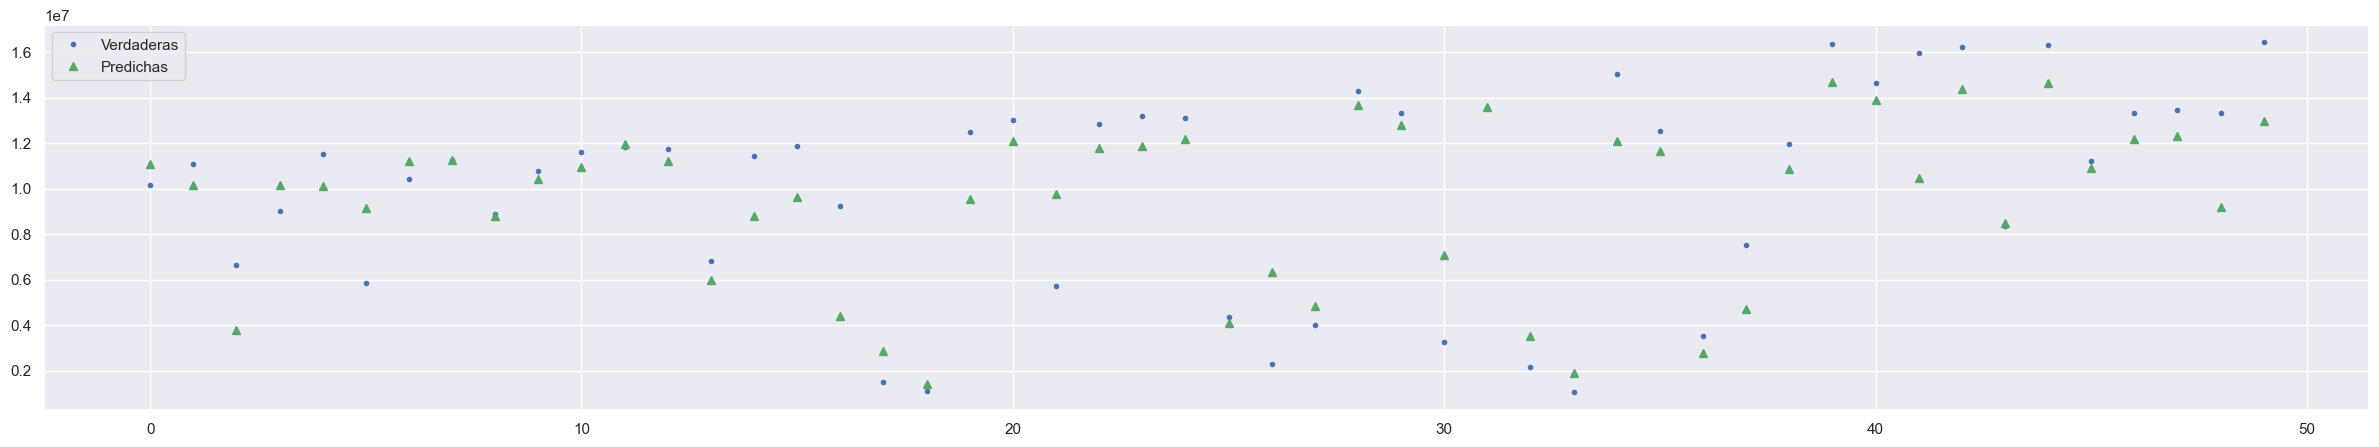

In [147]:
# Definimos el modelo
gb_regr = HistGradientBoostingRegressor(random_state=12)

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_gb = Pipeline([("escalado", scaler), ("GB_regr", gb_regr)])

# Entrenamiento del modelo
t_previo_gb = time.time()
pipe_regr_gb.fit(X_train, y_train)
t_final_gb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_gb - t_previo_gb ," segundos")

# Visualización del modelo
pintaResultados(pipe_regr_gb,50)

##### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [148]:
# Valores predichos
predicciones_gb = pipe_regr_gb.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_gb)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_gb)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2987827.0041709333
El error (MAE) de test es: 2078428.6540168128
El error (R²) de test es: 0.8524160672121004


#### Ajuste de Hiperparámetros

En el caso de Gradient Boosting Trees, hay muchos hiperparámetros a tener en cuenta.  Los que sirven para controlar el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar overfitting, son:

- `learning_rate`: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- `max_iter`: El número máximo de iteraciones del proceso de boosting, es decir, el número máximo de árboles.
- `max_depth`: indica la profundidad máxima que puede alcanzar el árbol.
- `min_samples_split`: indica el número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.
- `min_samples_leaf`: indica el número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.
- `validation_fraction`: proporción de datos separados del conjunto entrenamiento y empleados como conjunto de validación para determinar la parada temprana (early stopping).
- `n_iter_no_change`: número de iteraciones consecutivas en las que no se debe superar el tol para que el algoritmo se detenga (early stopping). Si su valor es None se desactiva la parada temprana.
- `tol`: porcentaje mínimo de mejora entre dos iteraciones consecutivas por debajo del cual se considera que el modelo no ha mejorado.
- `l2_regularization`: indica el valor del parámetro de regularización l2. La regularización añade la penalización a medida que aumenta la complejidad del modelo. El parámetro de regularización (λ) penaliza todos los parámetros excepto el intercepto para que el modelo generalice los datos y no se ajuste en exceso.
- `max_leaf_nodes`: indica el número máximo de hojas por cada árbol. Su valor debe ser estrictamente mayor que 1. 

Teniendo en cuenta lo anteriormente mencionado, nosotros vamos a realizar la búsqueda sobre aquello hiperparámetros que considereamos más importantes. Estos son `max_depth`, `learning_rate`, `l2_regularization` y `max_leaf_nodes`.

In [149]:
# Definimos el espacio de búsqueda
param_gb = {'max_depth'         : [None, 1, 3, 5, 10, 20],
            'learning_rate'     : [0.001, 0.01, 0.1, 0.2],
            'l2_regularization' : [0, 1],
            'max_leaf_nodes': [3, 10, 30]}

budget = 24 
# Búsqueda por validación cruzada
gb_random = RandomizedSearchCV(HistGradientBoostingRegressor(max_iter            = 1000,
                                                            random_state        = 12,
                                                            # Activación de la parada temprana
                                                            validation_fraction = 0.1,
                                                            n_iter_no_change    = 5,
                                                            tol                 = 0.0001), 
        param_gb,
        cv         = ps,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1, verbose = 1,
        n_iter = budget
      )

# Entrenar el proceso
np.random.seed(12)

t_previo_random_gb = time.time()
gb_random.fit(X_train, y_train)
t_final_random_gb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_gb - t_previo_random_gb ," segundos")

Fitting 1 folds for each of 24 candidates, totalling 24 fits
El tiempo de entrenamiento del modelo es de :  53.497451305389404  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [150]:
gb_random.best_params_, -gb_random.best_score_

({'max_leaf_nodes': 3,
  'max_depth': 10,
  'learning_rate': 0.1,
  'l2_regularization': 1},
 10242706773095.586)

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [151]:
# Valores predichos
predicciones_gb_random = gb_random.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb_random))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_gb_random)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_gb_random)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3026129.086442483
El error (MAE) de test es: 2127012.0975567945
El error (R²) de test es: 0.8486079454993362


#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica de Gradient Boosting Trees, el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [152]:
# Errores de los modelos
d_gb = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb)), mean_absolute_error(y_test, y_pred = predicciones_gb), r2_score(y_test, y_pred = predicciones_gb)],
     ["Modelo optimizado", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb_random)), mean_absolute_error(y_test, y_pred = predicciones_gb_random), r2_score(y_test, y_pred = predicciones_gb_random)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_gb = pd.DataFrame(d_gb, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_gb)

               Modelo          RMSE           MAE        R²
0  Modelo por defecto  2.987827e+06  2.078429e+06  0.852416
1   Modelo optimizado  3.026129e+06  2.127012e+06  0.848608
2        Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


En este caso, podemos observar que los valores de `RMSE`, `MAE` y `R²` disminuyen con respecto a modelo por defecto; indicando que debemos mantener el modelo por defecto puesto que tiene mejores valores en los tres valores errores observados.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo por defecto (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era menor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [153]:
# Rendimiento
rendimiento_gb = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_gb,
                            'Error': y_test - predicciones_gb})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_gb

# Rendimiento
rendimiento_gb_random = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_gb_random,
                            'Error': y_test - predicciones_gb_random})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_gb_random

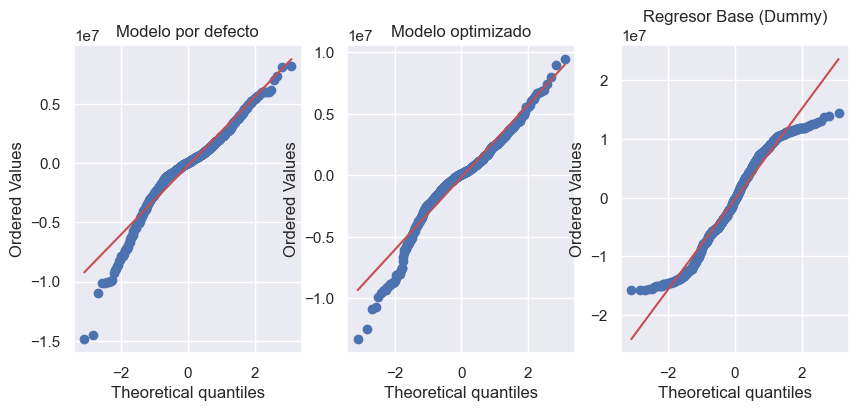

In [154]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_gb = rendimiento_gb['True Value']
ax_y_gb = rendimiento_gb['Prediction']
yerr_gb = rendimiento_gb['Error']

# QQ Plot
probplot(yerr_gb, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_gb_random = rendimiento_gb_random['True Value']
ax_y_gb_random = rendimiento_gb_random['Prediction']
yerr_gb_random = rendimiento_gb_random['Error']

# QQ Plot
probplot(yerr_gb_random, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

### XGBoost

`XGBoost` también conocido como `"extreme gradient boosting"`, es un método de aprendizaje automático supervisado. Como es lógico, se emplea con árboles de decisión y su función principal es la de combinar modelos predictivos más débiles para que tengan una mayor capacidad predictiva. 

Se le conoce principalmente por mejorar el algoritmo previo de Gradient Boosting gracias a dos factores principalmente. El primero de ellos es que posee un cálculo eficiente de gradientes. El segundo de ellos es que emplea árboles de decision regulares; reduciendo el sobreajuste y aumentando la capacidad de interpretación del modelo, su precisión y eficiencia.

Por último, en cuanto a `ventajas` y `desventajas`, podemos destacar que es un método como hemos mencionado, de una alta precisión y velocidad. Además, es bastante flexible puesto que se puede emplear en una gran variedad de situaciones. En cuanto a desventajas, destaca la gran sensibilidad que posee frente a los parámetros que le podemos asignar.  

El tiempo de entrenamiento del modelo es de :  2.914808750152588  segundos


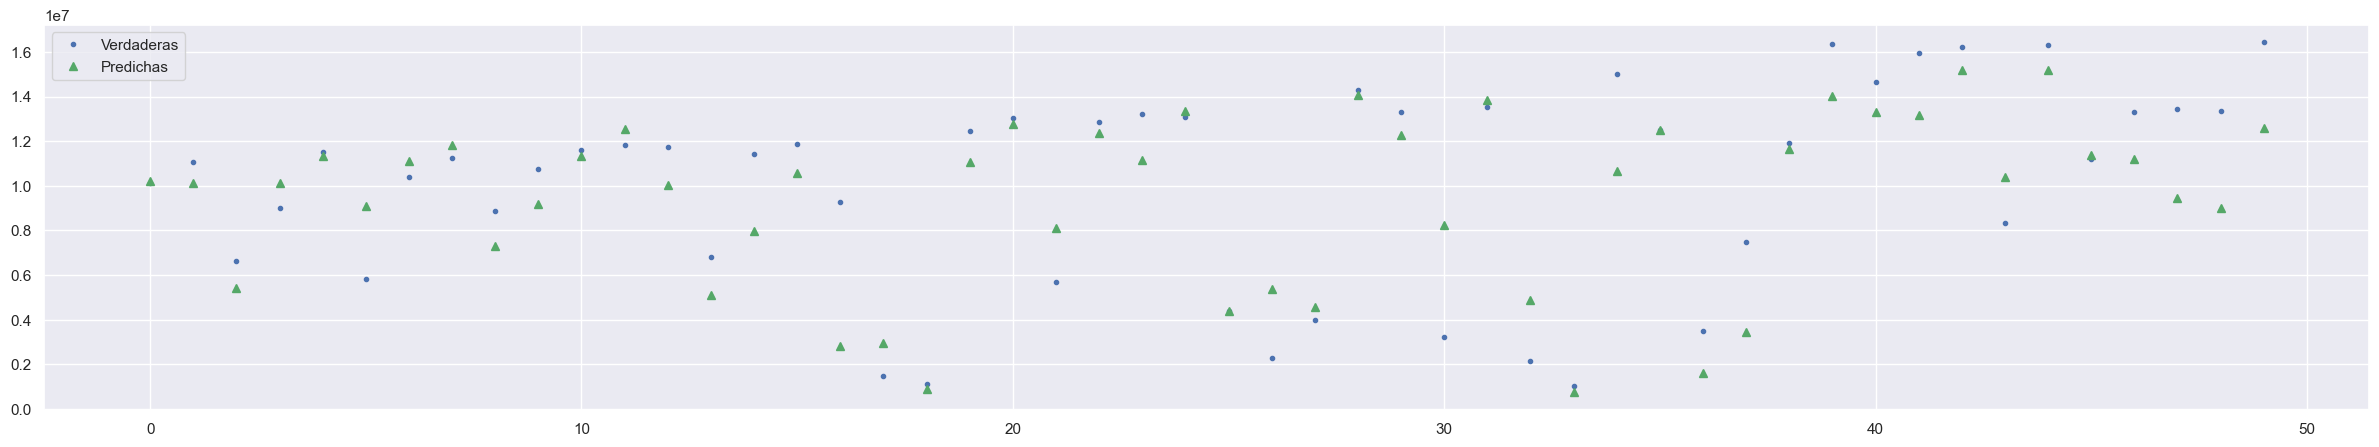

In [155]:
# Definimos el modelo
xgb_regr = XGBRegressor(random_state=12)

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_xgb = Pipeline([("escalado", scaler), ("XGB_regr", xgb_regr)])

# Entrenamiento del modelo
t_previo_xgb = time.time()
pipe_regr_xgb.fit(X_train, y_train)
t_final_xgb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_xgb - t_previo_xgb ," segundos")

# Visualización del modelo
pintaResultados(pipe_regr_xgb,50)

#### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [156]:
# Valores predichos
predicciones_xgb = pipe_regr_xgb.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_xgb)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_xgb)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3095892.066547308
El error (MAE) de test es: 2197660.660702055
El error (R²) de test es: 0.8415472410478803


#### Ajuste de Hiperparámetros

Se van a ajustar los mismo parámetros que se comentaron el histgradient boosting

In [157]:
# espacio de búsqueda
param_xgb = {'max_depth'        : [None, 1, 2, 3, 4, 5, 6, 7, 8],
              'subsample'        : [0.5, 0.7],
              'learning_rate'    : [0.009, 0.01, 0.011, 0.012],
              'n_estimators'     : sp_randint(50, 500)
              }

# Búsqueda por random search con validación cruzada
# ==============================================================================
budget = 40
xgb_random = RandomizedSearchCV(
    estimator  = XGBRegressor(random_state = 12),
    param_distributions = param_xgb,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = multiprocessing.cpu_count() - 1,
    cv         = ps,
    verbose    = 0,
    n_iter=budget
    )

t_previo_random_xgb = time.time()
xgb_random.fit(X = X_train, y = y_train)
t_final_random_xgb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_xgb - t_previo_random_xgb ," segundos")

El tiempo de entrenamiento del modelo es de :  117.34190845489502  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [158]:
xgb_random.best_params_, -xgb_random.best_score_

({'learning_rate': 0.012,
  'max_depth': 6,
  'n_estimators': 303,
  'subsample': 0.7},
 3133857.102457204)

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [159]:
# Valores predichos
predicciones_xgb_random = xgb_random.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb_random))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_xgb_random)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_xgb_random)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3092693.220453275
El error (MAE) de test es: 2236347.646061644
El error (R²) de test es: 0.8418745161060885


#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica de Gradient Boosting Trees, el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [160]:
# Errores de los modelos
d_xgb = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb)), mean_absolute_error(y_test, y_pred = predicciones_xgb), r2_score(y_test, y_pred = predicciones_xgb)],
     ["Modelo optimizado", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb_random)), mean_absolute_error(y_test, y_pred = predicciones_xgb_random), r2_score(y_test, y_pred = predicciones_xgb_random)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_xgb = pd.DataFrame(d_xgb, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_xgb)

               Modelo          RMSE           MAE        R²
0  Modelo por defecto  3.095892e+06  2.197661e+06  0.841547
1   Modelo optimizado  3.092693e+06  2.236348e+06  0.841875
2        Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


Se puede observar que no existen grandes diferencias entre el modelo por defecto y el optimizado. Sin embargo, si que es verdad que el valor del modelo optimizado es ligeramente mayor disminuyendo en un 1% y 2% en `RMSE` y `MAE` respectivamente. Además, debemos considerar también que el `R²` es mayor incrementandose en 0,23%. Como se puede ver, estas diferencias son muy pocos significativas y no se puede observar un gran cambio. No obstante, es mejor el modelo optimizado.

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo optimizado (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [161]:
# Rendimiento
rendimiento_xgb = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_xgb,
                            'Error': y_test - predicciones_xgb})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_xgb

# Rendimiento
rendimiento_xgb_random = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_xgb_random,
                            'Error': y_test - predicciones_xgb_random})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_xgb_random

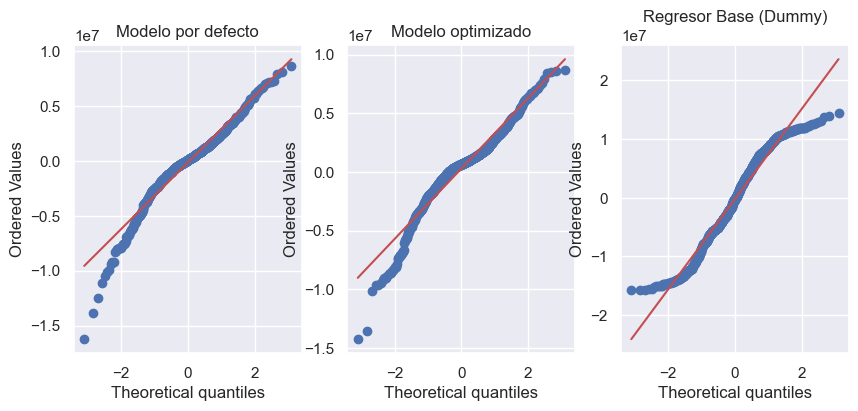

In [162]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_xgb = rendimiento_xgb['True Value']
ax_y_xgb = rendimiento_xgb['Prediction']
yerr_xgb = rendimiento_xgb['Error']

# QQ Plot
probplot(yerr_xgb, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_xgb_random = rendimiento_xgb_random['True Value']
ax_y_xgb_random = rendimiento_xgb_random['Prediction']
yerr_xgb_random = rendimiento_xgb_random['Error']

# QQ Plot
probplot(yerr_xgb_random, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

### LightGBM

Como los anteriores métodos explicados, `LightGBM` se basa también en árboles de decisión y sirve tanto para problemas de clasificación como de regresión.

`LightGBM`, se encarga de generar árboles que crecen por hojas en función de la ganancia de dicha hoja. Esta forma de subdivisión de este método se denomina técnica de partición vertical o `"splitting vertical"`, y como hemos mencionado, se encarga de elegir el punto de división que maximiza la ganancia.

Algunas de las `ventajas` principales de este método sería la reducción de la dimensionalidad y el aumento de la eficiencia. Además, es reconocido también por tener obtener una buena precisión del modelo mediante la técnica de regularización denominada "GOSS". Por último, otra ventaja al igual que en el método anterior es que permite una gran versatilidad en cuanto a los problemas o situaciones que se le puede plantear. Con respecto a las `desventajas`, podemos destacar la gran sensibilidad que posee frente a la modificación de parámetros.

El tiempo de entrenamiento del modelo es de :  0.9274237155914307  segundos


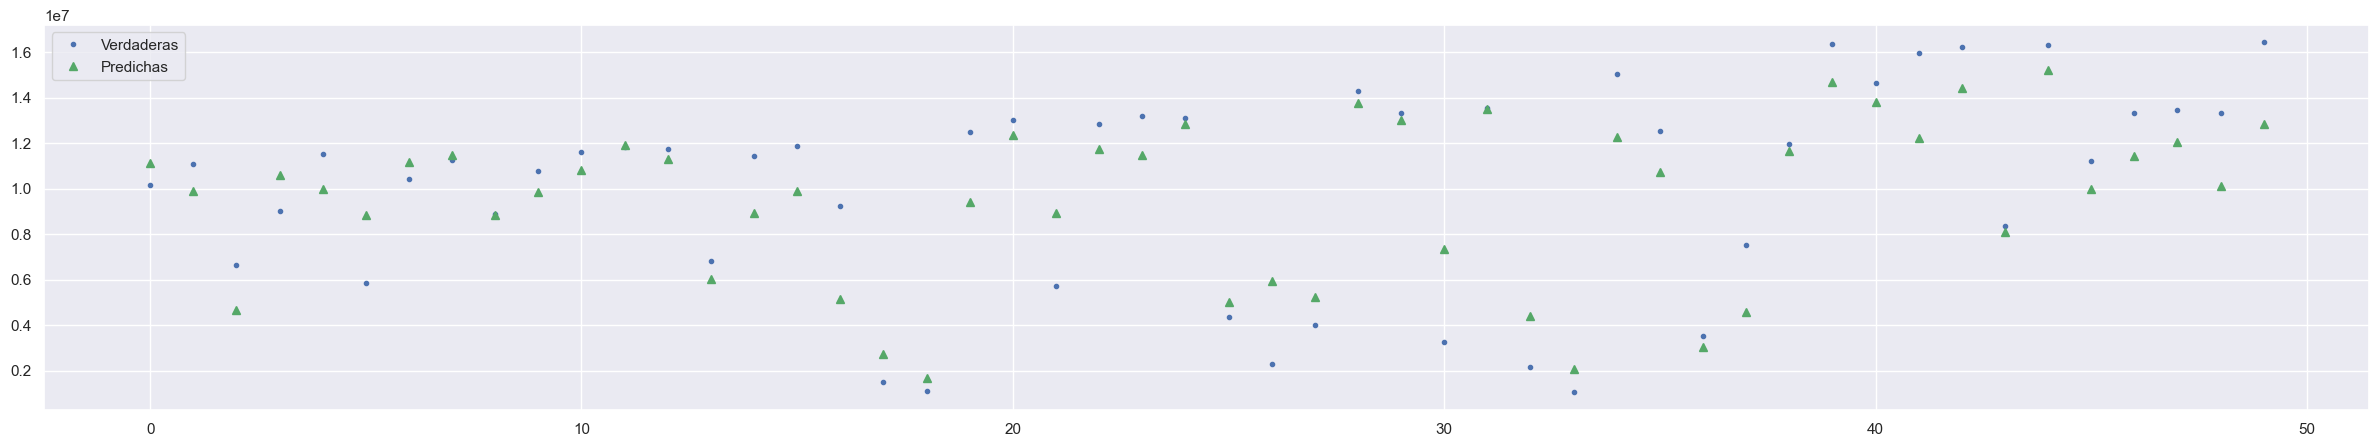

In [163]:
# Definimos el modelo
lgb_regr = LGBMRegressor(random_state=12)

# Para que el entrenamiento del árbol también sea reproducible (en caso de que el entrenamiento del árbol sea no determinista)
np.random.seed(12)

scaler = StandardScaler()

pipe_regr_lgb = Pipeline([("escalado", scaler), ("LGB_regr", lgb_regr)])

# Entrenamiento del modelo
t_previo_lgb = time.time()
pipe_regr_lgb.fit(X_train, y_train)
t_final_lgb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_lgb - t_previo_lgb ," segundos")

# Visualización del modelo
pintaResultados(pipe_regr_lgb,50)

#### Evaluación de errores del modelo

En primer lugar, debemos explicar que es lo que nos indica cada una de los factores mostrados en la tabla anterior:
-    `RMSE` (error cuadrático medio): mide la cantidad de error que hay entre dos conjuntos de datos; comparando por tanto el valor que ha sido predicho con el valor observado.
-    `MAE` (error absoluto medio): se emplea para cuantificar la diferencia entre los valores reales y las predicciones del modelo. Además, el MAE, se enfoca en la magnitud que poseen los errores y no en su dirección.
-    `R²` (coeficiente de determinación): se encarga de medir cuanta variabilidad de la variable dependiente se puede explicar por el modelo. El rango de valores en el que se mueve es entre 0 y 1, significando que con un valor de 0 no se explica absolutamente nada de la variabilidad de la variable dependiente; sin embargo, con el valor 1 se explica por completo.

In [164]:
# Valores predichos
predicciones_lgb = pipe_regr_lgb.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_lgb)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_lgb)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3035528.7785165617
El error (MAE) de test es: 2113428.820102682
El error (R²) de test es: 0.8476659838321557


#### Ajuste de Hiperparámetros

Se van a ajustar los mismo parámetros que se comentaron el histgradient boosting

In [165]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_lgb = {'n_estimators'     : sp_randint(100, 5000),
              'max_depth'        : [-1, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================

budget = 40
lgb_random = RandomizedSearchCV(
        estimator  = LGBMRegressor(random_state=12),
        param_distributions = param_lgb,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = ps, 
        verbose    = 0,
        return_train_score = True,
        n_iter=budget
       )


t_previo_random_lgb = time.time()
lgb_random.fit(X = X_train, y = y_train)
t_final_random_lgb = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_random_lgb - t_previo_random_lgb ," segundos")


El tiempo de entrenamiento del modelo es de :  256.7303259372711  segundos


Visualizamos los mejores valores de los hiperparámetros y su puntuación.

In [166]:
lgb_random.best_params_, -lgb_random.best_score_

({'boosting_type': 'gbdt',
  'learning_rate': 0.001,
  'max_depth': 20,
  'n_estimators': 3825,
  'subsample': 1},
 3191838.609875735)

Ahora calculamos el rendimiento del regr en la partición de prueba.

In [167]:
# Valores predichos
predicciones_lgb_random = lgb_random.predict(X = X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb_random))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_lgb_random)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_lgb_random)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 3046676.083051973
El error (MAE) de test es: 2125427.9227910545
El error (R²) de test es: 0.8465451039025593


#### Comparación de modelos

A continuación, vamos a comparar ambos modelos de la técnica de Gradient Boosting Trees, el `modelo con los hiperparámetros por defecto` y el `modelo con los mejores hiperparámetros`. Para ello, vamos a examinar los errores de ambos modelos para efectivamente comprobar la mejoría del último modelo al haber realizado la búsqueda de los mejores hiperparámetros.

In [168]:
# Errores de los modelos
d_lgb = [["Modelo por defecto", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb)), mean_absolute_error(y_test, y_pred = predicciones_lgb), r2_score(y_test, y_pred = predicciones_lgb)],
     ["Modelo optimizado", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb_random)), mean_absolute_error(y_test, y_pred = predicciones_lgb_random), r2_score(y_test, y_pred = predicciones_lgb_random)],
     ["Modelo Dummy", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_lgb = pd.DataFrame(d_lgb, columns = ['Modelo','RMSE', 'MAE', 'R²'])
print(df_lgb)

               Modelo          RMSE           MAE        R²
0  Modelo por defecto  3.035529e+06  2.113429e+06  0.847666
1   Modelo optimizado  3.046676e+06  2.125428e+06  0.846545
2        Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


En este caso, también podemos observar que el modelo optimizado genera una mejora con respecto al modelo por defecto. Esto se debe a que el valor del RMSE y del MAE se reduce en un 0,18% y el del MAE en un 0.47%. Además, con respecto al R² hemos podido observar un aumento del 0.11%. Por todo ello, se puede ver que los cambios no son muy significativos pero debemos concluir que el modelo optimizado es mejor. 

Además, como se puede observar en las gráficas creadas abajo comparando el rendimiento de ambos modelos, la recta del modelo optimizado (sus predicciones) se adapta mejor a los valores reales de los datos corroborando la explicaciones mencionadas anteriormente, donde se podía observar que el error R² era mayor para el modelo optimizado. Confirmando así, el mejor rendimiento y desempeño del modelo.

In [169]:
# Rendimiento
rendimiento_lgb = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_lgb,
                            'Error': y_test - predicciones_lgb})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_lgb

# Rendimiento
rendimiento_lgb_random = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': predicciones_lgb_random,
                            'Error': y_test - predicciones_lgb_random})
# Visualizar el rendimiento (se haría eso pero es muy largo para visualizar y no muy relevante) 
# rendimiento_lgb_random

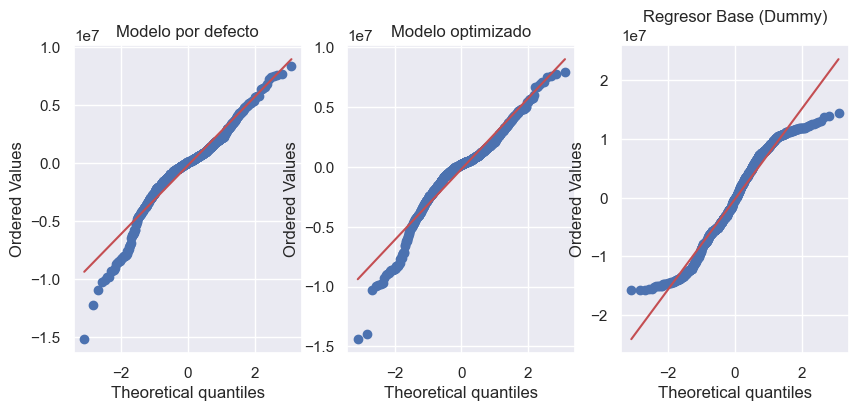

In [170]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Errores
ax_x_lgb = rendimiento_lgb['True Value']
ax_y_lgb = rendimiento_lgb['Prediction']
yerr_lgb = rendimiento_lgb['Error']

# QQ Plot
probplot(yerr_lgb, dist='norm', plot=axs[0])
axs[0].set_title('Modelo por defecto')

# Errores
ax_x_lgb_random = rendimiento_lgb_random['True Value']
ax_y_lgb_random = rendimiento_lgb_random['Prediction']
yerr_lgb_random = rendimiento_lgb_random['Error']

# QQ Plot
probplot(yerr_lgb_random, dist='norm', plot=axs[1])
axs[1].set_title('Modelo optimizado')

# QQ Plot
probplot(yerr_dummy, dist='norm', plot=axs[2])
axs[2].set_title('Regresor Base (Dummy)')

plt.show()

### Interpretar la importancia de los atributos según aquellas técnicas que lo permitan

Para poder interpretar la importancia de los atributos, vamos a dividir este apartado en los diferentes modelos avanzandos que hemos empleado y comentar primero si se puede o no comprobar la importancia de los atributos. En caso positivo, las conclusiones correspondientes a los resultados observados:

- `SVM`: para este modelo no hemos podidos comprobar la importancia de los atributos ya que la única manera que se pueden comprobar es a través de `.coefs_` que sirve para ver el peso de cada atributo. No obstante, este parámetros solo esta disponible para SVC, es decir, máquinas de soporte vectorial de clasificación.

- `Random Forests`: este modelo si que nos permitía comprobar la importancia de cada atributo. Nosotros hemos comprobado la importancia en base a la pureza, que nos daba lo siguiente:

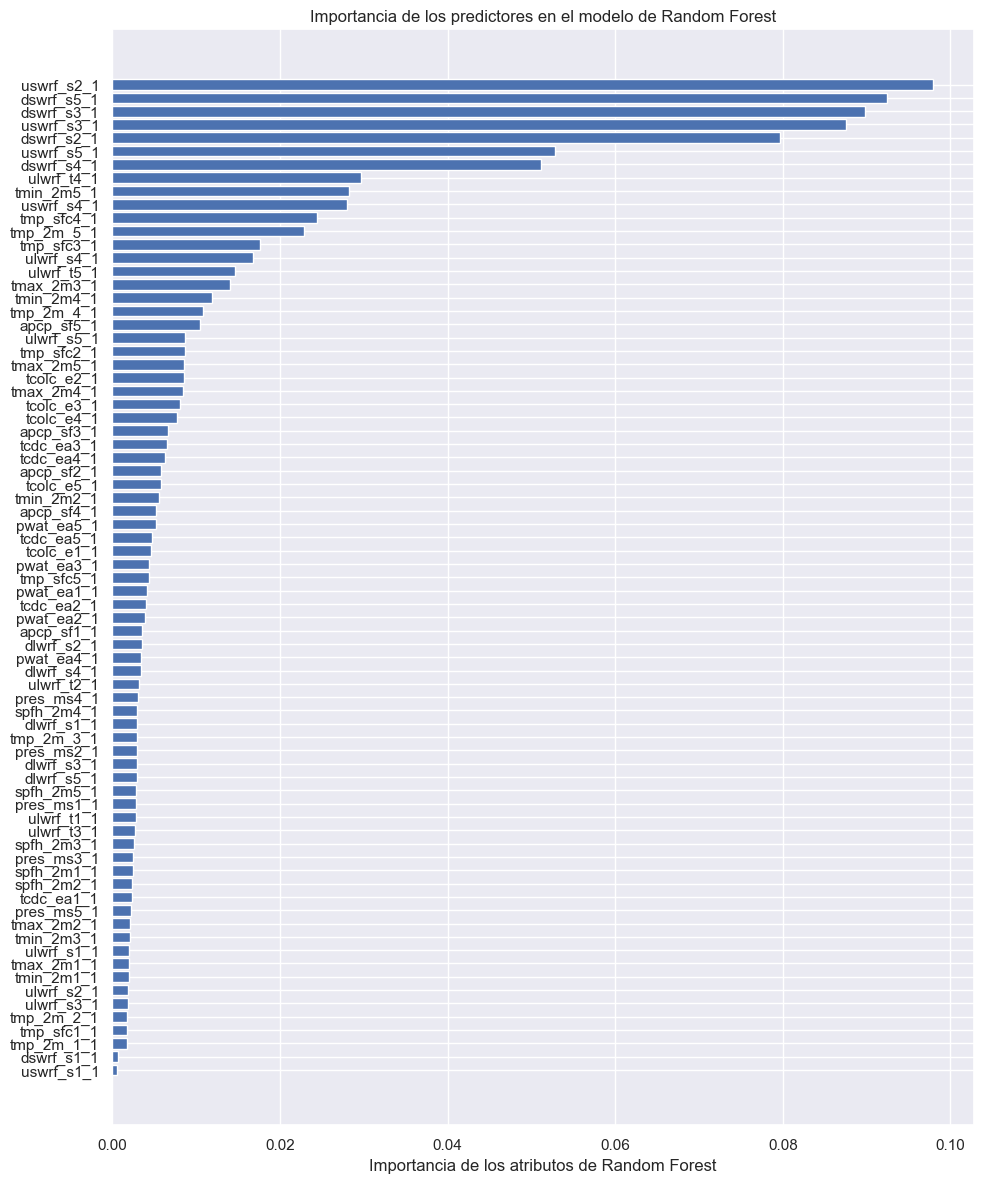

In [171]:
# Obtener los índices ordenados de importancia de los predictores
sorted_idx = _rf.feature_importances_.argsort()

# Crear una figura más grande
plt.figure(figsize=(10, 12))

# Graficar los datos en un gráfico de barras horizontales
plt.barh(entrada.columns[sorted_idx], _rf.feature_importances_[sorted_idx])

# Agregar etiquetas y título al gráfico
plt.xlabel("Importancia de los atributos de Random Forest")
plt.title("Importancia de los predictores en el modelo de Random Forest")

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Como se puede observar incluso el predictor con mayor importancia tiene una importancia menor que el 10%, lo que indica que de por si los predictores no tienen mucho peso predictivo. Aun así, el peor de todos los predictores es el 70, con una importancia del 0.05%. Dicho esto, los 19 primeros predictores de la lista tienen una importancia entre el 9% y el 1%, a partir de ahí comienzan a bajar. Entendemos que ya una importancia menor del 1% es casi insignificativa a tener el cuenta que es el resto de 56 predictores.

También comprobamos la importancia de los atributos por permutación:

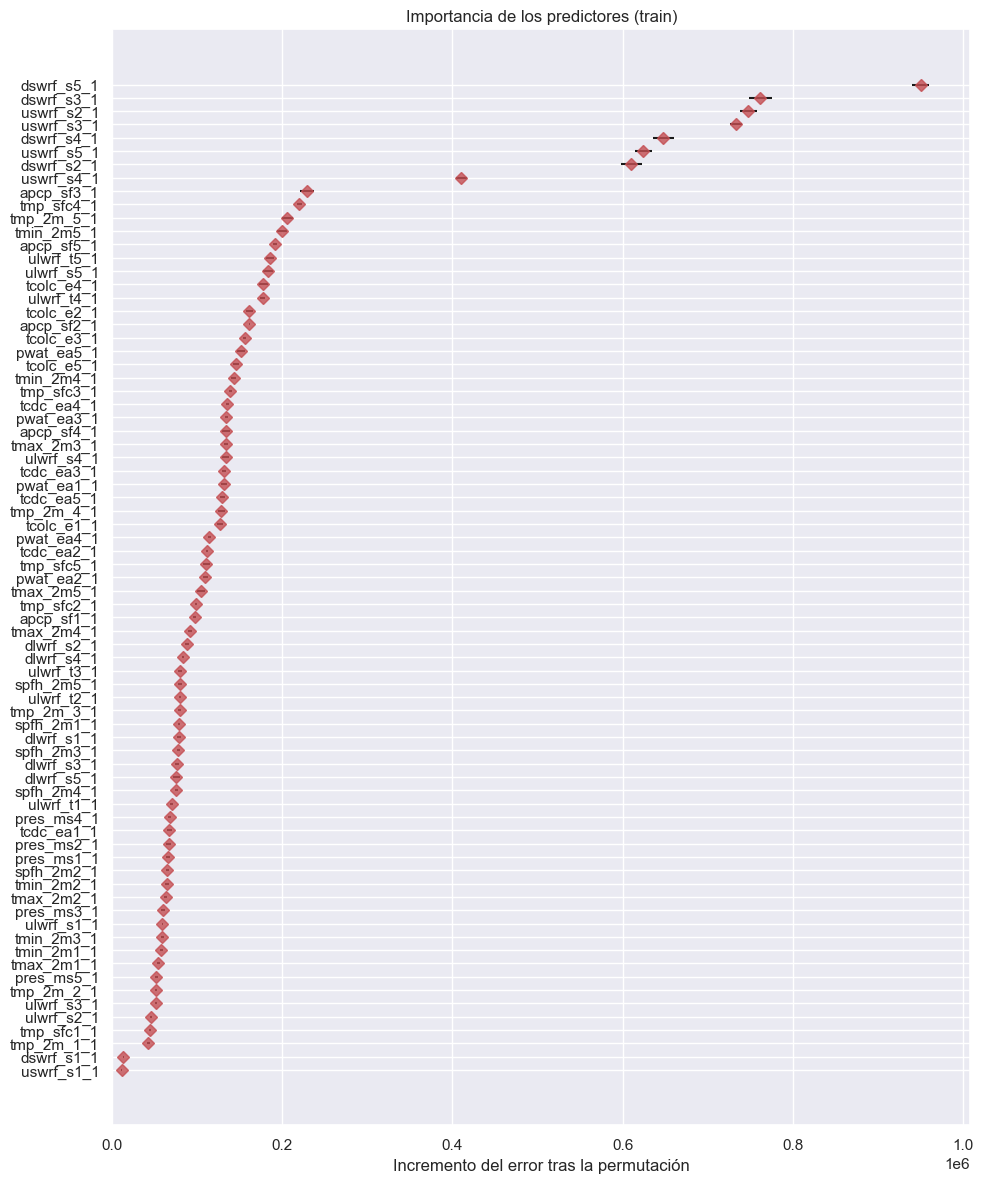

In [172]:
# Crear una figura más grande
fig, ax = plt.subplots(figsize=(10, 12))

# Ordenar los datos por importancia
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)

# Graficar los datos
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

# Agregar etiquetas y título al gráfico
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Esta representación, tiene como objetivo mostrar la importancia de cada uno de los predictores de los datos proporcionados.

Con los "puntos" mostrados, podemos ver la importancia relativa y con los datos de la tabla la variabilidad con la desviación estándar "std". Estos dos factores están relacionados puesto que indican que para valores altos de error, es decir, puntos más a la derecha, la importancia estimada tiene un alto grado de incertidumbre. Por el contrario, los puntos mas cercanos al eje "y" significan que la importancia estimada es más precisa. Esto lo podemos asociar con que los puntos más alejados del eje "y" tienen una mayor influencia sobre el modelo y los más próximos menos influencia con respecto al modelo. Ya que si los primeros cambian, afectarán en mayor grado y por tanto tendran una mayor variabilidad.

Esta observación tiene sentido puesto que se nos indica en el gráfico, que las variables más determinantes para el modelo son aquellas relcacionadas con la radiación solar "dswrf" y "uswrf". Analizando las menos importantes, podemos encontrar la temperatura existente a 2 metros sobre el suelo "tmp_2m" y la presión del aire "press_msl".

- `Extra Randomized Trees`: este modelo si que nos permitía comprobar la importancia de cada atributo. Nosotros hemos comprobado la importancia en base a la pureza, que nos daba lo siguiente:

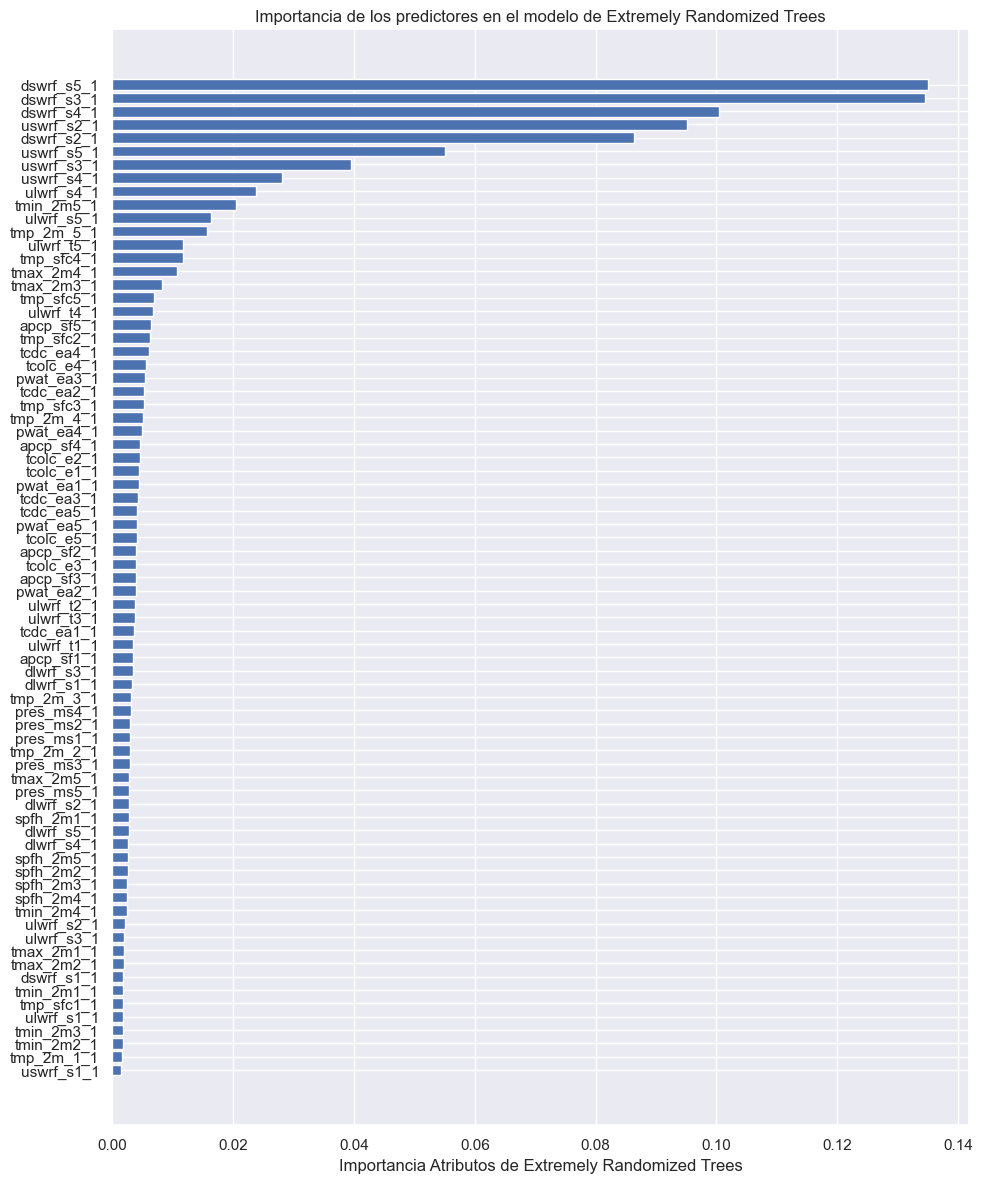

In [173]:
# Obtener los índices ordenados de importancia de los predictores
sorted_idx = _extra.feature_importances_.argsort()

# Crear una figura más grande
plt.figure(figsize=(10, 12))

# Graficar los datos en un gráfico de barras horizontales
plt.barh(entrada.columns[sorted_idx], _extra.feature_importances_[sorted_idx])

# Agregar etiquetas y título al gráfico
plt.xlabel("Importancia Atributos de Extremely Randomized Trees")
plt.title("Importancia de los predictores en el modelo de Extremely Randomized Trees")

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Como se puede observar incluso el predictor con mayor importancia tiene una importancia del 13%, lo que indica que de por si los predictores no tienen mucho peso predictivo. Aun así, el peor de todos los predictores es el 70 (al igual que en RF), con una importancia del 0.1452%. Dicho esto, los 15 primeros predictores de la lista tienen una importancia entre el 13% y el 1%, a partir de ahí comienzan a bajar. Entendemos que ya una importancia menor del 1% es casi insignificativa a tener el cuenta que es el resto de 60 predictores.

También comprobamos la importancia de los atributos por permutación:

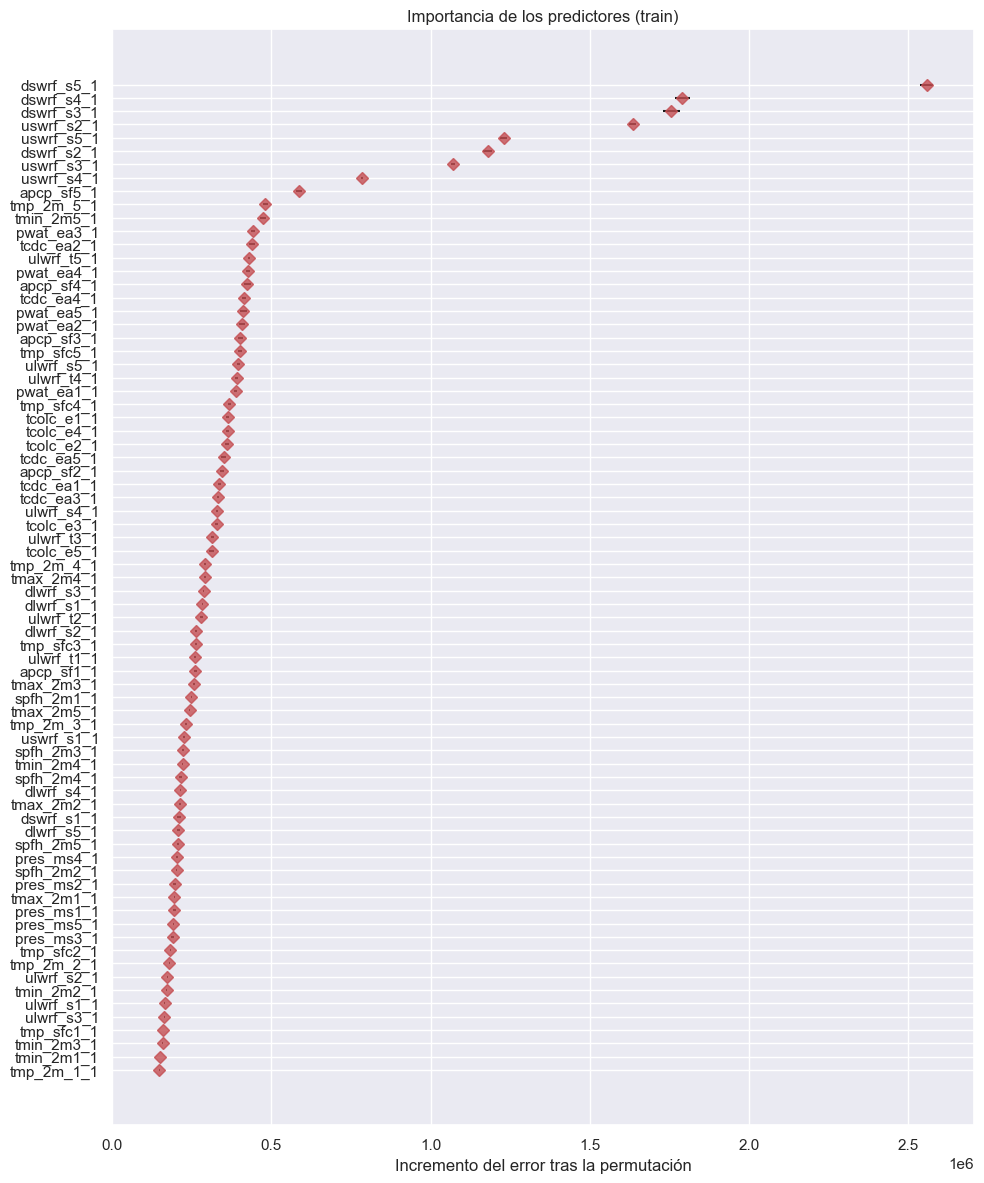

In [174]:
# Crear una figura más grande
fig, ax = plt.subplots(figsize=(10, 12))

# Ordenar los datos por importancia
df_importancia_extra = df_importancia_extra.sort_values('importances_mean', ascending=True)

# Graficar los datos
ax.barh(
    df_importancia_extra['feature'],
    df_importancia_extra['importances_mean'],
    xerr=df_importancia_extra['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia_extra['importances_mean'],
    df_importancia_extra['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

# Agregar etiquetas y título al gráfico
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Esta representación, tiene como objetivo mostrar la importancia de cada uno de los predictores de los datos proporcionados.

Con los "puntos" mostrados, podemos ver la importancia relativa y con los datos de la tabla la variabilidad con la desviación estándar "std". Estos dos factores están relacionados puesto que indican que para valores altos de error, es decir, puntos más a la derecha, la importancia estimada tiene un alto grado de incertidumbre. Por el contrario, los puntos mas cercanos al eje "y" significan que la importancia estimada es más precisa. Esto lo podemos asociar con que los puntos más alejados del eje "y" tienen una mayor influencia sobre el modelo y los más próximos menos influencia con respecto al modelo. Ya que si los primeros cambian, afectarán en mayor grado y por tanto tendran una mayor variabilidad.

Esta observación tiene sentido puesto que se nos indica en el gráfico, que las variables más determinantes para el modelo son aquellas relcacionadas con la radiación solar "dswrf" y "uswrf". Analizando las menos importantes, podemos encontrar la temperatura existente a 2 metros sobre el suelo "tmp_2m", mínima temperatura de las últimas 3 horas a 2 mestros del suelo "tmin_2m" y la presión del aire "press_msl".

- `Hist Gradient Boosting`: para este modelo no hemos podido comprobar la importancia de cada atributo ya que el parámetro de `.feature_importances_` solo esta disponible para `GradientBoostingRegressor` no para `HistGradientBoostingRegressor`.
- `XGBoost y LightGBM`: para este modelo no hemos podido comprobar la importancia de cada atributo ya que el parámetro de `.feature_importances_` solo esta disponible para `GradientBoostingRegressor`.

### Conclusiones hasta el momento

- ¿Cuál es el mejor método?

Con respecto a esta tabla, debemos destacar dos hechos. El primero de ellos, es que todos los modelos avanzados que hemos empleado tienen mejores valores que el dummy, lo cual indica que seguimos en buen camino. En segundo lugar, podemos percibir que todos los modelos presentan valores de RMSE, MAE y R² bastante favorables donde destaca por encima del resto el `HistGradientBoost`. 
Este modelo presenta los menores valores de RMSE y MAE con diferencias (la media de todos los valores restantes de dichos errrores) del 6% y 8% respectivamente. Con respecto a R² presenta el mayor valor siendo este de 0.85; es decir, un 2.9% mayor que el resto de las modelos. Por todo ello, podemos concluir que el mejor método en este caso es el `HistGradientBoost`.

In [175]:
# Errores de los mejores modelos de cada método
# ==============================================================================
d_final_av = [["SVM (Linear)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_val)), mean_absolute_error(y_test, y_pred = predicciones_svm_val), r2_score(y_test, y_pred = predicciones_svm_val)],
          ["Random Forest", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf_ft)), mean_absolute_error(y_test, y_pred = predicciones_rf_ft), r2_score(y_test, y_pred = predicciones_rf_ft)],
          ["EXTRA Trees", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra_random)), mean_absolute_error(y_test, y_pred = predicciones_extra_random), r2_score(y_test, y_pred = predicciones_extra_random)],
          ["HistGradientBoost", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb)), mean_absolute_error(y_test, y_pred = predicciones_gb), r2_score(y_test, y_pred = predicciones_gb)],
          ["XGBoost", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb_random)), mean_absolute_error(y_test, y_pred = predicciones_xgb_random), r2_score(y_test, y_pred = predicciones_xgb_random)],
          ["LightGBM", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb_random)), mean_absolute_error(y_test, y_pred = predicciones_lgb_random), r2_score(y_test, y_pred = predicciones_lgb_random)],
          ["Modelo Dummy",np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_dummy)), mean_absolute_error(y_test, y_pred = predicciones_dummy), r2_score(y_test, y_pred = predicciones_dummy)]]

df_final_av = pd.DataFrame(d_final_av, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_final_av)

              Modelo          RMSE           MAE        R²
0       SVM (Linear)  3.122590e+06  2.211471e+06  0.838803
1      Random Forest  3.028637e+06  2.124389e+06  0.848357
2        EXTRA Trees  3.038024e+06  2.125455e+06  0.847415
3  HistGradientBoost  2.987827e+06  2.078429e+06  0.852416
4            XGBoost  3.092693e+06  2.236348e+06  0.841875
5           LightGBM  3.046676e+06  2.125428e+06  0.846545
6       Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


-  ¿Cuál de los métodos avanzados de aprendizaje automático es más rápido?

En esta tabla podemos comparar los distintos tiempos de ejecución de los métodos avanzados. Podemos de alguna forma dividir los métodos en aquellos que tienen tiempos “razonables” y “desorbitados”. En el primer grupo encontramos a SVM(Linear), Random Forest y HistGradientBoost, cuyos tiempos no superan los 64 segundos. Cabe resaltar, que nos ha sorprendido el valor de HistgGradientBoost con un tiempo de 4.25 segundos. En el segundo grupo, encontramos a EXTRA Trees, XGBoost y LightGBM cuyos tiempos de ejecución se encuentran por encima de los 100 segundos. De todos ellos, hay que destacar que LightGBM tiene un valor de 400 segundos, que en comparación al resto es muy superior. 
Por todo lo explicado, podemos resaltar que `HistGradient` presenta el menor tiempo (4 segundos); convirtiéndole en el método más rápido. Además, este tiempo es 100 veces inferior que el proporcionado por el modelo más lento: LightGBM.

In [176]:
# Tiempo de los mejores modelos de cada método
# ==============================================================================
d_final_t_av = [["SVM (Linear)", t_final_svm_val - t_previo_svm_val],
          ["Random Forest", t_final_random_ft - t_previo_random_ft],
          ["EXTRA Trees", t_final_random_extra - t_previo_random_extra],
          ["HistGradientBoost", t_final_gb - t_previo_gb],
          ["XGBoost", t_final_random_xgb - t_previo_random_xgb],
          ["LightGBM", t_final_random_lgb - t_previo_random_lgb],
          ["Modelo Dummy", t_final_dummy - t_previo_dummy]]

df_final_t_av = pd.DataFrame(d_final_t_av, columns = ['Modelo', 'Tiempo'])
print(df_final_t_av)

              Modelo      Tiempo
0       SVM (Linear)   64.965643
1      Random Forest   53.287654
2        EXTRA Trees  124.572671
3  HistGradientBoost    3.424793
4            XGBoost  117.341908
5           LightGBM  256.730326
6       Modelo Dummy    0.008865


- ¿Los resultados son mejores que los regresores triviales/naive/baseline?

Como ya se ha comentado previamente, los resultados de los modelos son mejores que el modelo Dummy; existiendo unas diferencias del 62%, 69% y 85771% con respecto a los mejores valores de RMSE, MAE y R².

In [177]:
print(df_final_av)

              Modelo          RMSE           MAE        R²
0       SVM (Linear)  3.122590e+06  2.211471e+06  0.838803
1      Random Forest  3.028637e+06  2.124389e+06  0.848357
2        EXTRA Trees  3.038024e+06  2.125455e+06  0.847415
3  HistGradientBoost  2.987827e+06  2.078429e+06  0.852416
4            XGBoost  3.092693e+06  2.236348e+06  0.841875
5           LightGBM  3.046676e+06  2.125428e+06  0.846545
6       Modelo Dummy  7.781279e+06  6.659113e+06 -0.000991


- ¿El ajuste de hiperparámetros mejora con respecto a los valores por omisión?

En esta última tabla, vamos a comparar los modelos de defecto con respecto a los optimizados. Para ello, podemos clasificar todos los modelos en dos grupos, los que mejoran con respecto al modelo por defecto y los que no mejoran.
- `Mejora`: en este grupo encontramos a SVM (Linear), Random Forest, EXTRA Trees, XGBoost y LightGBM. En términos generales queremos remarcar que las dierencias entre defecto y mejorado son ínfimas en todos los modelos excepto en SVM donde el cambio fue más representativo. En este, los valores de RMSE se redujeron en un 60% y los de MAE en un 66%. Con respecto al R², se produjo un icremento del 48%.
- `No mejora`: en este grupo se encuentra únicamente HistGradientBoost, donde presenta valores de RMSE y MAE más elevados que el modelo de defecto. Y valores de R² más reducidos que el modelo de defecto.

In [178]:
# Errores 
# ==============================================================================
d_final_av = [["SVM (Linear Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm)), mean_absolute_error(y_test, y_pred = predicciones_svm), r2_score(y_test, y_pred = predicciones_svm)],
          ["SVM (Linear)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_svm_val)), mean_absolute_error(y_test, y_pred = predicciones_svm_val), r2_score(y_test, y_pred = predicciones_svm_val)],
          ["Random Forest (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf)), mean_absolute_error(y_test, y_pred = predicciones_rf), r2_score(y_test, y_pred = predicciones_rf)],
          ["Random Forest (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rf_ft)), mean_absolute_error(y_test, y_pred = predicciones_rf_ft), r2_score(y_test, y_pred = predicciones_rf_ft)],
          ["EXTRA Trees (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra)), mean_absolute_error(y_test, y_pred = predicciones_extra), r2_score(y_test, y_pred = predicciones_extra)],
          ["EXTRA Trees (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_extra_random)), mean_absolute_error(y_test, y_pred = predicciones_extra_random), r2_score(y_test, y_pred = predicciones_extra_random)],
          ["HistGradientBoost (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb)), mean_absolute_error(y_test, y_pred = predicciones_gb), r2_score(y_test, y_pred = predicciones_gb)],
          ["HistGradientBoost (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb_random)), mean_absolute_error(y_test, y_pred = predicciones_gb_random), r2_score(y_test, y_pred = predicciones_gb_random)],
          ["XGBoost (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb)), mean_absolute_error(y_test, y_pred = predicciones_xgb), r2_score(y_test, y_pred = predicciones_xgb)],
          ["XGBoost (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_xgb_random)), mean_absolute_error(y_test, y_pred = predicciones_xgb_random), r2_score(y_test, y_pred = predicciones_xgb_random)],
          ["LightGBM (Defecto)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb)), mean_absolute_error(y_test, y_pred = predicciones_lgb), r2_score(y_test, y_pred = predicciones_lgb)],
          ["LightGBM (Optimizado)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_lgb_random)), mean_absolute_error(y_test, y_pred = predicciones_lgb_random), r2_score(y_test, y_pred = predicciones_lgb_random)]]

df_final_av = pd.DataFrame(d_final_av, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_final_av)

                            Modelo          RMSE           MAE        R²
0             SVM (Linear Defecto)  7.709832e+06  6.591693e+06  0.017307
1                     SVM (Linear)  3.122590e+06  2.211471e+06  0.838803
2          Random Forest (Defecto)  3.158626e+06  2.177013e+06  0.835061
3       Random Forest (Optimizado)  3.028637e+06  2.124389e+06  0.848357
4            EXTRA Trees (Defecto)  3.069079e+06  2.134174e+06  0.844280
5         EXTRA Trees (Optimizado)  3.038024e+06  2.125455e+06  0.847415
6      HistGradientBoost (Defecto)  2.987827e+06  2.078429e+06  0.852416
7   HistGradientBoost (Optimizado)  3.026129e+06  2.127012e+06  0.848608
8                XGBoost (Defecto)  3.095892e+06  2.197661e+06  0.841547
9             XGBoost (Optimizado)  3.092693e+06  2.236348e+06  0.841875
10              LightGBM (Defecto)  3.035529e+06  2.113429e+06  0.847666
11           LightGBM (Optimizado)  3.046676e+06  2.125428e+06  0.846545


- ¿Hay algún equilibrio entre tiempo de ejecución y mejora de resultados?

Por último, no hemos encontrado ninguna relación entre resultados y tiempo puesto que todos los valores finales de cada método son bastante similares a pesar de tener grandes diferencias con respecto al tiempo de ejecución. Sin embargo, en este caso, si que coincide justo que el modelo con menor tiempo de ejecución es el que mejores resultados producen.

## Seleccionar el mejor método, evaluarlo, construir modelo final, hacer predicciones para la competición

Para poder determinar cuál de los métodos es el mejor, vamos a realizar una comparativa con el mejor método básico y el mejor método avanzado. Como se puede observar, para nuestro conjunto de datos, el mejor modelo es el de `Regresión Lineal con regularización Ridge` aunque no por mucha diferencia. 

In [179]:
# Errores de los mejores métodos
# ==============================================================================
d_final_total = [["Regresión Lineal (Ridge)", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_rgr_ridge)), mean_absolute_error(y_test, y_pred = predicciones_rgr_ridge), r2_score(y_test, y_pred = predicciones_rgr_ridge)],
          ["HistGradientBoost", np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_gb)), mean_absolute_error(y_test, y_pred = predicciones_gb), r2_score(y_test, y_pred = predicciones_gb)],]

df_final_total = pd.DataFrame(d_final_total, columns = ['Modelo', 'RMSE', 'MAE', 'R²'])
print(df_final_total)

                     Modelo          RMSE           MAE        R²
0  Regresión Lineal (Ridge)  2.938107e+06  2.104059e+06  0.857287
1         HistGradientBoost  2.987827e+06  2.078429e+06  0.852416


Una vez hemos seleccionado el mejor método de los evaluados en los puntos anteriores, usamos la partición de test para evaluar ese mejor método. Esta es una estimación de cómo se desempeñaría el modelo en la competición. Entrenamos el modelo final y lo guardarmos en un fichero (llamado «modelo_final.pkl»).

--> `NOTA`: Hemos cogido el valor de alpha correspondiente al modelo con la regularización de Ridge que sacamos en el apartado de Regresión ineal de métodos básicos

In [183]:
MODELO_FINAL = regrRidge

# Entrenamos el modelo
t_previo_MODELO_FINAL= time.time()
MODELO_FINAL_ENTRENADO = MODELO_FINAL.fit(X = X_train, y = y_train)
t_final_MODELO_FINAL = time.time()

print("El tiempo de entrenamiento del modelo es de : ", t_final_MODELO_FINAL - t_previo_MODELO_FINAL ," segundos")

El tiempo de entrenamiento del modelo es de :  1.1420326232910156  segundos


In [184]:
predicciones_MODELO_FINAL = MODELO_FINAL_ENTRENADO.predict(X_test)

# Error RMSE
rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones_MODELO_FINAL))
print(f"El error (RMSE) de test es: {rmse}")

# Error MAE
mae = mean_absolute_error(y_test, y_pred = predicciones_MODELO_FINAL)
print(f"El error (MAE) de test es: {mae}")

# Error R^2
r2 = r2_score(y_test, y_pred = predicciones_MODELO_FINAL)
print(f"El error (R²) de test es: {r2}")

El error (RMSE) de test es: 2938107.371070354
El error (MAE) de test es: 2104058.792624109
El error (R²) de test es: 0.8572870089595548


In [185]:
# Guardamos el modelo un fichero pkl
pkl_filename = "modelo_final.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(MODELO_FINAL_ENTRENADO, file)

## Bibliografía

- Arboles de decision python. (s. f.). https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html 
- Bprasad26. (2022, 22 marzo). How to Create a Baseline Regression Model in scikit Learn. Life With Data. https://lifewithdata.com/2022/03/22/how-to-create-a-baseline-regression-model-in-scikit-learn/ 
- Convert a 1D array to a 2D array in numpy. (2012, 25 septiembre). Stack Overflow. https://stackoverflow.com/questions/12575421/convert-a-1d-array-to-a-2d-array-in-numpy 
- Chouinard, J. (2022). PCA: Principal Component Analysis using Python (Scikit-learn). JC Chouinard. https://www.jcchouinard.com/pca-with-python/ 
- Distance computations (scipy.spatial.distance) — SciPy v1.10.1 Manual. (s. f.). https://docs.scipy.org/doc/scipy/reference/spatial.distance.html 
- Extremely Randomized Trees | Interactive Chaos. (s. f.). https://interactivechaos.com/es/manual/tutorial-de-machine-learning/extremely-randomized-trees
- Fernandez, R. (2019, 6 septiembre). Machine Learning Nearest Neighbors Regression. ▷ Cursos de Programación de 0 a Experto © Garantizados. https://unipython.com/machine-learning-nearest-neighbors-regression/
- GeeksforGeeks. (2021, 22 enero). Dummy Regressor. https://www.geeksforgeeks.org/dummy-regressor/ 
- Heras, J. M. (2020, 19 septiembre). Árboles de Decisión con ejemplos en Python. IArtificial.net. https://www.iartificial.net/
- Hashmi, F. (2021, 27 noviembre). How to perform Independent Component Analysis(ICA) in Python - Thinking Neuron. Thinking Neuron. https://thinkingneuron.com/how-to-perform-independent-component-analysisica-in-python/arboles-de-decision-con-ejemplos-en-python/ 
- numpy.linspace — NumPy v1.25.dev0 Manual. (s. f.). https://numpy.org/devdocs/reference/generated/numpy.linspace.html 
- Santos, G. (2022, 21 mayo). KNN Regression Model in Python - Towards Data Science. Medium. https://towardsdatascience.com/knn-regression-model-in-python-9868f21c9fa2
- Sharma, P. (2022). The Ultimate Guide to 12 Dimensionality Reduction Techniques (with Python codes). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/ 
- sklearn.model_selection.GridSearchCV. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 
- sklearn.ensemble.HistGradientBoostingRegressor. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html  
- sklearn.dummy.DummyRegressor. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html
- sklearn.neighbors.KNeighborsRegressor. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html 
- sklearn.decomposition.PCA. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 
- sklearn.decomposition.PCA. (s. f.-b). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 
- sklearn.decomposition.FastICA. (s. f.). scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html 
- UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction — umap 0.5 documentation. (s. f.). https://umap-learn.readthedocs.io/en/latest/ 